# Import Library

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# pre-processing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE

# ML
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#plot Tree
from sklearn import tree

# Function

In [ ]:
'''
Fungsi untuk merubah nilai pada dataframe
'''
def score_to_graduate(data):
  if data['NL.HRF'] == "C-" or data['NL.HRF'] == "D" or data['NL.HRF'] == "E":
    val = "Tidak Lulus"
  else:
    val = "Lulus"
  return val

def score_to_predicate(data):
  nilai = data['NL.HRF']
  if nilai == "C-" or nilai == "D" or nilai == "E":
    val = "Tidak Lulus"
  elif nilai == "C" or nilai == "C+":
    val = "Cukup"
  elif nilai == "B-" or nilai == "B" or nilai == "B+":
    val = "Baik"
  else:
    val = "Sangat Baik"
  return val

In [ ]:
'''
Fungs-Fungsi untuk penyajian data
'''
def count_unique(dataframe):
  return dataframe.nunique()

def count_null(dataframe):
  null_values = dataframe.isna().sum()
  return np.array(null_values.index), np.array(null_values.values)

def show_correlation(dataframe, corr='pearson', figsize=(20, 20)):
  plt.figure(figsize=figsize)
  sns.heatmap(dataframe.corr(method=corr), vmin=-1, cmap='YlGnBu', annot = True)
  plt.show()

def show_horizontal_bar(x, y, title=None, figsize=(20, 7)):
  plt.figure(figsize=figsize)
  plt.bar(x, y,
          color = sns.color_palette("hls", len(x))
          )
  for idx, value in enumerate(y):
    plt.text(idx, value, str(value))
  plt.title(title)
  plt.show()

def show_vertical_bar(x, y, title=None, figsize=(20, 7)):
  fig, ax = plt.subplots(figsize=figsize)
  ax.barh(x, y,
        color = sns.color_palette("hls", len(x))
        )
  for idx, value in enumerate(y):
    if value > 0:
      ax.text(value, idx, str(value))
  ax.invert_yaxis()
  ax.set_title(title)
  plt.show()

def show_pie_chart(ls_data, labels, title=None, figsize=(20, 7)):
  plt.figure(figsize=figsize)
  plt.pie(ls_data, labels=labels, 
        colors = sns.color_palette("hls", len(labels)), 
        autopct='%1.1f%%', 
        textprops={'fontsize':14, 'color':'white'})
  plt.title(title)
  plt.legend()
  plt.show()

def show_boxplot(dataframe, title=None, figsize=(20, 7)):
  plt.figure(figsize=figsize)
  sns.boxplot(data=dataframe)
  plt.xticks(rotation=90, ha='right')
  plt.title(title)
  plt.show()

In [ ]:
def find_null(dataframe):
  dict_val_nan = {}
  for i in dataframe:
    index_nan = dataframe.index[dataframe[i].apply(pd.isnull)].to_list()
    if index_nan:
      dict_val_nan[i] = np.array(index_nan)
  return dict_val_nan

def handle_nulls(dataframe, strategy="mean", new_value=None):
  dataframe_copy = dataframe.copy()
  if strategy == "special":
    return specialized_handle_null(dataframe_copy)

  null_loc = find_null(dataframe_copy)
  for loc in null_loc:
    if dataframe_copy[loc].dtypes != "object":
      # print(loc)
      new_val = 0
      if strategy == "mean":
        new_val = dataframe_copy[loc].mean()
      elif strategy == "mode":
        new_val = dataframe_copy[loc].mode()[0]
      elif strategy == "median":
        new_val = dataframe_copy[loc].median()
      elif strategy == "value":
        if not new_value:
          raise Exception("Sorry new value parameter must not to be None")
        new_val = new_value
      else: 
        new_val = 0
      # print(new_val)
      for index in null_loc[loc]:
        dataframe_copy.at[index, loc] = new_val
  return dataframe_copy

def specialized_handle_null(dataframe):
  dataframe_copy = dataframe.copy()
  tgsk_group = dataframe_copy.filter(regex="TgsK")
  tgsk_mean = tgsk_group.mean(axis=1)
  null_loc = find_null(tgsk_group)
  # print(tgsk_mean[0])
  for loc in null_loc:
    for index in null_loc[loc]:
      dataframe_copy.at[index, loc] = tgsk_mean[index]
  return dataframe_copy

def get_outliers_loc(dataframe):
  num_data = dataframe.select_dtypes(include="number")
  quantile_df = pd.DataFrame()
  for i in num_data:
    quantile = num_data[i].quantile([0.25,0.5,0.75])
    quantile_df[i] = quantile
  
  IQR = []
  low_whisker = []
  upp_whisker = []
  for i in range(0, quantile_df.shape[1]):
    c_name = quantile_df.columns[i]
    count_iqr = quantile_df.at[0.75, c_name] - quantile_df.at[0.25, c_name]
    count_low = quantile_df.at[0.25, c_name] - (1.5 * count_iqr)
    count_upp = quantile_df.at[0.75, c_name] + (1.5 * count_iqr)
    IQR.append(count_iqr)
    low_whisker.append(count_low)
    upp_whisker.append(count_upp)
    
  quantile_df.loc['IQR'] = IQR
  quantile_df.loc['low_whisker'] = low_whisker
  quantile_df.loc['upp_whisker'] = upp_whisker

  # quantile_df = get_iqr(dataframe)
  dict_upp_outlier = {}
  dict_low_outlier = {}
  for i in quantile_df.columns:
    # print(i)
    low_whs = quantile_df.at['low_whisker', i]
    # print(low_whs)
    index_low = num_data.index[num_data[i] <= low_whs].to_list()
    # print(index_low)
    if index_low:
      dict_low_outlier[i] = np.array(index_low)
    
    upp_whs = quantile_df.at['upp_whisker', i]
    # print(upp_whs)
    
    index_upp = num_data.index[num_data[i] >= upp_whs].to_list()
    # print(index_upp)
    if index_upp:
      dict_upp_outlier[i] = np.array(index_upp)

  # return quantile_df
  return dict_upp_outlier, dict_low_outlier

def get_ouliers_val(dataframe):
  upp_outlier, low_outlier = get_outliers_loc(dataframe)
  
  upp_outlier_vals = {}
  low_outlier_vals = {}
  
  for upp_feature in upp_outlier:
    index_vals = []
    for index in upp_outlier[upp_feature]:
      index_vals.append(dataframe.at[index, upp_feature])
    upp_outlier_vals[upp_feature] = np.array(index_vals)
  
  for low_feature in low_outlier:
    index_vals = []
    for index in low_outlier[low_feature]:
      index_vals.append(dataframe.at[index, low_feature])
    low_outlier_vals[low_feature] = np.array(index_vals)

  return upp_outlier_vals, low_outlier_vals

def handle_outliers(dataframe):
  return

# Class Machine Learning yang dibuat

## Class Node

In [ ]:
class Node():
  def __init__(self, feature=None, threshold=None, left=None, right=None, depth=None, class_vals=None, impurity=None, feature_type=None, gini=None, n_samples=None):
    '''Konstuktor'''
    self.impurity = impurity
    self.gini = gini
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.depth = depth
    self.class_value = class_vals
    self.feature_type = feature_type
    self.n_samples = n_samples

## Class Decision Tree

In [ ]:
from sklearn.metrics import accuracy_score
import json
import networkx as nx
from networkx.readwrite import json_graph
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

class MyDecisionTreeClassfier():
  __json_nodes = []
  __json_links = []
  __gini_dict = {}
  __tree_dict = None

  def __init__(self, min_sample_split=2, max_depth=None):
    '''Konstuktor'''
    self.root = None
    self.min_sample_split=min_sample_split
    self.max_depth=max_depth
  
  def get_params(self, deep=True):
    return {
        "min_sample_split": self.min_sample_split,
        "max_depth": self.max_depth
    }
  
  def gini_index(self, y):
    '''fungsi untuk menghitung nilai gini'''
    # labels = y.unique()
    labels = np.unique(y)
    gini = 0
    for label in labels:
      # print(label)
      # print(len(y.loc[y==label]))
      prob = len(y[y==label]) / len(y)
      # print(prob)
      gini += prob**2
    
    # print(1-gini)
    return 1 - gini
  
  def impurity_node(self, y, y_left, y_right):
    '''fungsi untuk menghitung impurity_node'''
    prob_l = len(y_left)  / len(y)
    prob_r = len(y_right) / len(y)
    avg_child = (prob_l * self.gini_index(y_left)) + (prob_r * self.gini_index(y_right))
    return self.gini_index(y) - avg_child
  
  def class_value(self, data):
    unique, counts = np.unique(data, return_counts=True)
    # mode = np.argwhere(counts == np.max(counts))
    # return mode
    vote_leaf = dict(zip(unique, counts))
    return max(vote_leaf, key=vote_leaf.get)
  
  def check_depth(self, depth):
    if self.max_depth == None:
      return True
    if depth < self.max_depth:
      return True
    return False

  def make_tree(self, datasets, depth):
    '''
    Fungsi untuk membuat pohon. Fungsi ini berjalan seacra rekursif dimana 
    akan mendapatkan terlebih dahulu pemilah terbaik lalu membagi dataset menjadi
    dua bagian sesuai dengan pemilah terbaik.

    '''
    # x, y = datasets.iloc[:, :-1], datasets.iloc[:, -1]
    x, y = datasets[:, :-1], datasets[:, -1]
    num_sample, num_feature = x.shape
    current_depth = depth
    # print(current_depth)
    # print(num_sample, num_feature)
    # pengecekkan apakah sudah masuk ke keriteria berhenti atau tidak
    if num_sample >= self.min_sample_split and self.check_depth(current_depth):
    # if num_sample >= self.min_sample_split:
      best_feature = 0
      best_threshold = 0
      max_impurity = 0

      # Mendapatkan best split
      # pengulangan untuk setiap feature
      for features in range(num_feature):
        feature_values = datasets[:, features]
        print(feature_values)
        thresholds = np.unique(feature_values)
        print(thresholds)
        # pengulangan untuk setiap ambang batas unik
        # print("features", features)
        for threshold in thresholds:
          # print("threshold", threshold)
          # feature_type = self.check_feature_type(datasets, features)
          feature_type = "numeric"
          left_data, right_data = self.split_data(datasets, features, threshold, feature_type)
          if right_data.size != 0 and left_data.size != 0:
            y = datasets[:, -1]
            y_l = left_data[:, -1]
            y_r = right_data[:, -1]
            impurity = self.impurity_node(y, y_l, y_r)
        #     print(str(features) + ", " + str(threshold) + ", " + str(impurity))
        # print()
            if impurity > max_impurity:
              best_feature = features
              best_threshold = threshold
              max_impurity = impurity
      
      if max_impurity > 0:
        # print("Best feature, best threshold, max info gain, depth")
        # print(str(best_feature) + ", " + str(best_threshold) + ", " + str(max_impurity) + ", " + str(current_depth) + "\n")
        gini = self.gini_index(datasets[:, -1])
        # feature_type = self.check_feature_type(datasets, best_feature)
        feature_type = "numeric"
        left_data, right_data = self.split_data(datasets, best_feature, best_threshold, feature_type)
        left_child = self.make_tree(left_data, current_depth+1)
        right_child = self.make_tree(right_data, current_depth+1)
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child, impurity=max_impurity, depth=current_depth, feature_type=feature_type, gini=gini, n_samples=num_sample)
    
    # print("depth")
    # print(str(current_depth) + "\n")
    # keluar dengan kriteria berhenti terpenuhi
    # print("kriteria berhenti terpenuhi")
    # print(Y)
    gini = self.gini_index(datasets[:, -1])
    class_vals = self.class_value(y)
    # print(class_vals)
    # print()
    return Node(class_vals=class_vals, depth=current_depth, gini=gini, n_samples=num_sample)
  
  def check_feature_type(self, datasets, feature):
    sub_data = datasets[:, feature]
    uq_sub_data = np.unique(sub_data)
    if 0 in uq_sub_data and 1 in uq_sub_data and uq_sub_data.size == 2:
      return "binary"
    return "numeric"

  def split_data(self, datasets, feature, threshold, feature_type):
    # left_data  = datasets.loc[datasets[feature] <  threshold]
    # right_data = datasets.loc[datasets[feature] >= threshold]
    left_data = []
    right_data = []
    # print(feature_type)
    if feature_type == "binary":
      # print(True)
      for row in datasets:
        if row[feature] == threshold:
          left_data.append(row)
        else:
          right_data.append(row)
    else:
      # print(False)
      for row in datasets:
        if row[feature] <= threshold:
          left_data.append(row)
        else:
          right_data.append(row)

    return np.array(left_data), np.array(right_data)

  def fit(self, X, y):
    '''fungsi untuk melatih pohon'''
    self.X = X
    self.y = y
    # data = pd.concat([X, y], axis=1)
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    self.root = self.make_tree(data, 0)
    self.__tree_dict = self.get_json_tree()
  
  def predict(self, X):
    prd_rst = []
    for x in X:
      rst = self.visit_tree(self.root, x)
      # print(rst)
      prd_rst.append(rst)
    return np.array(prd_rst)
  
  def visit_tree(self, tree, x):
    if tree.class_value != None:
      return tree.class_value
    
    if tree.feature_type == "numeric":
      if x[tree.feature] <= tree.threshold:
        return self.visit_tree(tree.left, x)
      else:
        return self.visit_tree(tree.right, x)
    elif tree.feature_type == "binary":
      if x[tree.feature] == tree.threshold:
        return self.visit_tree(tree.left, x)
      else:
        return self.visit_tree(tree.right, x)
  
  def score(self, X, y):
    pred = self.predict(X)
    return accuracy_score(y, pred)
  
  def get_json_tree(self):
    if self.root == None:
      raise Exception("There's no tree here")
    tree = self.node_data(self.root)
    json_tree = json.dumps(tree, indent=3)
    # print(json_tree)
    return tree
  
  def node_data(self, node):
    compare_symbol = ""
    if node.feature_type == "numeric":
      compare_symbol = "<="
    else:
      compare_symbol = "=="

    if node.class_value == None:
      node = {
          "id": id(node),
          "rule": "X[" + str(node.feature) + "] " + compare_symbol + " " + str(node.threshold),
          "impurity": node.impurity,
          "gini": node.gini,
          "depth": node.depth,
          "n_sample": node.n_samples,
          "left_node": self.node_data(node.left),
          "right_node": self.node_data(node.right)
      }
      return node
    else:
      node = {
          "id": id(node),
          "gini": node.gini,
          "depth": node.depth,
          "n_sample": node.n_samples,
          "class": node.class_value
      }
      return node
  
  def get_tree_dict(self):
    return self.__tree_dict

  def set_tree_dict(self, tree_dictionary):
    self.__tree_dict = tree_dictionary

  def vizualise_tree(self):
    tree_dict = self.get_tree_dict()
    self.__json_nodes = []
    self.__json_links = []
    self.__get_json_nodes(tree_dict)

    graph_json = {
        "nodes": self.__json_nodes,
        "links": self.__json_links
    }
    node_labels = {node['id']:node['rule'] for node in graph_json['nodes']}
    for n in graph_json['nodes']:
      del n['rule']
    g = json_graph.node_link_graph(graph_json, directed=True, multigraph=False)
    pos = graphviz_layout(g, prog="dot")

    plt.figure(figsize=(20, 20))
    nx.draw(
        g.to_directed(), 
        pos, 
        labels=node_labels, 
        with_labels=True,
        node_shape="s",
        node_size=1500,
        node_color="none",
        font_size=20,
        bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'),
        width=1.5
        )
    plt.show()
  
  def __get_json_nodes(self, node, parent=None):
    # print(node)
    id = node['id']
    if 'left_node' in node and 'right_node' in node:
      impurity = '\nimpurity: ' + str(np.round(node['impurity'], 4))
      rule = "rule: " + node['rule'] + "\ngini: " + str(np.round(node['gini'], 4)) + "\ndepth: " + str(node["depth"]) + "\nn_sample: " + str(node["n_sample"])
    else:
      rule = "class: " + str(int(node['class'])) + "\ngini: " + str(np.round(node['gini'], 4)) + "\ndepth: " + str(node["depth"]) + "\nn_sample: " + str(node["n_sample"])
    
    j_node = {'id': id, 'rule': rule}
    if node['depth'] == 0:
      self.__get_json_nodes(node['left_node'], id)
      self.__get_json_nodes(node['right_node'], id)
    elif 'left_node' in node and 'right_node' in node:
      self.__get_json_links(parent, id)
      self.__get_json_nodes(node['left_node'], id)
      self.__get_json_nodes(node['right_node'], id)
    else:
      self.__get_json_links(parent, id)
    self.__json_nodes.append(j_node)

  def __get_json_links(self, parent_id, child_id):
    self.__json_links.append({
        "source": parent_id,
        "target": child_id
    })

  def feature_importance(self):
    self.__gini_dict = {}
    if self.root == None:
      raise Exception("There's no tree")
    
    self.__visit_node_gini(self.root)
    # print(self.__gini_dict) 
    # return dict(sorted(self.__gini_dict.items()))
    # check is all feature inluce
    n_sample, n_feature = self.X.shape
    if len(self.__gini_dict) != n_feature:
      missing_f = [i for i in range(n_feature) if i not in self.__gini_dict.keys()]
      # print(missing_f)
      for i in missing_f:
        self.__gini_dict[i] = 0.0

    self.__gini_dict = dict(sorted(self.__gini_dict.items()))
    fi_formula_list = list(self.__gini_dict.values())
    fi_list = [ i/sum(fi_formula_list) for i in fi_formula_list]
    return np.array(fi_list)
  
  def __visit_node_gini(self, node):
    if node.class_value == None and node.left != None and node.right != None:
      # print(dict(sorted(self.__gini_dict.items())))
      n_samples, n_features = self.X.shape 
      sample_node = node.n_samples
      gini_imp = node.impurity
      formula = (sample_node/n_samples) * gini_imp
      feature = node.feature
      # print(feature, formula)
      if feature in self.__gini_dict:
        self.__gini_dict[feature] += formula
      else:
        self.__gini_dict[feature] = formula
      self.__visit_node_gini(node.left)
      self.__visit_node_gini(node.right)

## Class Random Forest

In [ ]:
class MyRandomForest():
  def __init__(self, n_estimators=50, min_sample_split=2, max_depth=None, max_features="sqrt", random_state=None):
    self.forest = None
    self.n_estimators = n_estimators
    self.min_sample_split = min_sample_split
    self.max_depth = max_depth
    self.max_features = max_features
    self.oob_score = None
    self.random_state = random_state
    self.my_rng = np.random.default_rng(random_state)
  
  def get_params(self, deep=True):
    return {
        "n_estimators": self.n_estimators,
        "min_sample_split": self.min_sample_split,
        "max_depth": self.max_depth,
        "max_features": self.max_features,
        "random_state": self.random_state
    }

  def bootsrapping(self, data):
    # btsr_idx = np.random.choice(len(data), len(data))
    btsr_idx = self.my_rng.choice(len(data), len(data))
    oob_idx = np.array([i for i in range(len(data)) if i not in btsr_idx])
    # print(btsr_idx)
    # print()
    bootsrap_data, oob_data = data[btsr_idx], data[oob_idx]
    return bootsrap_data, oob_data

  def m_feature_selection(self, x, max_feature):
    sample, feature = x.shape
    mf = 0
    if isinstance(max_feature, (int, np.int_)):
      if int(max_feature) > feature:
        raise Exception("max_feature is too big!!!")
      mf = int(max_feature)
    else:
      if max_feature == "hsqrt":
        mf = int(1/2*np.absolute(np.sqrt(feature)))
      elif max_feature == "sqrt":
        mf = int(np.sqrt(feature))
      elif max_feature == "dsqrt":
        mf = int(2*(np.sqrt(feature)))
      else:
        raise Exception("What it is??")
    # m_feature_idx = np.random.choice(feature, mf, replace=False)
    m_feature_idx = self.my_rng.choice(feature, mf, replace=False)
    features = x[:, m_feature_idx]
    return features, m_feature_idx

  def make_forest(self, data):
    forest = []
    for i in range(self.n_estimators):
      tree_data = {}
      # np.random.seed(i)
      bootsrap_data, oob_data = self.bootsrapping(data)
      x_btsr, y_btsr = bootsrap_data[:, :-1], bootsrap_data[:, -1]
      x_oob, y_oob = oob_data[:, :-1], oob_data[:, -1]
      r_features_selection, idx_feature_selection = self.m_feature_selection(x_btsr, self.max_features)
      tree_model = MyDecisionTreeClassfier(min_sample_split=self.min_sample_split, max_depth=self.max_depth)
      tree_model.fit(r_features_selection, y_btsr)


      # print((r_features_selection))
      # print()
      # print((idx_feature_selection))
      # print()
      # break
      tree_data["tree_model"] = tree_model
      tree_data["oob"] = oob_data
      tree_data["idx_feature_selection"] = idx_feature_selection
      forest.append(tree_data)

    # print(forest)
    self.oob_score = self.calculate_oob(forest)
    return forest

  def fit(self, X, y):
    self.X = X
    self.y = y
    data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
    self.forest = self.make_forest(data)

  def predict(self, X):
    predict_result = []
    for x in X:
      result = self.visit_forest(np.array([x]))
      predict_result.append(result)
      # break
    return np.array(predict_result)
  
  def visit_forest(self, x):
    # print(x)
    predict_forest = []
    for tree in self.forest:
      idx_need = tree["idx_feature_selection"]
      # print(idx_need)
      using_feature = x[:, idx_need]
      # using_feature = x
      # print(using_feature)
      predict_tree = tree["tree_model"].predict(using_feature)
      predict_forest.append(predict_tree)
    
    predict_forest = np.array(predict_forest)
    # print(predict_forest)
    voting = self.voting_forest(predict_forest)
    # print(voting)
    return voting
  
  def voting_forest(self, predict_forest_result):
    unique, counts = np.unique(predict_forest_result, return_counts=True)
    vote = dict(zip(unique, counts))
    # print(vote)
    return max(vote, key=vote.get)
  
  def score(self, X, y):
    pred = self.predict(X)
    return accuracy_score(y, pred)
  
  def calculate_oob(self, forest):
    # num_oob_sample = 0
    # num_true_pred = 0
    acc_result = []
    # print(num_true_pred)
    for tree in forest:
      oob_data = tree["oob"]
      rows, cols = oob_data.shape
      X_oob, y_oob = oob_data[:, :-1], oob_data[:, -1]
      X_oob = X_oob[:, tree["idx_feature_selection"]]
      # print(X_oob)
      tree_model = tree["tree_model"]
      pred_oob = tree_model.predict(X_oob)

      # c_true = np.sum(y_oob == pred_oob)
      # num_oob_sample += rows
      # num_true_pred += (np.sum(y_oob == pred_oob))
      # print(accuracy_score(y_oob, pred_oob))
      acc_result.append(accuracy_score(y_oob, pred_oob))
    
    acc_result = np.array(acc_result)
    # print(num_true_pred, num_oob_sample)
    # return num_true_pred / num_oob_sample
    return np.mean(acc_result)
  
  def oob_score_(self):
    if self.forest == None:
      raise Exception("Forest not generated")
    return self.oob_score
  
  def get_json_tree(self, estimator):
    if self.forest == None:
      raise Exception("There's no tree here")
    tree = self.forest[estimator]['tree_model']
    feature_idx = [list(self.forest[estimator]['idx_feature_selection'])]
    tree = self.node_data(tree.root, feature_idx)
    json_tree = json.dumps(tree, indent=3)
    # print(json_tree)
    return tree
  
  def node_data(self, node, idx_feature):
    compare_symbol = ""
    if node.feature_type == "numeric":
      compare_symbol = "<="
    else:
      compare_symbol = "=="

    # print(idx_feature[0])
    # ftr = 0
    if node.feature != None:
      ftr = int(idx_feature[0][node.feature])
      # print(ftr)

    if node.class_value == None:
      node = {
          "id": id(node),
          "rule": "X[" + str(ftr) + "] " + compare_symbol + " " + str(np.round(node.threshold, 4)),
          "impurity": node.impurity,
          "gini": node.gini,
          "depth": node.depth,
          "n_sample": node.n_samples,
          "left_node": self.node_data(node.left, idx_feature),
          "right_node": self.node_data(node.right, idx_feature)
      }

      return node
    else:
      node = {
          "id": id(node),
          "gini": node.gini,
          "depth": node.depth,
          "n_sample": node.n_samples,
          "class": node.class_value
      }
      return node
  
  def visualize_tree(self, estimator):
    if self.forest == None:
      raise Exception("There's no tree here")
    # tree_dict = self.get_json_tree(estimator)
    if estimator > len(self.forest):
      raise Exception("Out of tree")
    # print(self.forest[estimator]['idx_feature_selection'])
    self.forest[estimator]['tree_model'].set_tree_dict(self.get_json_tree(estimator))
    self.forest[estimator]['tree_model'].vizualise_tree()
  
  def feature_importance(self):
    if self.forest == None:
      raise Exception("There's no tree here")
    feature_dict = {}
    for tree in self.forest:
      idx_f_s = tree["idx_feature_selection"]
      tree_fi = tree['tree_model'].feature_importance()
      # print(idx_f_s)
      # print(tree_fi)
      for i, (idx, value) in enumerate(zip(idx_f_s, tree_fi)):
        # print(idx, value)
        if idx in feature_dict:
          feature_dict[idx] += value
        else:
          feature_dict[idx] = value

    n_sample, n_feature = self.X.shape
    if len(feature_dict) != n_feature:
      # print("Jumlah fitur tidak sesuai")
      missing_features = [i for i in range(n_feature) if i not in feature_dict.keys()]
      # print(missing_features)
      for i in missing_features:
        feature_dict[i] = 0.0
    feature_dict = dict(sorted(feature_dict.items()))
    fi_list = np.array(list(feature_dict.values())) / self.n_estimators
    return fi_list

## Function for review model

In [ ]:
def class_report_df(y_true, y_predict):
  report = classification_report(y_true, y_predict, output_dict=True)
  report_df = pd.DataFrame(report).transpose()
  return report_df

def confusion_matrix_report(y_true, y_predict, class_names, title="Confusion Matrix for Random Forest Model"):
  cfs_matrix = confusion_matrix(y_true, y_predict)
  print(cfs_matrix)
  cfs_matrix = cfs_matrix.astype('float')
  cfs_matrix_mean = cfs_matrix / np.reshape(cfs_matrix.sum(axis=1), (-1, 1))

  plt.figure(figsize=(16,7))
  sns.heatmap(cfs_matrix, annot=True,
              cmap=plt.cm.Greens, linewidths=0.2)
  class_names = list(le.classes_)
  tick_marks = np.arange(len(class_names)) + 0.5
  tick_marks2 = tick_marks
  plt.xticks(tick_marks, class_names, rotation=25)
  plt.yticks(tick_marks2, class_names, rotation=0)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.title(title)
  plt.show()

def kfolds_test(model, n_splits, X, y, random_state):
  k_folds = KFold(n_splits=n_splits, random_state=random_state, shuffle=True)
  scores = cross_val_score(model, X, y, cv = k_folds, n_jobs=-1)
  print("Scores", scores)
  print("Accuracy Score: %0.2f \nStandard Deviation: %0.2f" % (scores.mean(), scores.std()))

def feature_importances_report(feature_importances, feature_names, encoding_categories):
  grouping = ["Jenis Kelamin", "Prodi", "Angkatan"]
  fi_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importances'])
  for i, group_feature in enumerate(encoding_categories):
    vals = 0
    # print(i, group_feature)
    for feature in group_feature:
      vals += fi_df.loc[str(feature)]
      fi_df.drop(str(feature), axis=0, inplace=True)
    # vals /= len(group_feature)
    fi_df.loc[grouping[i]] = vals
  return fi_df.sort_values(by=['Importances'], ascending=False)

def visualize_tree_sklearn(model, estimator, class_names):
  plt.figure(figsize=(20,20))
  plot_tree = tree.plot_tree(model.estimators_[estimator], filled=True, class_names=class_names)
  plt.show()

In [ ]:
def line_for_oob(dataframe, title, rotation, marker):
  plt.figure(figsize=(20,7))
  for i in range(len(dataframe.index)):
     plt.plot(dataframe.iloc[i], marker=marker, label=dataframe.index[i])
  plt.xticks(dataframe.columns, rotation=rotation)
  plt.title(title)
  plt.legend()
  plt.xlabel('Jumlah Pohon')
  plt.ylabel('OOB Error')
  plt.plot()

def heatmap_for_oob(oob_dataframe, title):
  plt.figure(figsize=(70, 10))
  sns.heatmap(oob_dataframe, annot=True, cmap=plt.cm.Greens, fmt='.5g', linewidths=1.3)
  plt.xlabel('Number Trees')
  plt.ylabel('Number Features')
  plt.title(title)
  plt.plot()

def search_oob_error_min(oob_error):
  min_error = oob_error.min(axis=1).min()
  min_error_df = oob_error.where(oob_error == min_error).dropna(axis=1, how="all").dropna(axis=0, how="all")
  return min_error_df

# Import Data

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data_path = "/content/drive/MyDrive/Datasets/Nilai Kalkulus Integral Rapih.xlsx"
data_path = "/content/drive/MyDrive/Datasets/Nilai Kalkulus Integral Rapih.csv"

In [ ]:
# df = pd.read_excel(data_path)
df = pd.read_csv(data_path, delimiter=";")

In [ ]:
df

,No,No Reg,Nama,Jenis Kelamin,SKS yang telah ditempuh,Prodi,Angkatan,Mengulang Matkul Kalin,Kehadiran,Kehadiran (presentase),...,TgsK4,TgsK5,TgsK6,NRK,Tgs Individu,Tgs1,UTS,UAS,NA,NL.HRF
0,1,1313619***,PD,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,89.333333,2,99.333333,95.0,76.785714,71.335714,B
1,2,1313619***,AMA,L,21,Ilmu Komputer,2019,Tidak,12,92.307692,...,NaN,NaN,NaN,93.333333,3,100.000000,87.5,81.964286,70.839286,B-
2,3,1313619***,IAK,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,90.000000,5,100.000000,45.0,38.392857,45.017857,E
3,4,1313619***,CPS,P,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,100.000000,2,100.000000,95.0,90.059524,75.517857,B
4,5,1313619***,EJR,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,93.333333,1,98.333333,90.0,78.630952,70.255286,B-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,184,1301620***,FN,L,22,Pend Mat,2020,Tidak,16,100.000000,...,87.0,90.0,92.0,89.666667,0,89.666667,75.0,55.000000,74.880000,B
184,185,1301620***,TW,P,22,Pend Mat,2020,Tidak,16,100.000000,...,90.0,90.0,92.0,90.166667,2,100.000000,70.0,60.000000,79.000000,B+
185,186,1301620***,AA,P,22,Pend Mat,2020,Tidak,15,93.750000,...,92.0,92.0,93.0,92.500000,0,92.500000,42.5,70.000000,70.750000,B-
186,187,1301620***,IRZ,P,22,Pend Mat,2020,Tidak,16,100.000000,...,92.0,90.0,93.0,91.500000,1,96.500000,50.0,47.500000,67.850000,B-


In [ ]:
df.dtypes

No                           int64
No Reg                      object
Nama                        object
Jenis Kelamin               object
SKS yang telah ditempuh      int64
Prodi                       object
Angkatan                     int64
Mengulang Matkul Kalin      object
Kehadiran                    int64
Kehadiran (presentase)     float64
TgsK1                        int64
TgsK2                        int64
TgsK3                        int64
TgsK4                      float64
TgsK5                      float64
TgsK6                      float64
NRK                        float64
Tgs Individu                 int64
Tgs1                       float64
UTS                        float64
UAS                        float64
NA                         float64
NL.HRF                      object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No                       188 non-null    int64  
 1   No Reg                   188 non-null    object 
 2   Nama                     187 non-null    object 
 3   Jenis Kelamin            188 non-null    object 
 4   SKS yang telah ditempuh  188 non-null    int64  
 5   Prodi                    188 non-null    object 
 6   Angkatan                 188 non-null    int64  
 7   Mengulang Matkul Kalin   188 non-null    object 
 8   Kehadiran                188 non-null    int64  
 9   Kehadiran (presentase)   188 non-null    float64
 10  TgsK1                    188 non-null    int64  
 11  TgsK2                    188 non-null    int64  
 12  TgsK3                    188 non-null    int64  
 13  TgsK4                    82 non-null     float64
 14  TgsK5                    8

In [ ]:
df.describe()

,No,SKS yang telah ditempuh,Angkatan,Kehadiran,Kehadiran (presentase),TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,NRK,Tgs Individu,Tgs1,UTS,UAS,NA
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000,82.000000,82.000000,82.000000,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,94.500000,21.031915,2019.462766,18.000000,97.462834,87.978723,91.909574,91.638298,92.390244,92.878049,93.048780,91.180851,1.308511,94.709220,76.077128,60.445757,68.286078
std,54.415071,1.118174,0.499943,6.011575,5.129768,14.936213,9.691350,7.263344,5.132218,2.978898,1.831834,5.512270,1.399210,6.734523,14.288029,34.542856,19.885783
min,1.000000,19.000000,2019.000000,11.000000,68.750000,0.000000,40.000000,50.000000,80.000000,90.000000,90.000000,70.000000,0.000000,70.000000,40.000000,0.000000,30.640000
25%,47.750000,21.000000,2019.000000,15.000000,96.666667,85.000000,87.000000,90.000000,90.000000,90.000000,92.000000,89.000000,0.000000,90.166667,66.875000,47.500000,57.616071
50%,94.500000,21.000000,2019.000000,16.000000,100.000000,90.000000,92.000000,92.000000,92.000000,92.000000,93.000000,91.666667,1.000000,97.416667,77.500000,76.904762,70.857143
75%,141.250000,22.000000,2020.000000,16.000000,100.000000,95.000000,100.000000,95.000000,95.000000,95.000000,95.000000,95.000000,2.000000,100.000000,87.500000,84.955000,84.600250
max,188.000000,22.000000,2020.000000,30.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,96.000000,100.000000,6.000000,100.000000,100.000000,95.952381,96.856000


## Mengubah dua kolom ke tipe data object

Kolom yang diubah menjadi ke tipe dara object adalah kolom No. Reg dan kolom Angkatan

In [ ]:
df["No Reg"] = df["No Reg"].astype('object')
df["Angkatan"] = df["Angkatan"].astype('object')

# Perbaikan salah baca saat import data
Pada index ke 159/ pada nomor urut ke 160 inisiail nama dari dataset ada NA, maka ketika masuk ke dalam python NA terbaca sebagai NaN. Semestinya tetap terbaca NA. Sehingga dilakukan edit disini untuk memperbaiki kesalahan baca pada python.

In [ ]:
df.iloc[159]

No                                160
No Reg                     1301620***
Nama                              NaN
Jenis Kelamin                       P
SKS yang telah ditempuh            22
Prodi                        Pend Mat
Angkatan                         2020
Mengulang Matkul Kalin          Tidak
Kehadiran                          16
Kehadiran (presentase)          100.0
TgsK1                              87
TgsK2                              92
TgsK3                              90
TgsK4                            90.0
TgsK5                            90.0
TgsK6                            92.0
NRK                         90.166667
Tgs Individu                        0
Tgs1                        90.166667
UTS                              82.5
UAS                              80.0
NA                              84.83
NL.HRF                             A-
Name: 159, dtype: object

In [ ]:
df.at[159, "Nama"] = "NA"

In [ ]:
df.iloc[159]

No                                160
No Reg                     1301620***
Nama                               NA
Jenis Kelamin                       P
SKS yang telah ditempuh            22
Prodi                        Pend Mat
Angkatan                         2020
Mengulang Matkul Kalin          Tidak
Kehadiran                          16
Kehadiran (presentase)          100.0
TgsK1                              87
TgsK2                              92
TgsK3                              90
TgsK4                            90.0
TgsK5                            90.0
TgsK6                            92.0
NRK                         90.166667
Tgs Individu                        0
Tgs1                        90.166667
UTS                              82.5
UAS                              80.0
NA                              84.83
NL.HRF                             A-
Name: 159, dtype: object

# Pratinjau

In [ ]:
df.head(5)

,No,No Reg,Nama,Jenis Kelamin,SKS yang telah ditempuh,Prodi,Angkatan,Mengulang Matkul Kalin,Kehadiran,Kehadiran (presentase),...,TgsK4,TgsK5,TgsK6,NRK,Tgs Individu,Tgs1,UTS,UAS,NA,NL.HRF
0,1,1313619***,PD,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,89.333333,2,99.333333,95.0,76.785714,71.335714,B
1,2,1313619***,AMA,L,21,Ilmu Komputer,2019,Tidak,12,92.307692,...,NaN,NaN,NaN,93.333333,3,100.000000,87.5,81.964286,70.839286,B-
2,3,1313619***,IAK,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,90.000000,5,100.000000,45.0,38.392857,45.017857,E
3,4,1313619***,CPS,P,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,100.000000,2,100.000000,95.0,90.059524,75.517857,B
4,5,1313619***,EJR,L,21,Ilmu Komputer,2019,Tidak,13,100.000000,...,NaN,NaN,NaN,93.333333,1,98.333333,90.0,78.630952,70.255286,B-


In [ ]:
df.iloc[7]

No                                     8
No Reg                        1313619***
Nama                                   S
Jenis Kelamin                          P
SKS yang telah ditempuh               21
Prodi                      Ilmu Komputer
Angkatan                            2019
Mengulang Matkul Kalin             Tidak
Kehadiran                             13
Kehadiran (presentase)             100.0
TgsK1                                100
TgsK2                                100
TgsK3                                100
TgsK4                                NaN
TgsK5                                NaN
TgsK6                                NaN
NRK                                100.0
Tgs Individu                           4
Tgs1                               100.0
UTS                                 85.0
UAS                            95.952381
NA                             74.285714
NL.HRF                                 B
Name: 7, dtype: object

In [ ]:
pd.crosstab(df['Prodi'], df['Angkatan'])

Angkatan,2019,2020
Prodi,,
Ilmu Komputer,25,43
Matematika,38,0
Pend Mat,38,44


In [ ]:
df.groupby('Prodi').mean()["NA"]

Prodi
Ilmu Komputer    48.116296
Matematika       67.713015
Pend Mat         85.277805
Name: NA, dtype: float64

In [ ]:
df.groupby(['Angkatan', 'Prodi']).mean()["NA"]

Angkatan  Prodi        
2019      Ilmu Komputer    67.825926
          Matematika       67.713015
          Pend Mat         90.833421
2020      Ilmu Komputer    36.657209
          Pend Mat         80.479773
Name: NA, dtype: float64

In [ ]:
pd.crosstab(df['Jenis Kelamin'], df['Prodi'])

Prodi,Ilmu Komputer,Matematika,Pend Mat
Jenis Kelamin,,,
L,56,11,25
P,12,27,57


In [ ]:
pd.crosstab(df['Jenis Kelamin'], df['NL.HRF'])

NL.HRF,A,A-,B,B+,B-,C,C+,C-,D,E
Jenis Kelamin,,,,,,,,,,
L,13,7,9,2,16,2,6,1,1,35
P,29,12,10,10,21,2,2,1,0,9


# Pengambilan data yang hanya bersifat numerik

In [ ]:
num_df = df.select_dtypes(include="number")

In [ ]:
num_df

,No,SKS yang telah ditempuh,Kehadiran,Kehadiran (presentase),TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,NRK,Tgs Individu,Tgs1,UTS,UAS,NA
0,1,21,13,100.000000,75,98,95,NaN,NaN,NaN,89.333333,2,99.333333,95.0,76.785714,71.335714
1,2,21,12,92.307692,100,85,95,NaN,NaN,NaN,93.333333,3,100.000000,87.5,81.964286,70.839286
2,3,21,13,100.000000,85,85,100,NaN,NaN,NaN,90.000000,5,100.000000,45.0,38.392857,45.017857
3,4,21,13,100.000000,100,100,100,NaN,NaN,NaN,100.000000,2,100.000000,95.0,90.059524,75.517857
4,5,21,13,100.000000,80,100,100,NaN,NaN,NaN,93.333333,1,98.333333,90.0,78.630952,70.255286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,184,22,16,100.000000,87,90,92,87.0,90.0,92.0,89.666667,0,89.666667,75.0,55.000000,74.880000
184,185,22,16,100.000000,87,92,90,90.0,90.0,92.0,90.166667,2,100.000000,70.0,60.000000,79.000000
185,186,22,15,93.750000,90,95,93,92.0,92.0,93.0,92.500000,0,92.500000,42.5,70.000000,70.750000
186,187,22,16,100.000000,90,92,92,92.0,90.0,93.0,91.500000,1,96.500000,50.0,47.500000,67.850000


In [ ]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No                       188 non-null    int64  
 1   SKS yang telah ditempuh  188 non-null    int64  
 2   Kehadiran                188 non-null    int64  
 3   Kehadiran (presentase)   188 non-null    float64
 4   TgsK1                    188 non-null    int64  
 5   TgsK2                    188 non-null    int64  
 6   TgsK3                    188 non-null    int64  
 7   TgsK4                    82 non-null     float64
 8   TgsK5                    82 non-null     float64
 9   TgsK6                    82 non-null     float64
 10  NRK                      188 non-null    float64
 11  Tgs Individu             188 non-null    int64  
 12  Tgs1                     188 non-null    float64
 13  UTS                      188 non-null    float64
 14  UAS                      1

# EDA/Penyajian Data

In [ ]:
count_unique(df)

No                         188
No Reg                       5
Nama                       171
Jenis Kelamin                2
SKS yang telah ditempuh      3
Prodi                        3
Angkatan                     2
Mengulang Matkul Kalin       1
Kehadiran                    9
Kehadiran (presentase)      10
TgsK1                       10
TgsK2                       11
TgsK3                       10
TgsK4                        6
TgsK5                        6
TgsK6                        5
NRK                         35
Tgs Individu                 7
Tgs1                        41
UTS                         23
UAS                        105
NA                         178
NL.HRF                      10
dtype: int64

In [ ]:
null_cols = count_null(df)

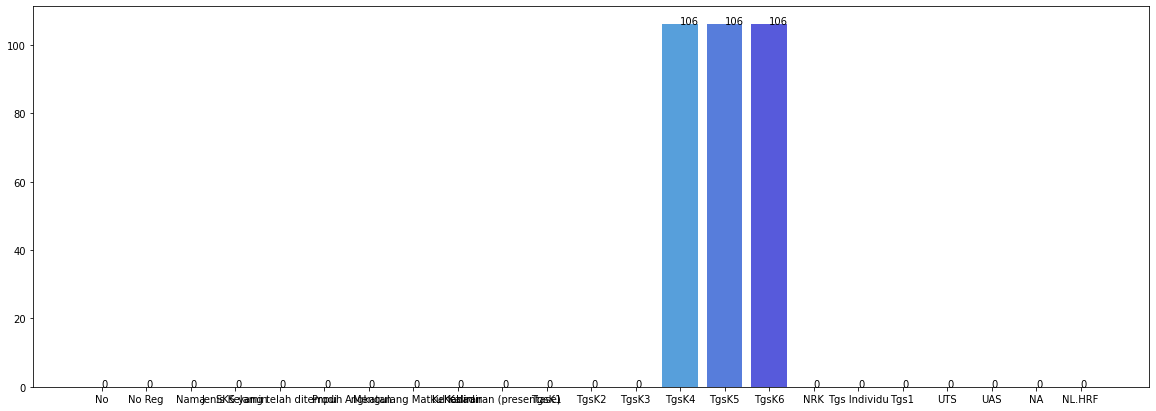

In [ ]:
show_horizontal_bar(null_cols[0], null_cols[1])

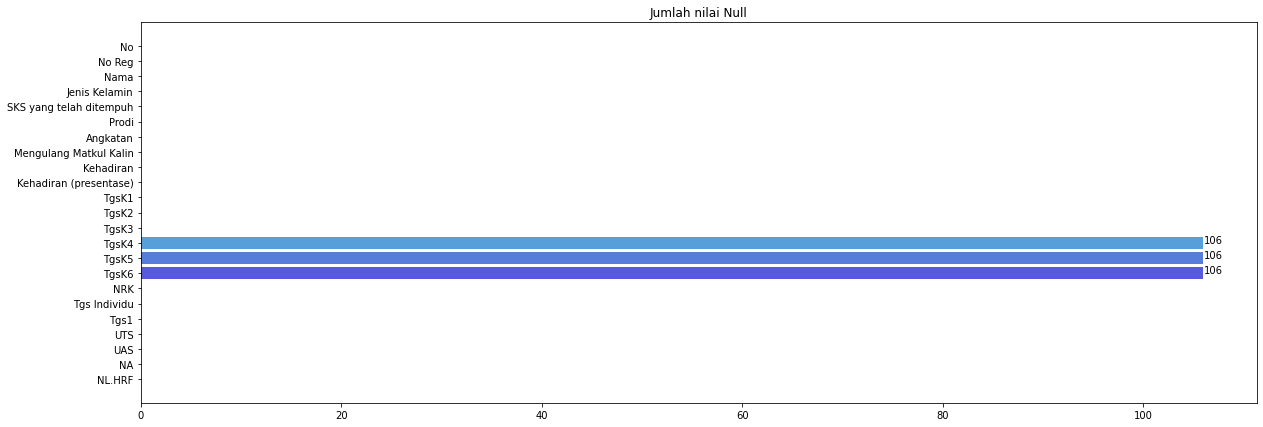

In [ ]:
show_vertical_bar(null_cols[0], null_cols[1], title="Jumlah nilai Null")

In [ ]:
graduate = df.apply(score_to_graduate, axis=1)

In [ ]:
graduate

0            Lulus
1            Lulus
2      Tidak Lulus
3            Lulus
4            Lulus
          ...     
183          Lulus
184          Lulus
185          Lulus
186          Lulus
187          Lulus
Length: 188, dtype: object

In [ ]:
count_graduate = [graduate[graduate=='Lulus'].count(), graduate[graduate=='Tidak Lulus'].count()]

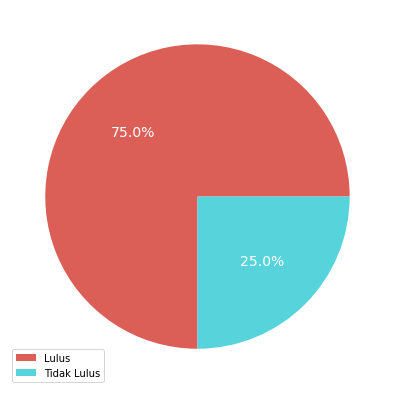

In [ ]:
show_pie_chart(count_graduate, ["Lulus", "Tidak Lulus"])

In [ ]:
score_list = ['A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D', 'E']
count_score = []

for i in range(len(score_list)):
  count_score.append(df[df["NL.HRF"] == score_list[i]]["NL.HRF"].count())

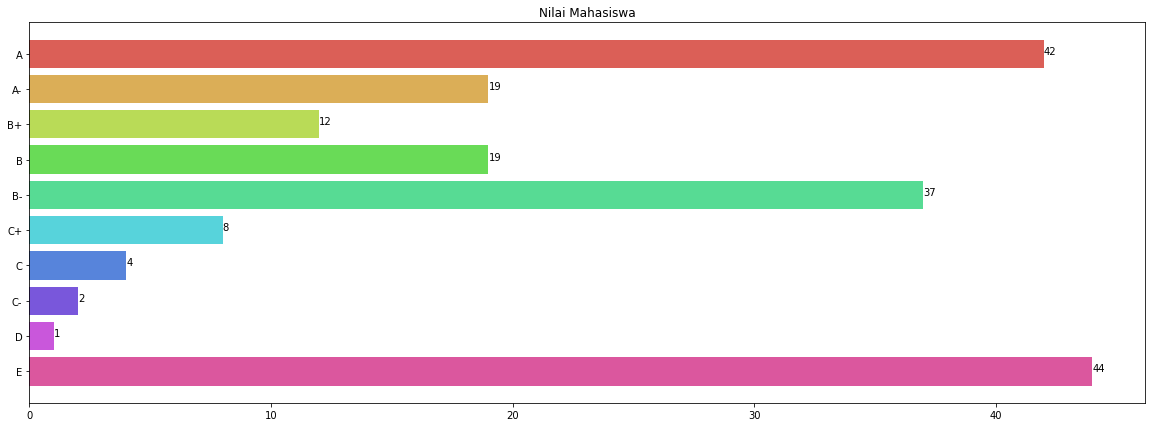

In [ ]:
show_vertical_bar(score_list, count_score, title="Nilai Mahasiswa")

In [ ]:
predicate_list = ["Sangat Baik", "Baik", "Cukup", "Tidak Lulus"]
pred = df.apply(score_to_predicate, axis=1)
count_pred = []

for i in predicate_list:
  count_pred.append(pred.value_counts()[i])

count_pred

[61, 68, 12, 47]

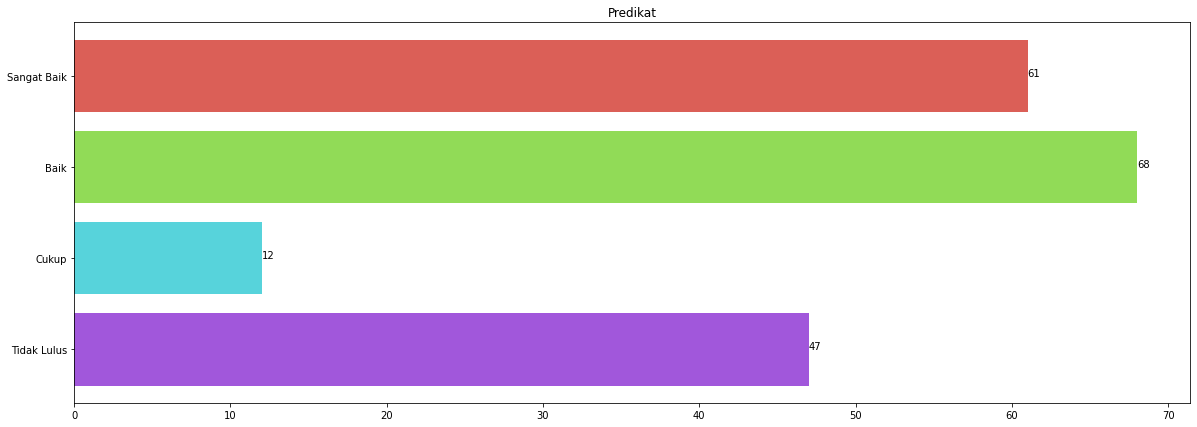

In [ ]:
show_vertical_bar(predicate_list, count_pred, title="Predikat")

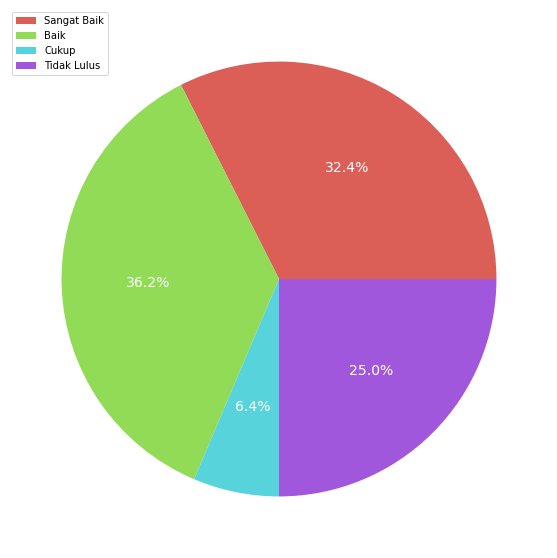

In [ ]:
# show_pie_chart(count_score, score_list, figsize=(20, 20))
show_pie_chart(count_pred, predicate_list, figsize=(10, 10))

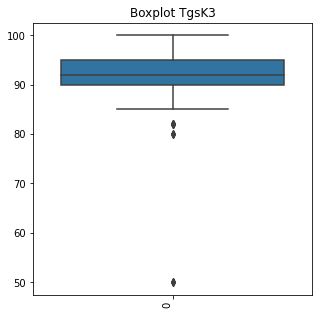

In [ ]:
show_boxplot(num_df['TgsK3'], title="Boxplot TgsK3", figsize=(5, 5))

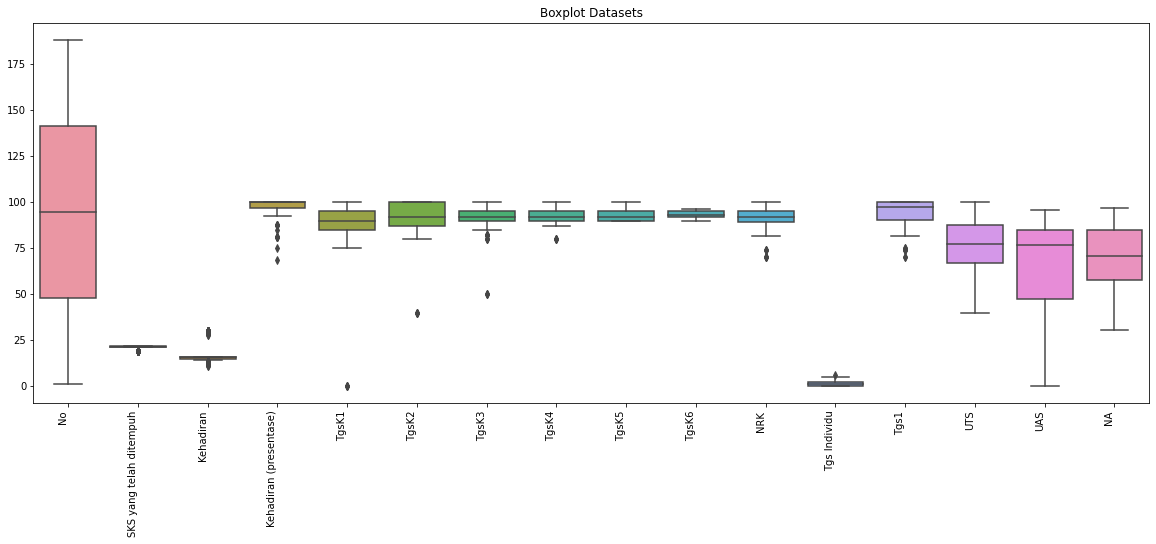

In [ ]:
show_boxplot(num_df, title="Boxplot Datasets")

In [ ]:
def show_kde(num_dataframe):
  for (columnName, columnData) in num_dataframe.iteritems():
    sns.histplot(columnData, kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4))
    plt.title(columnName)
    plt.show()

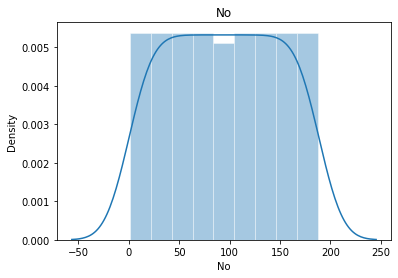

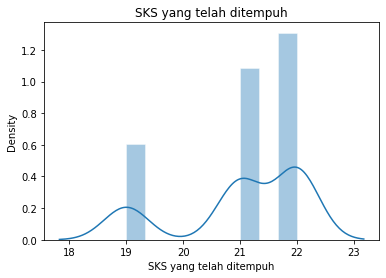

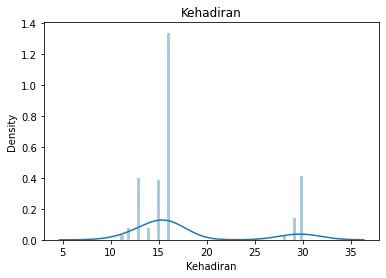

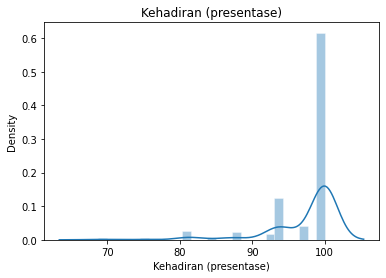

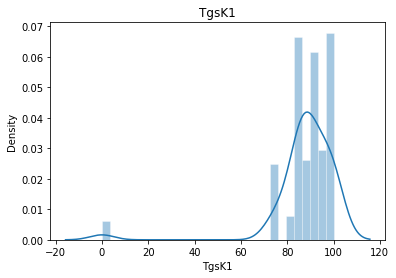

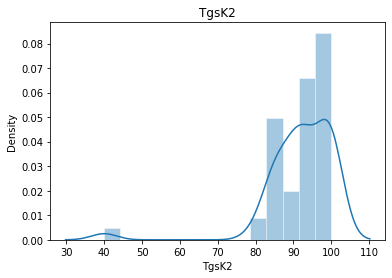

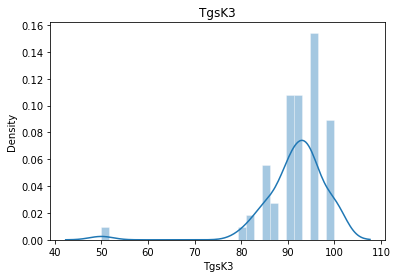

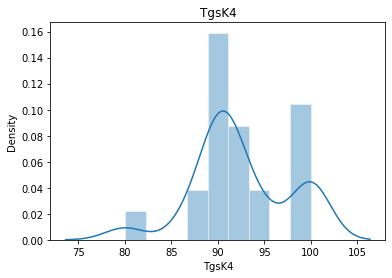

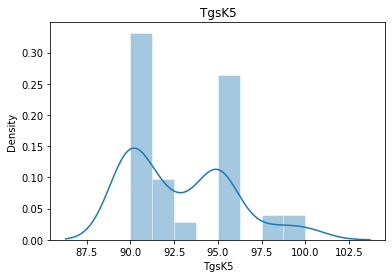

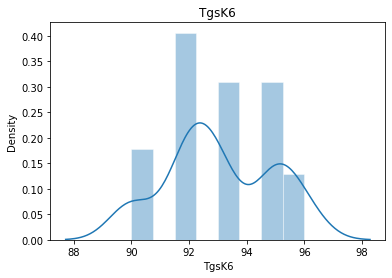

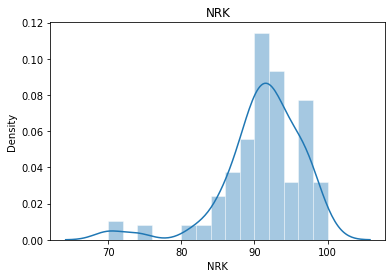

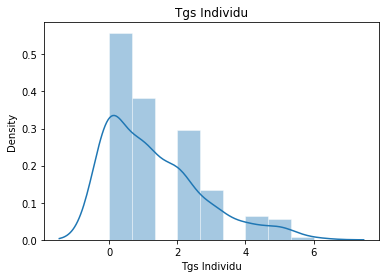

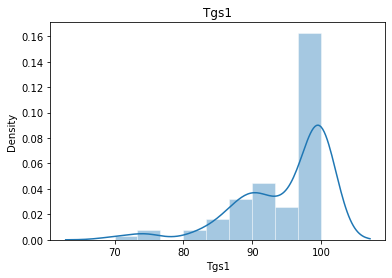

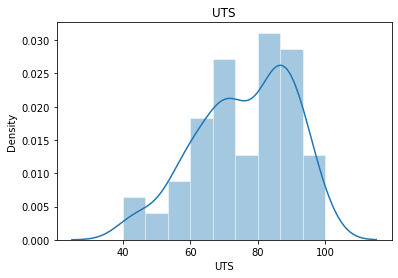

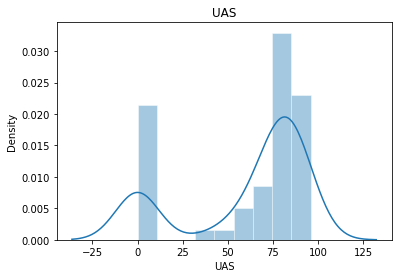

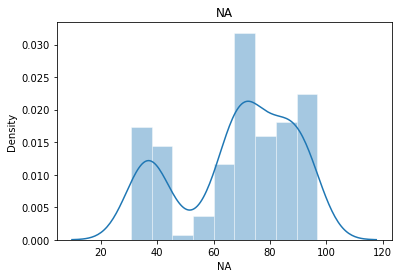

In [ ]:
show_kde(num_df)

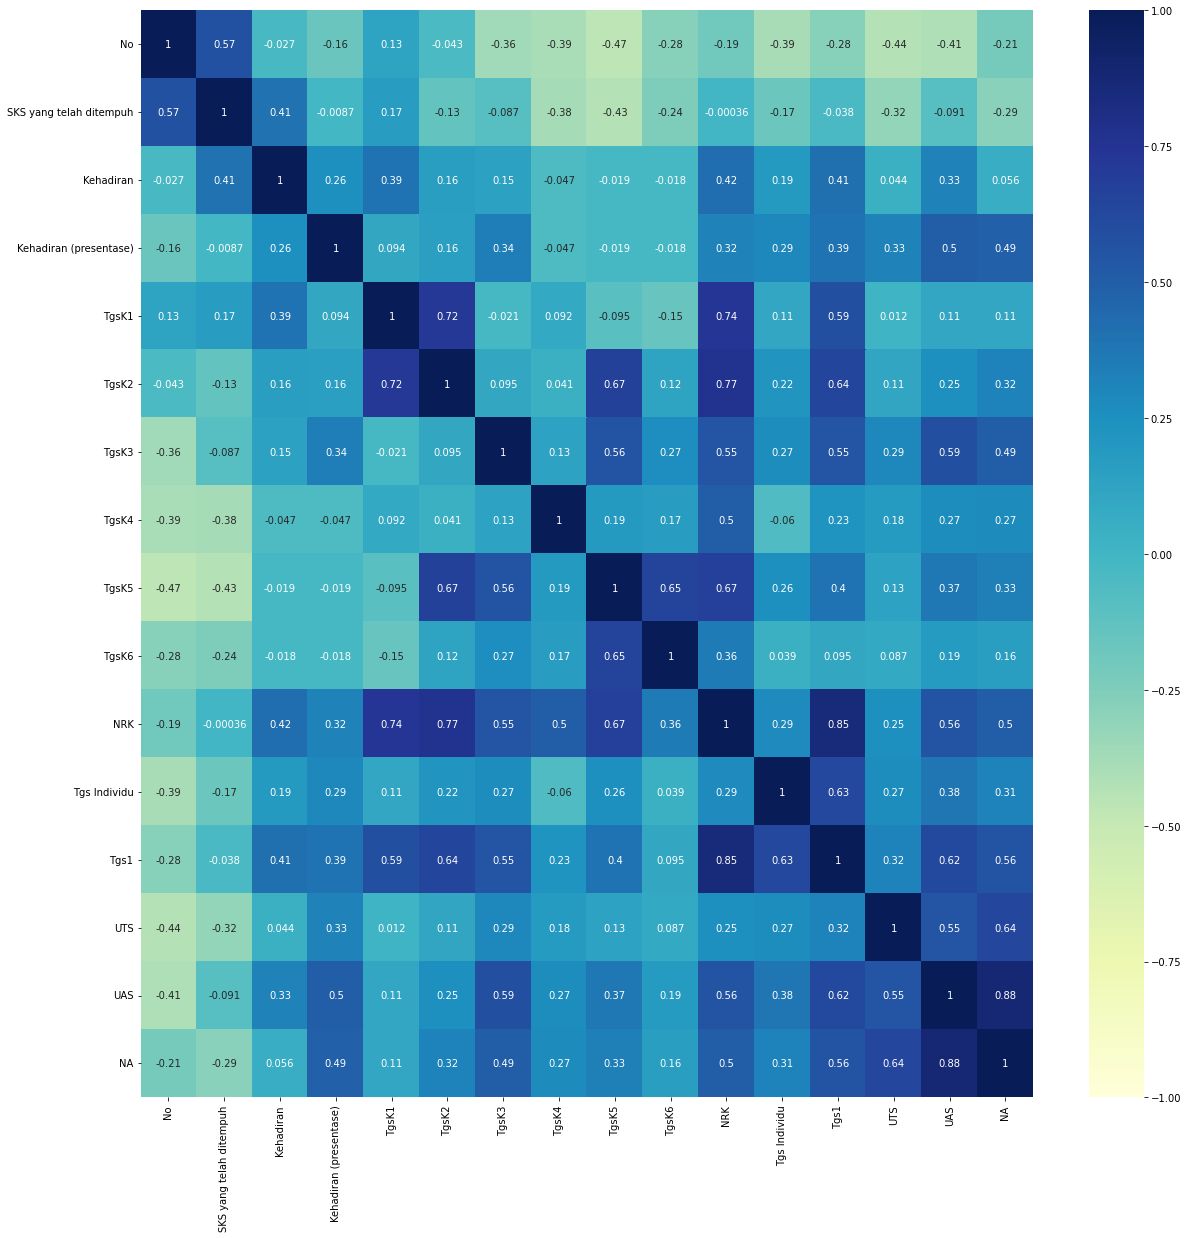

In [ ]:
show_correlation(df)

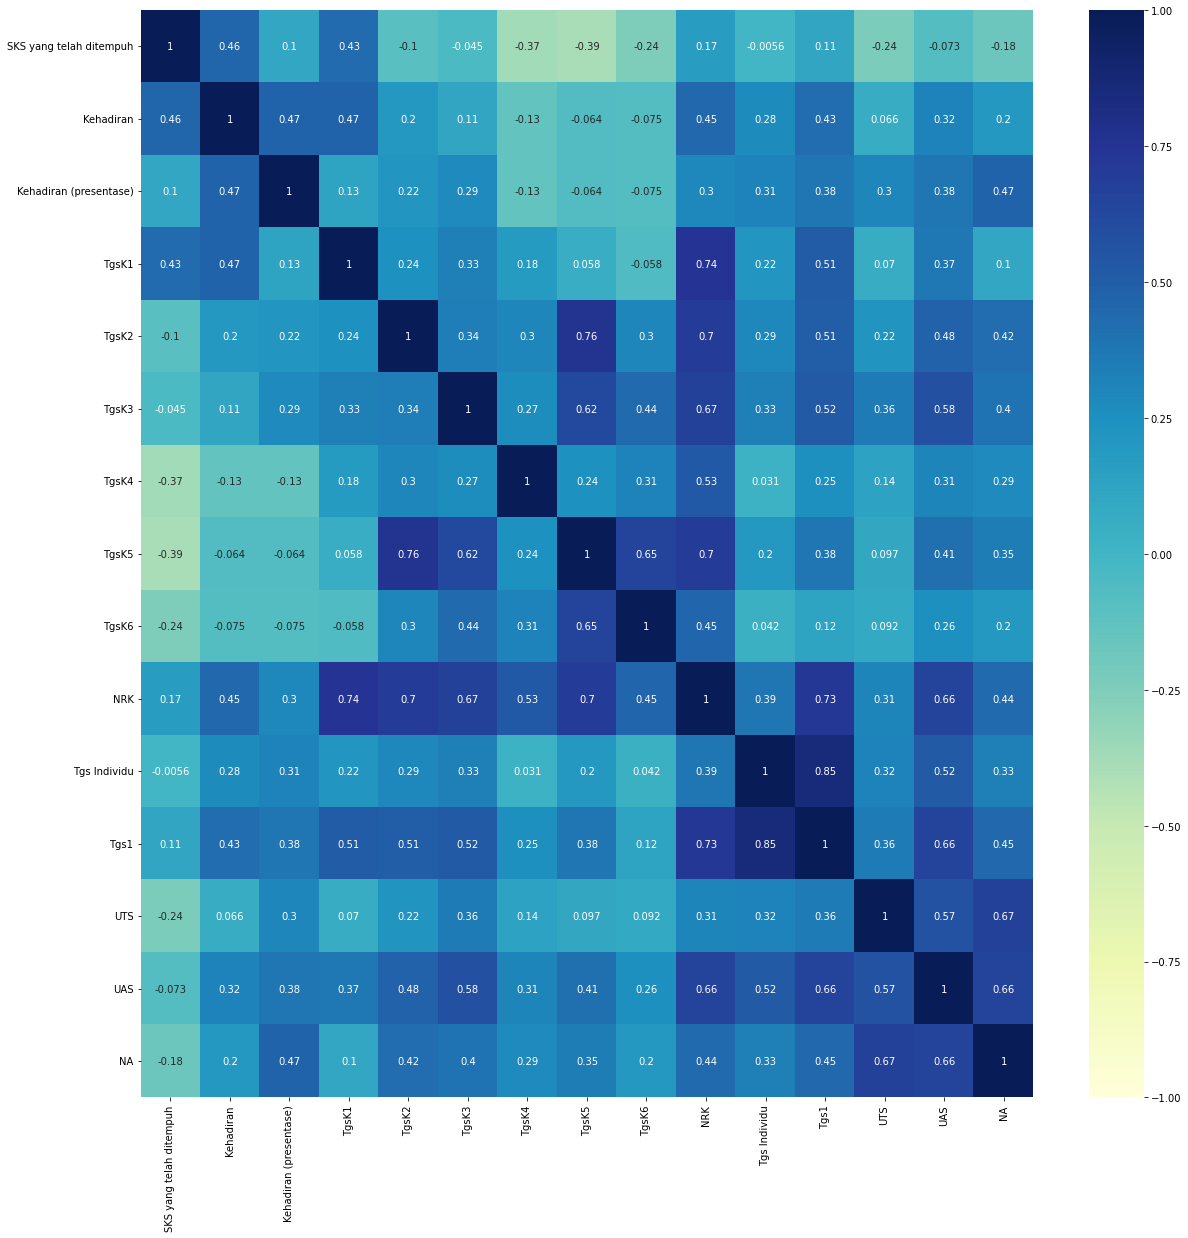

In [ ]:
df_corr = df.drop(['No', 'No Reg', 'Nama'], axis=1)
show_correlation(df_corr, corr='spearman')

# Preprocessing

## Section 1/Drop Columns
Pada section ini akan dilakukan pemilahan kolom data yang akan digunkanan nantinya untuk pembangunan model. Pemilihan yang dilakukan akan membuang kolom yang dianggap tidak penting.
<br>
Selain pemilihan akan dilakukan juga penamaan ulang pada nama kolom yang panjang untuk diubah menjadi lebih singkat.

Mengambil data yang kemungkinan diperlukan

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   No                       188 non-null    int64  
 1   No Reg                   188 non-null    object 
 2   Nama                     188 non-null    object 
 3   Jenis Kelamin            188 non-null    object 
 4   SKS yang telah ditempuh  188 non-null    int64  
 5   Prodi                    188 non-null    object 
 6   Angkatan                 188 non-null    object 
 7   Mengulang Matkul Kalin   188 non-null    object 
 8   Kehadiran                188 non-null    int64  
 9   Kehadiran (presentase)   188 non-null    float64
 10  TgsK1                    188 non-null    int64  
 11  TgsK2                    188 non-null    int64  
 12  TgsK3                    188 non-null    int64  
 13  TgsK4                    82 non-null     float64
 14  TgsK5                    8

In [ ]:
not_used_cols = ["No", "No Reg", "Nama", "Kehadiran", "NRK", "NA", "Mengulang Matkul Kalin"]

Alasan kenapa kolom-kolom berikut di drop atau dibuang dari dataset


1.   Kolom "No." => mempresentasikan nomor urut (tidak digunakan) 
2.   Kolom "No. Reg" => mempresentasikan id mahasiswa (tidak digunakan)
3. Kolom "Nama" => mempresentasikan nama mahasiswa (tidak digunakan)
4. Kolom "Kehadiran" => mempresentasiakn jumlah kehadiran mahasiswa (dibuang karena ada juga kolom yang mempresentasikan kehadiran mahasiswa dalam bentuk presentase)
5. Kolom "NA" => mempresentasikan nilai akhir (dibuang karena sudah ada kolom nilai huruf sebagai representasi nilai akhir dan sebagai target)
6. Kolom "Mengulang Matkul Kalin" => mempresentasikan apakah mahasiswa tsb pernah mengulang atau tidak (di buang karena isi dari kolom tersebut hanya 1 yaitu "Tidak" semua



In [ ]:
dataset = df.drop(not_used_cols, axis=1, inplace=False)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Jenis Kelamin            188 non-null    object 
 1   SKS yang telah ditempuh  188 non-null    int64  
 2   Prodi                    188 non-null    object 
 3   Angkatan                 188 non-null    object 
 4   Kehadiran (presentase)   188 non-null    float64
 5   TgsK1                    188 non-null    int64  
 6   TgsK2                    188 non-null    int64  
 7   TgsK3                    188 non-null    int64  
 8   TgsK4                    82 non-null     float64
 9   TgsK5                    82 non-null     float64
 10  TgsK6                    82 non-null     float64
 11  Tgs Individu             188 non-null    int64  
 12  Tgs1                     188 non-null    float64
 13  UTS                      188 non-null    float64
 14  UAS                      1

In [ ]:
dataset.head()

,Jenis Kelamin,SKS yang telah ditempuh,Prodi,Angkatan,Kehadiran (presentase),TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,Tgs Individu,Tgs1,UTS,UAS,NL.HRF
0,L,21,Ilmu Komputer,2019,100.000000,75,98,95,NaN,NaN,NaN,2,99.333333,95.0,76.785714,B
1,L,21,Ilmu Komputer,2019,92.307692,100,85,95,NaN,NaN,NaN,3,100.000000,87.5,81.964286,B-
2,L,21,Ilmu Komputer,2019,100.000000,85,85,100,NaN,NaN,NaN,5,100.000000,45.0,38.392857,E
3,P,21,Ilmu Komputer,2019,100.000000,100,100,100,NaN,NaN,NaN,2,100.000000,95.0,90.059524,B
4,L,21,Ilmu Komputer,2019,100.000000,80,100,100,NaN,NaN,NaN,1,98.333333,90.0,78.630952,B-


Mengubah beberapa nama kolom menjadi lebih singkat



In [ ]:
dataset.rename(columns={"Jenis Kelamin": "JK", "SKS yang telah ditempuh": "SKS", "Kehadiran (presentase)": "Kehadiran", "Tgs Individu": "TgsIdv"}, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   JK         188 non-null    object 
 1   SKS        188 non-null    int64  
 2   Prodi      188 non-null    object 
 3   Angkatan   188 non-null    object 
 4   Kehadiran  188 non-null    float64
 5   TgsK1      188 non-null    int64  
 6   TgsK2      188 non-null    int64  
 7   TgsK3      188 non-null    int64  
 8   TgsK4      82 non-null     float64
 9   TgsK5      82 non-null     float64
 10  TgsK6      82 non-null     float64
 11  TgsIdv     188 non-null    int64  
 12  Tgs1       188 non-null    float64
 13  UTS        188 non-null    float64
 14  UAS        188 non-null    float64
 15  NL.HRF     188 non-null    object 
dtypes: float64(7), int64(5), object(4)
memory usage: 23.6+ KB


## Section 2/transform columns NL.HRF to Predicate

In [ ]:
dataset['predicate'] = dataset.apply(score_to_predicate, axis=1)

In [ ]:
dataset.head()

,JK,SKS,Prodi,Angkatan,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,NL.HRF,predicate
0,L,21,Ilmu Komputer,2019,100.000000,75,98,95,NaN,NaN,NaN,2,99.333333,95.0,76.785714,B,Baik
1,L,21,Ilmu Komputer,2019,92.307692,100,85,95,NaN,NaN,NaN,3,100.000000,87.5,81.964286,B-,Baik
2,L,21,Ilmu Komputer,2019,100.000000,85,85,100,NaN,NaN,NaN,5,100.000000,45.0,38.392857,E,Tidak Lulus
3,P,21,Ilmu Komputer,2019,100.000000,100,100,100,NaN,NaN,NaN,2,100.000000,95.0,90.059524,B,Baik
4,L,21,Ilmu Komputer,2019,100.000000,80,100,100,NaN,NaN,NaN,1,98.333333,90.0,78.630952,B-,Baik


In [ ]:
dataset.drop(["NL.HRF"], axis=1, inplace=True)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   JK         188 non-null    object 
 1   SKS        188 non-null    int64  
 2   Prodi      188 non-null    object 
 3   Angkatan   188 non-null    object 
 4   Kehadiran  188 non-null    float64
 5   TgsK1      188 non-null    int64  
 6   TgsK2      188 non-null    int64  
 7   TgsK3      188 non-null    int64  
 8   TgsK4      82 non-null     float64
 9   TgsK5      82 non-null     float64
 10  TgsK6      82 non-null     float64
 11  TgsIdv     188 non-null    int64  
 12  Tgs1       188 non-null    float64
 13  UTS        188 non-null    float64
 14  UAS        188 non-null    float64
 15  predicate  188 non-null    object 
dtypes: float64(7), int64(5), object(4)
memory usage: 23.6+ KB


## Section 3/ Handle Null and outliers
Pada section ini akan dilakukan penelusuran nilai null dan nilai outlier yang ada pada dataset

### Handle Null

In [ ]:
find_null(dataset)

{'TgsK4': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143]),
 'TgsK5': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  63,
         64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
         77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
         90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 

In [ ]:
dataset = handle_nulls(dataset, "special")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   JK         188 non-null    object 
 1   SKS        188 non-null    int64  
 2   Prodi      188 non-null    object 
 3   Angkatan   188 non-null    object 
 4   Kehadiran  188 non-null    float64
 5   TgsK1      188 non-null    int64  
 6   TgsK2      188 non-null    int64  
 7   TgsK3      188 non-null    int64  
 8   TgsK4      188 non-null    float64
 9   TgsK5      188 non-null    float64
 10  TgsK6      188 non-null    float64
 11  TgsIdv     188 non-null    int64  
 12  Tgs1       188 non-null    float64
 13  UTS        188 non-null    float64
 14  UAS        188 non-null    float64
 15  predicate  188 non-null    object 
dtypes: float64(7), int64(5), object(4)
memory usage: 23.6+ KB


### Handle Outliers

In [ ]:
outliers_loc = get_outliers_loc(dataset)
outliers_loc

({'TgsIdv': array([  2,  25,  31,  44,  45, 122, 125, 133])},
 {'SKS': array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
         42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
         59, 60, 61, 62]),
  'Kehadiran': array([ 17, 109, 112, 118, 121, 123, 129, 132, 137, 138, 140, 141, 142,
         174]),
  'TgsK1': array([21, 22, 23, 24]),
  'TgsK2': array([21, 22, 23, 24]),
  'TgsK3': array([101, 102, 107, 110, 118, 120, 129, 131, 135, 136, 137, 139]),
  'TgsK4': array([ 21,  22,  23,  24, 110, 120, 129]),
  'TgsK5': array([ 21,  22,  23,  24, 110, 120, 129]),
  'TgsK6': array([ 21,  22,  23,  24, 110, 120, 129]),
  'Tgs1': array([ 21,  22,  23,  24, 110, 120, 129])})

In [ ]:
get_ouliers_val(dataset)

({'TgsIdv': array([5, 5, 5, 5, 6, 5, 5, 5])},
 {'SKS': array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
         19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
         19, 19, 19, 19]),
  'Kehadiran': array([84.61538462, 81.25      , 87.5       , 87.5       , 87.5       ,
         87.5       , 81.25      , 87.5       , 81.25      , 81.25      ,
         81.25      , 68.75      , 81.25      , 75.        ]),
  'TgsK1': array([0, 0, 0, 0]),
  'TgsK2': array([40, 40, 40, 40]),
  'TgsK3': array([82, 80, 80, 50, 82, 50, 50, 82, 80, 82, 82, 82]),
  'TgsK4': array([46.66666667, 46.66666667, 46.66666667, 46.66666667, 74.        ,
         74.        , 74.        ]),
  'TgsK5': array([46.66666667, 46.66666667, 46.66666667, 46.66666667, 74.        ,
         74.        , 74.        ]),
  'TgsK6': array([46.66666667, 46.66666667, 46.66666667, 46.66666667, 74.        ,
         74.        , 74.        ]),
  'Tgs1': array([75., 70., 75., 70., 74., 74.,

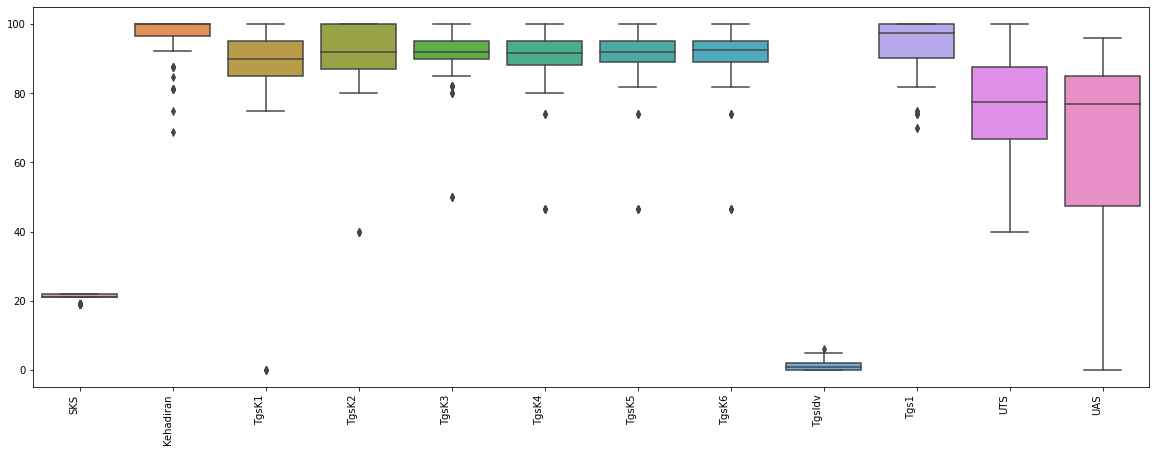

In [ ]:
show_boxplot(dataset.select_dtypes(include="number"))

In [ ]:
def handle_outliers(dataframe, strategy="mean"):
  dataframe = dataframe.copy()
  df_val = dataframe.select_dtypes(include="number")
  upper_loc, lower_loc = get_outliers_loc(dataframe)
  # Get all outlier index
  out_idx = {}
  for i in upper_loc:
    out_idx[i] = upper_loc[i]
  for j in lower_loc:
    if j not in out_idx:
      out_idx[j] = lower_loc[j]
    else:
      val = out_idx[j]
      val.append(lower_loc[j])
      out_idx[j] = val
  
  # get new value
  new_val_df = None
  if strategy == 'mean':
    new_val_df = df_val.mean()
  elif strategy == 'mode':
    new_val_df = df_val.mode().iloc[0]
  elif strategy == 'median':
    new_val_df = df_val.median()
  else:
    raise Exception("error")

  # replace all outlier with new value
  for key in out_idx:
    for idx in out_idx[key]:
      dataframe.at[idx, key] = new_val_df[key]
  return dataframe

In [ ]:
dataset = handle_outliers(dataset, "median")

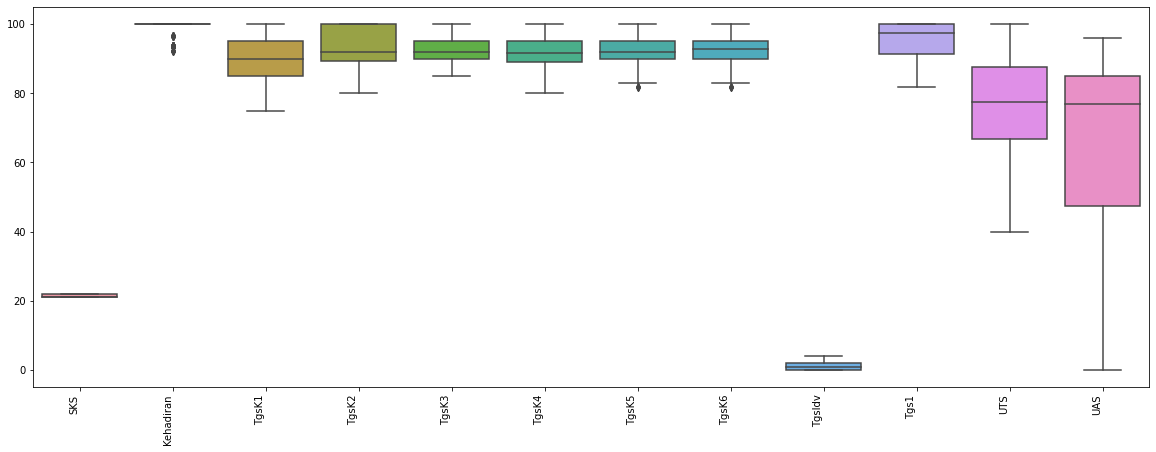

In [ ]:
show_boxplot(dataset.select_dtypes(include="number"))

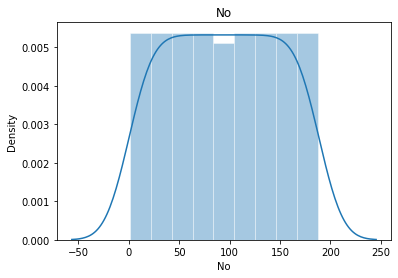

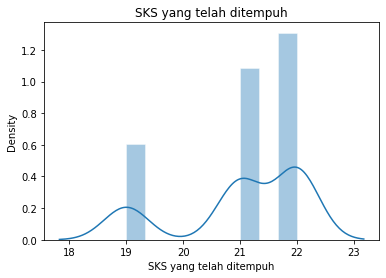

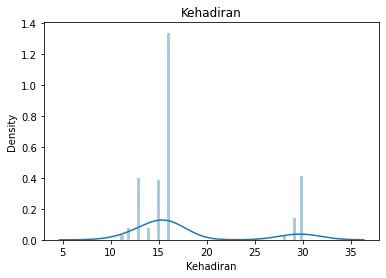

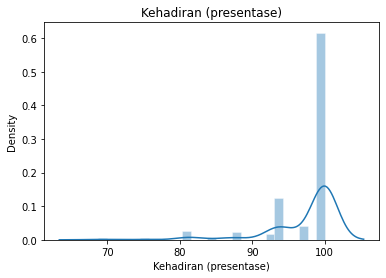

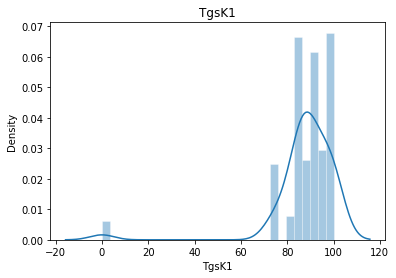

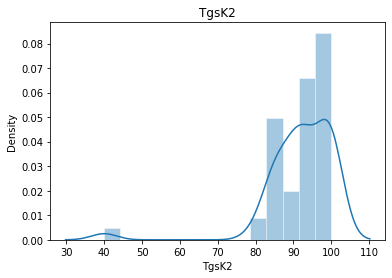

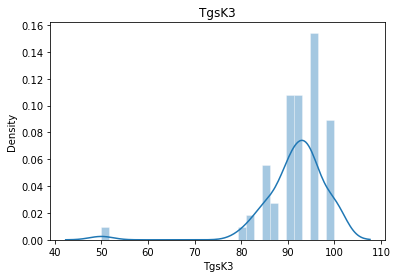

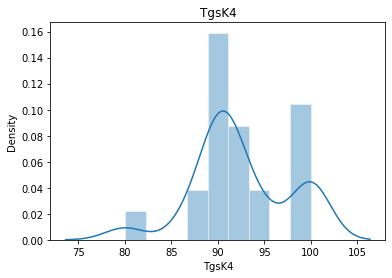

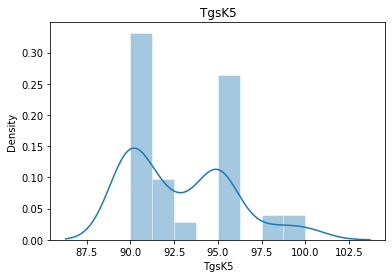

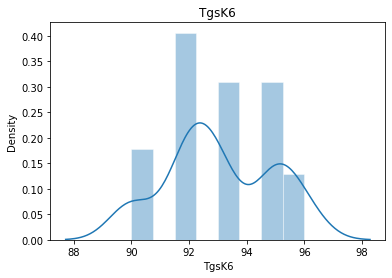

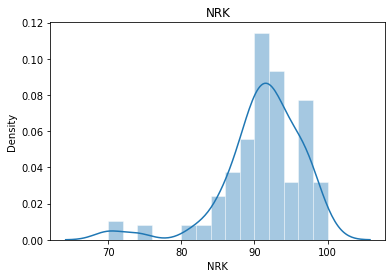

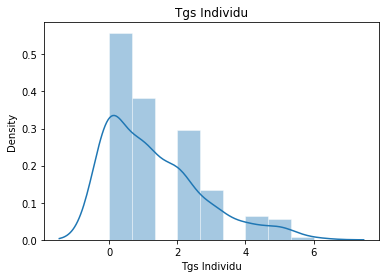

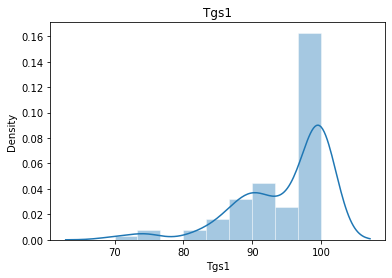

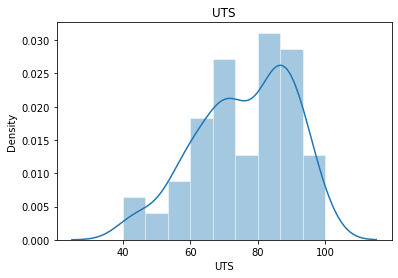

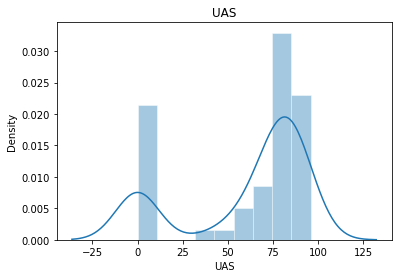

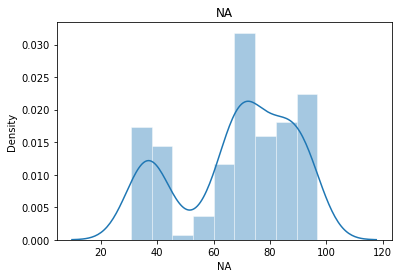

In [ ]:
show_kde(num_df)

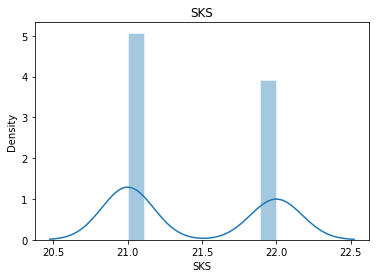

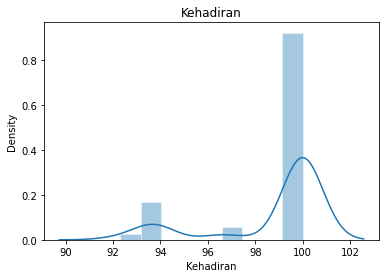

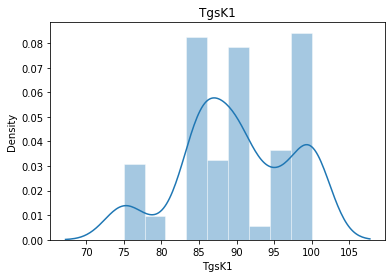

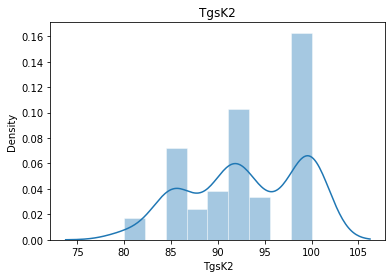

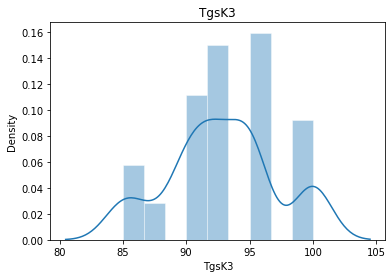

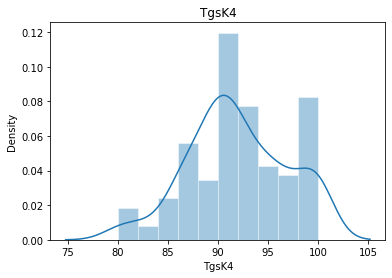

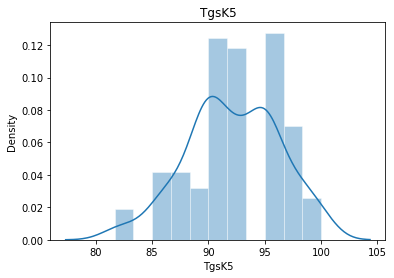

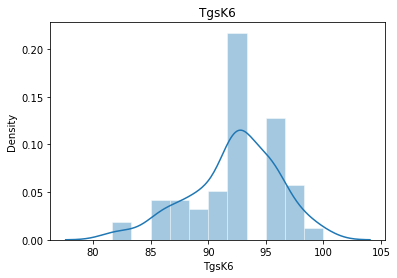

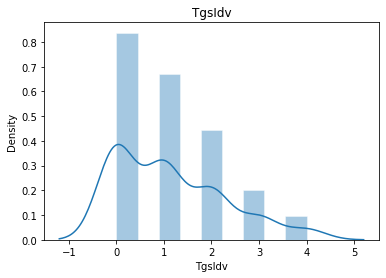

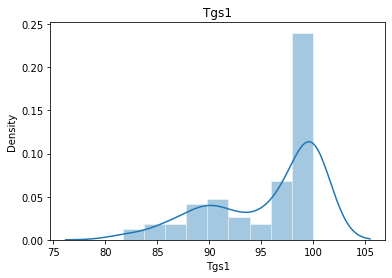

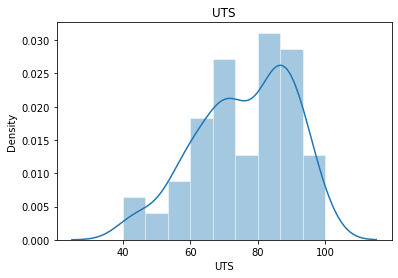

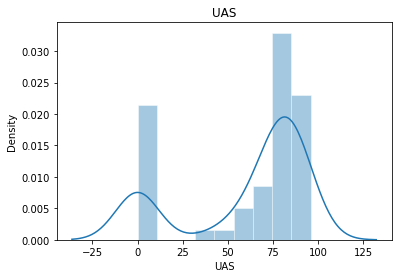

In [ ]:
show_kde(dataset.select_dtypes(include="number"))

In [ ]:
# from scipy import stats
# new_tmp = stats.boxcox(tmp_f, lmbda=None)[0]
# show_boxplot(new_tmp)
# sns.histplot(new_tmp, kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4),)

In [ ]:
# for val in tmp_f_new:
#   for idx in ls_out_loc:
#     tmp_f[idx] = val
#   sns.boxplot(data=tmp_f)
#   plt.show()
#   sns.histplot(tmp_f, kde=True, stat="density", kde_kws=dict(cut=3), alpha=.4, edgecolor=(1, 1, 1, .4),)
#   plt.show()

## Section 4/Split Data
Split Data


1.   Split data X dan data y
2.   Split data latih dan data test
3. split data numerikal dan kategorikal pada X



In [ ]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

In [ ]:
X

,JK,SKS,Prodi,Angkatan,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS
0,L,21,Ilmu Komputer,2019,100.000000,75,98,95,89.333333,89.333333,89.333333,2,99.333333,95.0,76.785714
1,L,21,Ilmu Komputer,2019,92.307692,100,85,95,93.333333,93.333333,93.333333,3,100.000000,87.5,81.964286
2,L,21,Ilmu Komputer,2019,100.000000,85,85,100,90.000000,90.000000,90.000000,1,100.000000,45.0,38.392857
3,P,21,Ilmu Komputer,2019,100.000000,100,100,100,100.000000,100.000000,100.000000,2,100.000000,95.0,90.059524
4,L,21,Ilmu Komputer,2019,100.000000,80,100,100,93.333333,93.333333,93.333333,1,98.333333,90.0,78.630952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,L,22,Pend Mat,2020,100.000000,87,90,92,87.000000,90.000000,92.000000,0,89.666667,75.0,55.000000
184,P,22,Pend Mat,2020,100.000000,87,92,90,90.000000,90.000000,92.000000,2,100.000000,70.0,60.000000
185,P,22,Pend Mat,2020,93.750000,90,95,93,92.000000,92.000000,93.000000,0,92.500000,42.5,70.000000
186,P,22,Pend Mat,2020,100.000000,90,92,92,92.000000,90.000000,93.000000,1,96.500000,50.0,47.500000


In [ ]:
y

0             Baik
1             Baik
2      Tidak Lulus
3             Baik
4             Baik
          ...     
183           Baik
184           Baik
185           Baik
186           Baik
187           Baik
Name: predicate, Length: 188, dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [ ]:
print(X_train.shape, X_test.shape)

(131, 15) (57, 15)


In [ ]:
print(y_train.shape, y_test.shape)

(131,) (57,)


split kolom numerikal dan kategorikal

In [ ]:
X_train_num = X_train.select_dtypes(include="number")
X_train_cat = X_train.select_dtypes(exclude="number")

In [ ]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 69 to 37
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SKS        131 non-null    int64  
 1   Kehadiran  131 non-null    float64
 2   TgsK1      131 non-null    int64  
 3   TgsK2      131 non-null    int64  
 4   TgsK3      131 non-null    int64  
 5   TgsK4      131 non-null    float64
 6   TgsK5      131 non-null    float64
 7   TgsK6      131 non-null    float64
 8   TgsIdv     131 non-null    int64  
 9   Tgs1       131 non-null    float64
 10  UTS        131 non-null    float64
 11  UAS        131 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 13.3 KB


In [ ]:
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 69 to 37
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   JK        131 non-null    object
 1   Prodi     131 non-null    object
 2   Angkatan  131 non-null    object
dtypes: object(3)
memory usage: 4.1+ KB


In [ ]:
X_test_num = X_test.select_dtypes(include="number")
X_test_cat = X_test.select_dtypes(exclude="number")

In [ ]:
X_test_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 31 to 164
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SKS        57 non-null     int64  
 1   Kehadiran  57 non-null     float64
 2   TgsK1      57 non-null     int64  
 3   TgsK2      57 non-null     int64  
 4   TgsK3      57 non-null     int64  
 5   TgsK4      57 non-null     float64
 6   TgsK5      57 non-null     float64
 7   TgsK6      57 non-null     float64
 8   TgsIdv     57 non-null     int64  
 9   Tgs1       57 non-null     float64
 10  UTS        57 non-null     float64
 11  UAS        57 non-null     float64
dtypes: float64(7), int64(5)
memory usage: 5.8 KB


In [ ]:
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 31 to 164
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   JK        57 non-null     object
 1   Prodi     57 non-null     object
 2   Angkatan  57 non-null     object
dtypes: object(3)
memory usage: 1.8+ KB


## Section 5/Encoding & Normalization
Pada section ini akan dilakukan tahap encoding pada kolom kategorikal dan tahap normalisasi pada kolom numerikal

### Encoding

In [ ]:
X_train_cat

,JK,Prodi,Angkatan
69,P,Matematika,2019
54,P,Pend Mat,2019
108,P,Ilmu Komputer,2020
117,L,Ilmu Komputer,2020
39,P,Pend Mat,2019
...,...,...,...
133,L,Ilmu Komputer,2020
137,L,Ilmu Komputer,2020
72,P,Matematika,2019
140,L,Ilmu Komputer,2020


In [ ]:
enc = OneHotEncoder(sparse=False, handle_unknown="ignore")
enc.fit(X_train_cat)

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
enc.categories_

[array(['L', 'P'], dtype=object),
 array(['Ilmu Komputer', 'Matematika', 'Pend Mat'], dtype=object),
 array([2019, 2020], dtype=object)]

In [ ]:
X_train_cat_new = enc.transform(X_train_cat)

In [ ]:
X_train_cat_new

array([[0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 1., 0., 0., 1., 0.],
       [1., 0., 1., 0., 0., 0., 1.],
       [1., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 1., 0.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1., 0., 1.],
 

In [ ]:
X_test_cat_new = enc.transform(X_test_cat)

In [ ]:
X_test_cat_new.shape

(57, 7)

### Normalisasi

In [ ]:
# X_test_num.shape

In [ ]:
# norm = MinMaxScaler()
norm = StandardScaler()

In [ ]:
X_train_num_new = norm.fit_transform(X_train_num)

In [ ]:
X_test_num_new = norm.transform(X_test_num)

In [ ]:
X_train_num_new

array([[ 1.10468954,  0.49138672,  1.4346169 , ...,  0.84595584,
         0.11312122,  0.68470893],
       [-0.90523171,  0.49138672,  1.4346169 , ...,  0.84595584,
         1.13511293,  0.74878016],
       [-0.90523171,  0.49138672, -0.73053072, ..., -1.62393752,
        -0.39787464, -1.75316023],
       ...,
       [ 1.10468954, -0.87153117,  0.71290102, ...,  0.84595584,
         0.62411708,  0.42462332],
       [-0.90523171,  0.49138672, -0.44184437, ..., -0.8439712 ,
        -0.39787464, -1.75316023],
       [-0.90523171,  0.49138672, -0.73053072, ...,  0.84595584,
         1.13511293,  0.80791322]])

In [ ]:
X_test_num_new

array([[-9.05231708e-01,  4.91386723e-01,  7.12901024e-01,
         1.23272382e+00,  5.18934331e-01, -2.53414585e+00,
         7.33457951e-01,  7.72803522e-01, -1.06576707e-01,
         8.45955844e-01,  1.30544489e+00,  1.00016851e+00],
       [ 1.10468954e+00,  4.91386723e-01,  1.43461690e+00,
        -1.33055904e+00,  5.18934331e-01,  2.83364070e-01,
         3.09811604e-01,  3.13052108e-01,  7.66020078e-01,
         8.45955844e-01,  6.24117077e-01,  9.53464067e-01],
       [-9.05231708e-01,  4.91386723e-01, -8.81485037e-03,
        -1.34360374e-01, -1.74743193e-01, -1.39262418e-01,
        -1.98564013e-01, -2.38649589e-01, -1.06576707e-01,
         1.30986711e-01, -2.27542684e-01, -1.75316023e+00],
       [-9.05231708e-01, -2.06408434e+00, -7.30530724e-01,
        -9.88787993e-01, -1.74743193e-01, -1.04043544e-01,
        -2.91054743e-02,  8.31764009e-02, -9.79173491e-01,
         3.42227591e-01, -5.68206589e-01, -1.75316023e+00],
       [ 1.10468954e+00,  4.91386723e-01,  7.1290102

### Label Encoding
Ordinal / Label Encoder

In [ ]:
le = LabelEncoder()

In [ ]:
y_train = le.fit_transform(y_train)

In [ ]:
le.classes_

array(['Baik', 'Cukup', 'Sangat Baik', 'Tidak Lulus'], dtype=object)

In [ ]:
y_test = le.transform(y_test)

In [ ]:
y_train

array([0, 2, 3, 3, 2, 2, 2, 0, 3, 2, 2, 0, 3, 0, 1, 0, 3, 3, 0, 3, 2, 2,
       2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 0, 3, 0, 0, 2, 0, 0, 0,
       0, 2, 3, 0, 3, 2, 2, 1, 1, 2, 2, 0, 0, 3, 3, 0, 2, 2, 2, 2, 0, 0,
       0, 2, 0, 3, 1, 3, 0, 0, 3, 0, 3, 2, 0, 0, 2, 2, 3, 1, 2, 2, 0, 2,
       1, 0, 2, 2, 3, 2, 2, 3, 3, 2, 0, 2, 3, 0, 2, 1, 2, 0, 0, 0, 3, 0,
       0, 0, 2, 3, 2, 0, 3, 2, 3, 1, 2, 3, 1, 3, 2, 0, 3, 3, 0, 3, 2])

In [ ]:
y_test

array([2, 0, 3, 3, 0, 0, 2, 3, 0, 0, 3, 0, 0, 2, 3, 3, 3, 2, 0, 2, 2, 0,
       2, 2, 2, 2, 0, 3, 2, 2, 1, 3, 0, 1, 0, 1, 3, 0, 2, 0, 2, 0, 3, 2,
       0, 2, 0, 0, 3, 2, 0, 0, 3, 2, 3, 0, 2])

## Section 6/Join back split cat & num
Pada section ini akan digabungkan kembali data X katgorikal dan numerikal yang telah melalui proses encoding dan normalisasi

In [ ]:
X_train_cat_new[0]

array([0., 1., 0., 1., 0., 1., 0.])

In [ ]:
X_train_num_new[0]

array([ 1.10468954,  0.49138672,  1.4346169 , -1.33055904,  0.51893433,
        0.28336407,  0.3098116 ,  0.31305211,  1.63861686,  0.84595584,
        0.11312122,  0.68470893])

In [ ]:
X_train_join = np.concatenate((X_train_cat_new, X_train_num_new), axis=1)

In [ ]:
X_test_join = np.concatenate((X_test_cat_new, X_test_num_new), axis=1)

In [ ]:
X_train_join[0]

array([ 0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.10468954,  0.49138672,  1.4346169 ,
       -1.33055904,  0.51893433,  0.28336407,  0.3098116 ,  0.31305211,
        1.63861686,  0.84595584,  0.11312122,  0.68470893])

In [ ]:
X_test_join[0]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        1.        ,  0.        , -0.90523171,  0.49138672,  0.71290102,
        1.23272382,  0.51893433, -2.53414585,  0.73345795,  0.77280352,
       -0.10657671,  0.84595584,  1.30544489,  1.00016851])

In [ ]:
y_train.shape

(131,)

In [ ]:
y_test.shape

(57,)

## Section 7/Oversampling
Pada section ini akan dilakukan imbalance data, agar mendapatkan data latih yang balance pada kategori pengklasifikasian

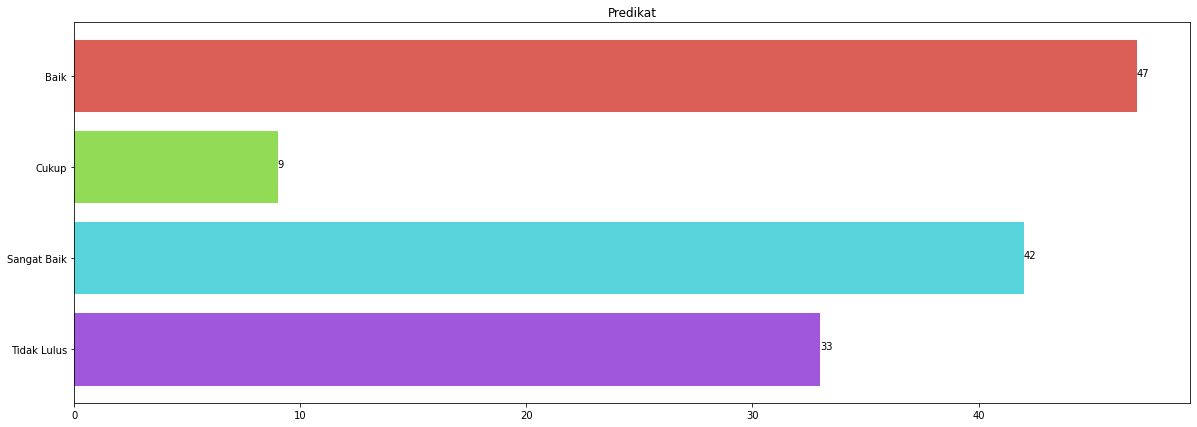

In [ ]:
_labels, _counts = np.unique(y_train, return_counts=True)
show_vertical_bar(le.classes_, _counts, title="Predikat")

In [ ]:
ovrs_smote = SMOTE(random_state=42)

In [ ]:
X_ovrs, y_ovrs = ovrs_smote.fit_resample(X_train_join, y_train)

In [ ]:
X_ovrs.shape

(188, 19)

In [ ]:
y_ovrs.shape

(188,)

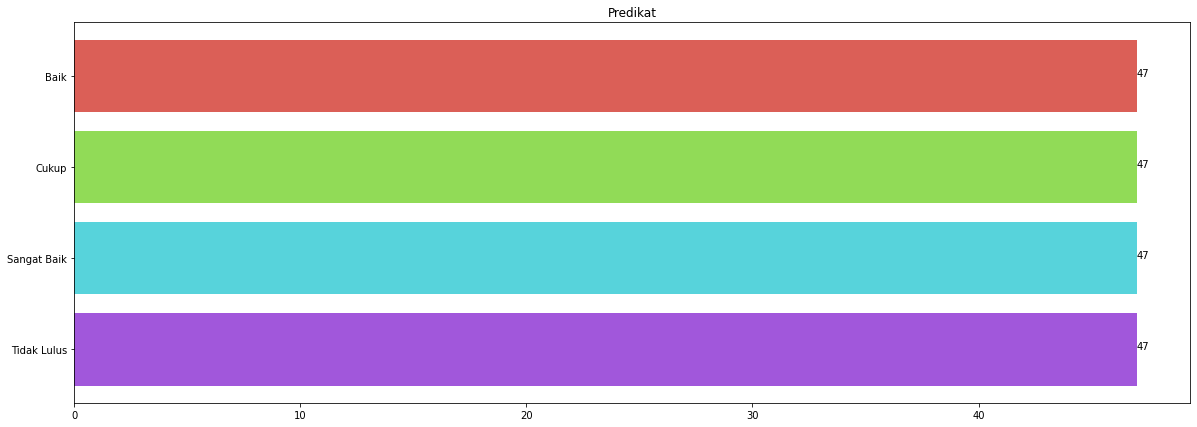

In [ ]:
_labels, _counts = np.unique(y_ovrs, return_counts=True)
show_vertical_bar(le.classes_, _counts, title="Predikat")

## Section 8/Declare new Variable
declare new X_train, X_test, y_train, y_test

In [ ]:
X_train_new = X_ovrs
X_train_new.shape

(188, 19)

In [ ]:
y_train_new = y_ovrs
y_train_new.shape

(188,)

In [ ]:
X_test_new = X_test_join
X_test_new.shape

(57, 19)

In [ ]:
y_test_new = y_test
y_test_new.shape

(57,)

# Get Data 
for hardcopy print only!!!

## Data Asli

In [ ]:
real_train = X_train.copy()
real_train['predicate'] = y_train

real_test = X_test.copy()
real_test['predicate'] = y_test

In [ ]:
df_real = pd.concat([real_train, real_test])

In [ ]:
df_real

,JK,SKS,Prodi,Angkatan,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,predicate
69,P,22,Matematika,2019,100.00,100,85,95,93.333333,93.333333,93.333333,3,100.000000,77.5,83.690476,0
54,P,21,Pend Mat,2019,100.00,100,98,100,100.000000,90.000000,90.000000,1,100.000000,92.5,85.890000,2
108,P,21,Ilmu Komputer,2020,100.00,85,87,90,87.333333,87.333333,87.333333,0,87.333333,70.0,0.000000,3
117,L,21,Ilmu Komputer,2020,100.00,90,90,85,88.333333,88.333333,88.333333,0,88.333333,70.0,0.000000,3
39,P,21,Pend Mat,2019,100.00,100,98,100,100.000000,90.000000,90.000000,2,100.000000,87.5,79.700000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,L,21,Ilmu Komputer,2020,93.75,80,85,92,81.666667,81.666667,81.666667,0,81.666667,75.0,0.000000,3
167,L,22,Pend Mat,2020,100.00,90,92,92,90.000000,92.000000,92.000000,0,91.333333,90.0,70.000000,2
130,L,21,Ilmu Komputer,2020,100.00,85,85,85,85.000000,85.000000,85.000000,0,85.000000,75.0,0.000000,3
18,L,21,Ilmu Komputer,2019,100.00,100,100,100,100.000000,100.000000,100.000000,0,100.000000,85.0,77.321429,0


In [ ]:
df_real.to_excel('output_df_real.xlsx')

## Data with Normalization

In [ ]:
train_idx, test_idx = np.array(X_train.index), np.array(X_test.index)

In [ ]:
test_idx

array([ 31,  66, 112, 120,  81, 152,  35, 102,  99,  98, 124,  16,  73,
       158, 132,  67, 119,  40,   4,  47,  51,  95, 180, 148,  29,  53,
        11, 107, 169,  56,  14, 106, 186,  19,  78,  90, 113,  84,  59,
       162,  33,  94, 123,  58,  93,  42,  17,   5, 114,  48, 161, 166,
       135, 167, 130,  18, 164])

In [ ]:
enc_categories = [i.tolist() for i in enc.categories_]
enc_categories = [i for sub in enc_categories for i in sub]

In [ ]:
fix_columns_names = np.concatenate((enc_categories, np.array(X_test_num.columns), ['predicate']))
fix_columns_names

array(['L', 'P', 'Ilmu Komputer', 'Matematika', 'Pend Mat', '2019',
       '2020', 'SKS', 'Kehadiran', 'TgsK1', 'TgsK2', 'TgsK3', 'TgsK4',
       'TgsK5', 'TgsK6', 'TgsIdv', 'Tgs1', 'UTS', 'UAS', 'predicate'],
      dtype=object)

In [ ]:
new_train_dnrm, new_test_dnrm = np.concatenate((X_train_join, y_train.reshape(-1, 1)), axis=1), np.concatenate((X_test_join, y_test.reshape(-1, 1)), axis=1)

In [ ]:
df_new_train_dnrm, df_new_test_dnrm = pd.DataFrame(new_train_dnrm, index=train_idx, columns=fix_columns_names), pd.DataFrame(new_test_dnrm, index=test_idx, columns=fix_columns_names)

In [ ]:
df_new_dnrm = pd.concat([df_new_train_dnrm, df_new_test_dnrm])

In [ ]:
df_new_dnrm

,L,P,Ilmu Komputer,Matematika,Pend Mat,2019,2020,SKS,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,predicate
69,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.104690,0.491387,1.434617,-1.330559,0.518934,0.283364,0.309812,0.313052,1.638617,0.845956,0.113121,0.684709,0.0
54,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,-0.106577,0.845956,1.135113,0.748780,2.0
108,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-0.988788,-0.637195,-0.984515,-1.215315,-1.342053,-0.979173,-1.623938,-0.397875,-1.753160,3.0
117,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.008815,-0.476131,-1.793324,-0.773202,-0.961127,-1.066202,-0.979173,-1.428946,-0.397875,-1.753160,3.0
39,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,0.766020,0.845956,0.794449,0.568468,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,-2.064084,-1.452247,-1.330559,-0.174743,-2.181957,-2.655713,-2.905208,-0.979173,-2.728890,-0.057211,-1.753160,3.0
167,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.104690,0.491387,-0.008815,-0.134360,-0.174743,-0.421013,-0.029105,-0.054749,-0.979173,-0.843971,0.964781,0.285911,2.0
130,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-1.330559,-1.793324,-1.477580,-1.808420,-1.985705,-0.979173,-2.078918,-0.057211,-1.753160,3.0
18,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.905232,0.491387,1.434617,1.232724,1.675064,1.692119,2.004397,2.152058,-0.979173,0.845956,0.624117,0.499181,0.0


In [ ]:
df_new_dnrm.to_excel('output_df_new_dnrm.xlsx')

## Data with only Encoding

In [ ]:
df_new_train_dnrm

,L,P,Ilmu Komputer,Matematika,Pend Mat,2019,2020,SKS,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,predicate
69,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.104690,0.491387,1.434617,-1.330559,0.518934,0.283364,0.309812,0.313052,1.638617,0.845956,0.113121,0.684709,0.0
54,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,-0.106577,0.845956,1.135113,0.748780,2.0
108,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-0.988788,-0.637195,-0.984515,-1.215315,-1.342053,-0.979173,-1.623938,-0.397875,-1.753160,3.0
117,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.008815,-0.476131,-1.793324,-0.773202,-0.961127,-1.066202,-0.979173,-1.428946,-0.397875,-1.753160,3.0
39,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,0.766020,0.845956,0.794449,0.568468,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,-2.064084,-0.730531,-0.988788,-0.637195,-0.984515,-1.215315,-1.342053,-0.106577,0.845956,0.283453,-1.753160,3.0
137,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-0.476131,-0.174743,-1.336704,-1.638962,-1.801804,-0.979173,-1.948923,-0.908870,-1.753160,3.0
72,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.104690,-0.871531,0.712901,1.232724,0.518934,0.987742,1.157104,1.232555,0.766020,0.845956,0.624117,0.424623,0.0
140,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.441844,-0.988788,-1.793324,-1.195829,-1.469503,-1.617904,-0.106577,-0.843971,-0.397875,-1.753160,3.0


In [ ]:
X_test_only_enc = np.concatenate((X_test_cat_new, X_test_num), axis=1)

In [ ]:
new_test_only_enc = np.concatenate((X_test_only_enc, y_test.reshape(-1, 1)), axis=1)

In [ ]:
df_new_test_only_enc = pd.DataFrame(new_test_only_enc, index=test_idx, columns=fix_columns_names)

In [ ]:
df_new_enc = pd.concat([df_new_train_dnrm, df_new_test_only_enc])

In [ ]:
df_new_enc

,L,P,Ilmu Komputer,Matematika,Pend Mat,2019,2020,SKS,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,predicate
69,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.104690,0.491387,1.434617,-1.330559,0.518934,0.283364,0.309812,0.313052,1.638617,0.845956,0.113121,0.684709,0.0
54,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,-0.106577,0.845956,1.135113,0.748780,2.0
108,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-0.988788,-0.637195,-0.984515,-1.215315,-1.342053,-0.979173,-1.623938,-0.397875,-1.753160,3.0
117,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.008815,-0.476131,-1.793324,-0.773202,-0.961127,-1.066202,-0.979173,-1.428946,-0.397875,-1.753160,3.0
39,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,0.766020,0.845956,0.794449,0.568468,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,1.0,0.0,1.0,0.0,0.0,0.0,1.0,21.000000,93.750000,80.000000,85.000000,92.000000,81.666667,81.666667,81.666667,0.000000,81.666667,75.000000,0.000000,3.0
167,1.0,0.0,0.0,0.0,1.0,0.0,1.0,22.000000,100.000000,90.000000,92.000000,92.000000,90.000000,92.000000,92.000000,0.000000,91.333333,90.000000,70.000000,2.0
130,1.0,0.0,1.0,0.0,0.0,0.0,1.0,21.000000,100.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,0.000000,85.000000,75.000000,0.000000,3.0
18,1.0,0.0,1.0,0.0,0.0,1.0,0.0,21.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,100.000000,85.000000,77.321429,0.0


In [ ]:
df_new_enc.to_excel('output_df_new_enc.xlsx')

## Data After Oversampling

In [ ]:
new_train_ovrs, new_test_ovrs = np.concatenate((X_train_new, y_train_new.reshape(-1, 1)), axis=1), np.concatenate((X_test_new, y_test_new.reshape(-1, 1)), axis=1)

In [ ]:
df_new_train_ovrs, df_new_test_ovrs = pd.DataFrame(new_train_ovrs, columns=fix_columns_names), pd.DataFrame(new_test_ovrs, columns=fix_columns_names)

In [ ]:
df_new_ovrs = pd.concat([df_new_train_ovrs, df_new_test_ovrs])

In [ ]:
df_new_ovrs

,L,P,Ilmu Komputer,Matematika,Pend Mat,2019,2020,SKS,Kehadiran,TgsK1,TgsK2,TgsK3,TgsK4,TgsK5,TgsK6,TgsIdv,Tgs1,UTS,UAS,predicate
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.104690,0.491387,1.434617,-1.330559,0.518934,0.283364,0.309812,0.313052,1.638617,0.845956,0.113121,0.684709,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,-0.106577,0.845956,1.135113,0.748780,2.0
2,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-0.988788,-0.637195,-0.984515,-1.215315,-1.342053,-0.979173,-1.623938,-0.397875,-1.753160,3.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.008815,-0.476131,-1.793324,-0.773202,-0.961127,-1.066202,-0.979173,-1.428946,-0.397875,-1.753160,3.0
4,0.0,1.0,0.0,0.0,1.0,1.0,0.0,-0.905232,0.491387,1.434617,0.890953,1.675064,1.692119,-0.537481,-0.606451,0.766020,0.845956,0.794449,0.568468,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,-2.064084,-1.452247,-1.330559,-0.174743,-2.181957,-2.655713,-2.905208,-0.979173,-2.728890,-0.057211,-1.753160,3.0
53,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.104690,0.491387,-0.008815,-0.134360,-0.174743,-0.421013,-0.029105,-0.054749,-0.979173,-0.843971,0.964781,0.285911,2.0
54,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.905232,0.491387,-0.730531,-1.330559,-1.793324,-1.477580,-1.808420,-1.985705,-0.979173,-2.078918,-0.057211,-1.753160,3.0
55,1.0,0.0,1.0,0.0,0.0,1.0,0.0,-0.905232,0.491387,1.434617,1.232724,1.675064,1.692119,2.004397,2.152058,-0.979173,0.845956,0.624117,0.499181,0.0


In [ ]:
df_new_ovrs.to_excel('output_df_new_ovrs.xlsx')

# Pemodelan Machine Learning

## Batas Variabel

In [ ]:
RANDOM_STATE = 50
MAX_DEPTH = 3

In [ ]:
CLASS_NAMES = list(le.classes_)

In [ ]:
NUM_TREES = np.arange(64, 132, 1, dtype=int)
NUM_TREES

array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131])

In [ ]:
train_num_rows, train_nums_features = X_train_new.shape
MAX_FEATURES = np.array([int(1/2*np.absolute(np.sqrt(train_nums_features))), int(np.sqrt(train_nums_features)), int(2*(np.sqrt(train_nums_features)))])
MAX_FEATURES

array([2, 4, 8])

In [ ]:
FEATURE_NAMES = fix_columns_names[:-1]
FEATURE_NAMES

array(['L', 'P', 'Ilmu Komputer', 'Matematika', 'Pend Mat', '2019',
       '2020', 'SKS', 'Kehadiran', 'TgsK1', 'TgsK2', 'TgsK3', 'TgsK4',
       'TgsK5', 'TgsK6', 'TgsIdv', 'Tgs1', 'UTS', 'UAS'], dtype=object)

In [ ]:
for i, feature in enumerate(FEATURE_NAMES):
  print(i, feature)

0 L
1 P
2 Ilmu Komputer
3 Matematika
4 Pend Mat
5 2019
6 2020
7 SKS
8 Kehadiran
9 TgsK1
10 TgsK2
11 TgsK3
12 TgsK4
13 TgsK5
14 TgsK6
15 TgsIdv
16 Tgs1
17 UTS
18 UAS


## Dengan Meenggunakan Library

### Tahap 1
Pada tahap ini dilakukan pemodelan ML dengan menggunakan sembarang parameter yang lalu akan diujikan dengan confusion matrix dan divalidasi dengan cross validation

In [ ]:
# X_test_new

In [ ]:
forest = RandomForestClassifier(max_depth=MAX_DEPTH, oob_score=True, random_state=RANDOM_STATE)
forest.fit(X_train_new, y_train_new)
# forest.fit(X_over, y_over)

RandomForestClassifier(max_depth=3, oob_score=True, random_state=50)

In [ ]:
y_pred_test = forest.predict(X_test_new)

In [ ]:
y_pred_train = forest.predict(X_train_new)

In [ ]:
print("OOB Score from model", forest.oob_score_)

OOB Score from model 0.898936170212766


In [ ]:
print("Accuracy score with train data", np.round(accuracy_score(y_train_new, y_pred_train), 2) * 100, "%")
print("Accuracy score with test data", np.round(accuracy_score(y_test_new, y_pred_test), 2) * 100, "%")

Accuracy score with train data 94.0 %
Accuracy score with test data 86.0 %


[[16  3  2  0]
 [ 2  1  0  0]
 [ 0  0 19  0]
 [ 0  1  0 13]]


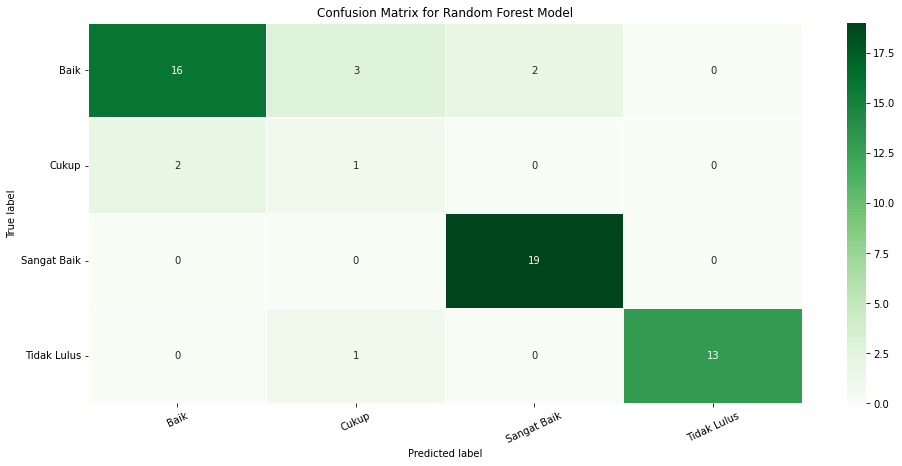

In [ ]:
confusion_matrix_report(y_test_new, y_pred_test, CLASS_NAMES)

In [ ]:
class_report_df(y_test_new, y_pred_test)

,precision,recall,f1-score,support
0,0.888889,0.761905,0.820513,21.000000
1,0.200000,0.333333,0.250000,3.000000
2,0.904762,1.000000,0.950000,19.000000
3,1.000000,0.928571,0.962963,14.000000
accuracy,0.859649,0.859649,0.859649,0.859649
macro avg,0.748413,0.755952,0.745869,57.000000
weighted avg,0.885213,0.859649,0.868636,57.000000


In [ ]:
kfolds_test(forest, 10, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.84210526 1.         1.         0.94736842 0.73684211 0.84210526
 0.89473684 0.94736842 0.83333333 0.88888889]
Accuracy Score: 0.89 
Standard Deviation: 0.08


### Tahap 2
Uji coba model dengan jumlah pohon dan max_features tertentu untuk menadapatkan oob error terkecil/oob_score terbesar

In [ ]:
oob_df = pd.DataFrame()
for max_feature in MAX_FEATURES:
  for num_tree in NUM_TREES:
    rf = RandomForestClassifier(n_estimators=num_tree, max_features=max_feature, max_depth=MAX_DEPTH, oob_score=True, random_state=RANDOM_STATE)
    rf.fit(X_train_new, y_train_new)
    oob_score = np.round(rf.oob_score_, 5)
    oob_df.at[max_feature, num_tree] = oob_score

In [ ]:
oob_df

,64,65,66,67,68,69,70,71,72,73,...,122,123,124,125,126,127,128,129,130,131
2,0.82447,0.82979,0.84574,0.84574,0.84043,0.82447,0.82447,0.82447,0.81915,0.82447,...,0.87766,0.88830,0.88830,0.88830,0.87766,0.87766,0.88298,0.87766,0.87766,0.87234
4,0.88830,0.88830,0.88830,0.89362,0.88830,0.88830,0.89362,0.89894,0.90426,0.90426,...,0.89894,0.90426,0.90957,0.90957,0.90426,0.90426,0.90957,0.90957,0.90426,0.90426
8,0.91489,0.91489,0.91489,0.90957,0.90957,0.90957,0.90957,0.90957,0.90957,0.90957,...,0.92021,0.92021,0.92021,0.92021,0.90957,0.91489,0.91489,0.91489,0.91489,0.91489


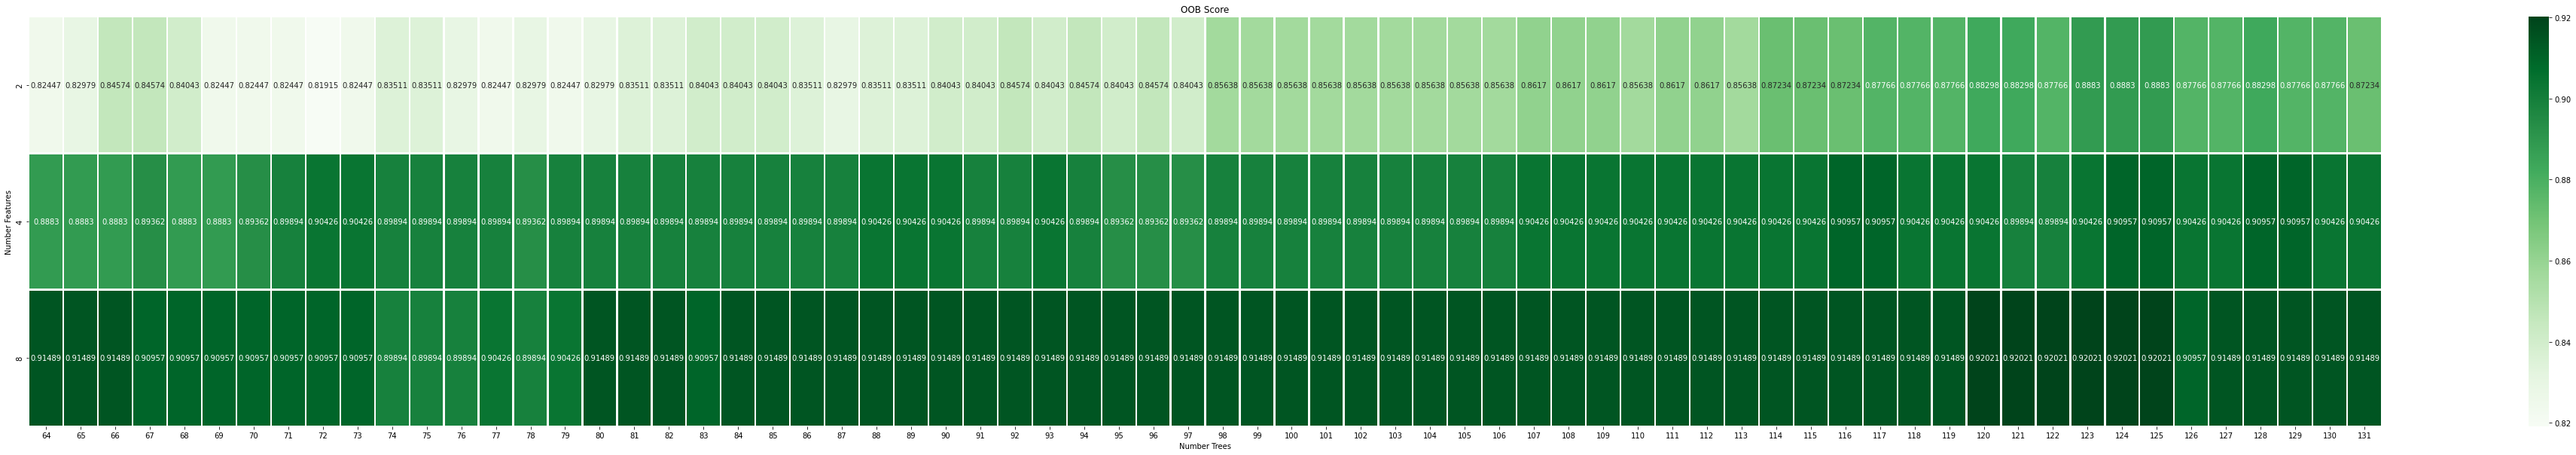

In [ ]:
heatmap_for_oob(oob_df, "OOB Score")

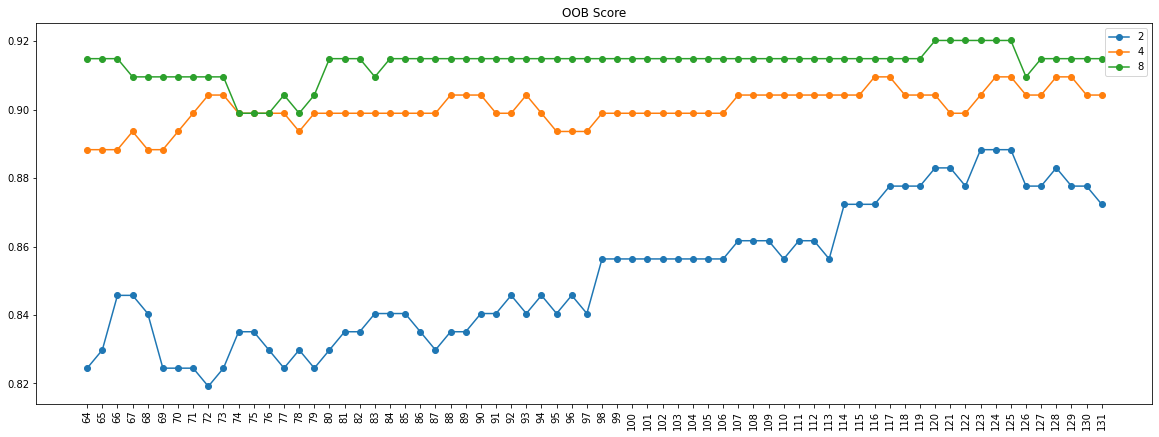

In [ ]:
line_for_oob(oob_df, "OOB Score", 90, 'o')

In [ ]:
oob_error_df = 1 - oob_df

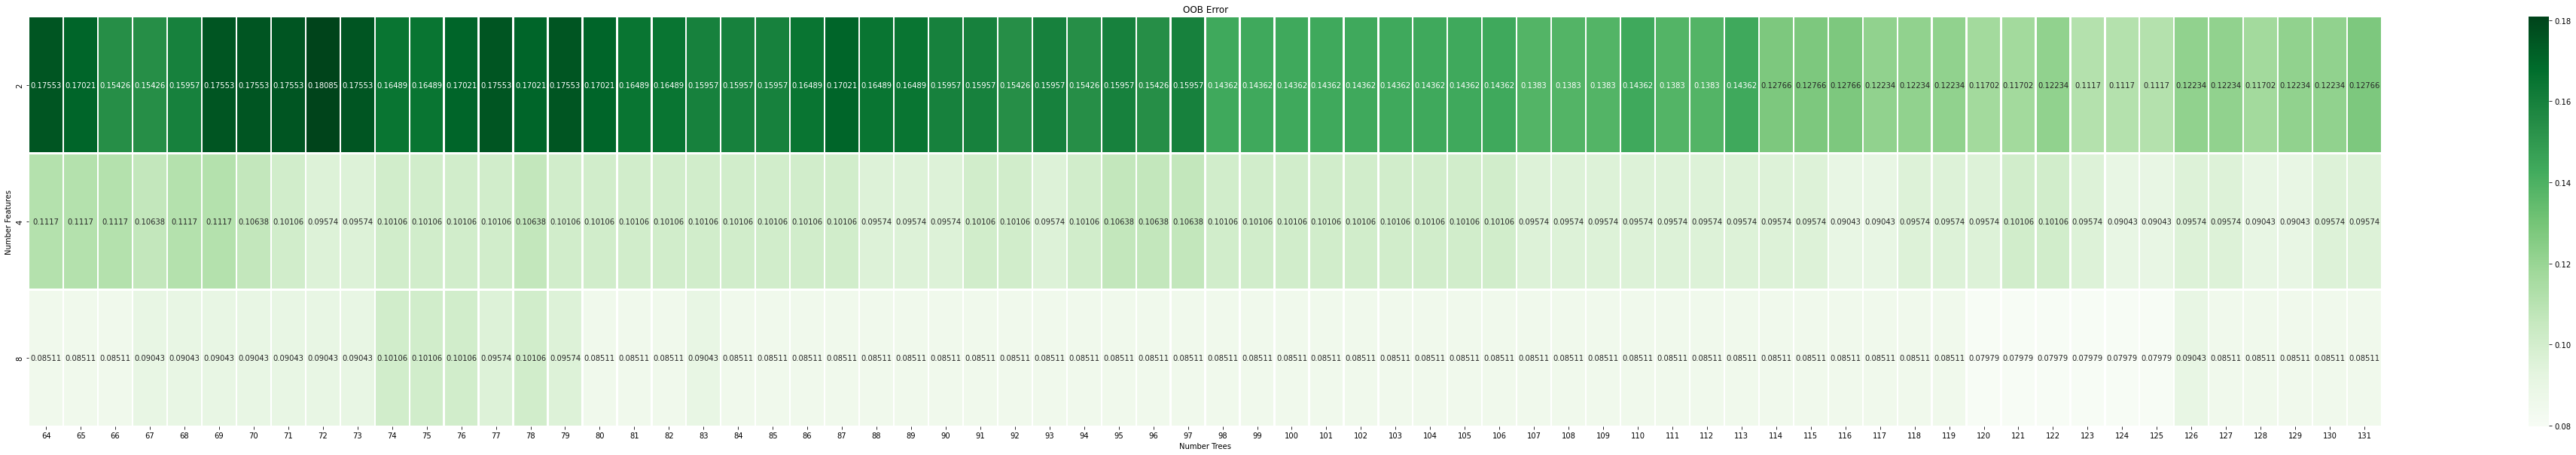

In [ ]:
heatmap_for_oob(oob_error_df, "OOB Error")

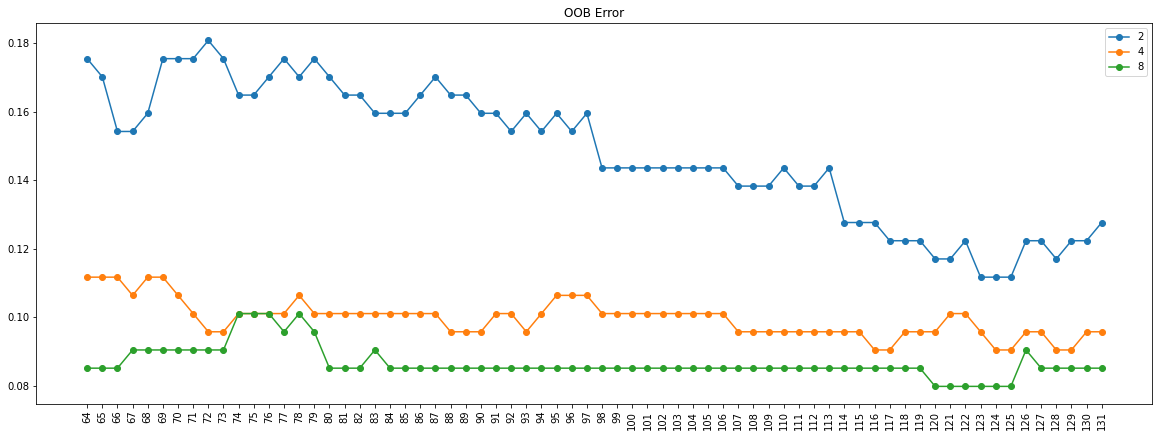

In [ ]:
line_for_oob(oob_error_df, "OOB Error", 90, 'o')

In [ ]:
oob_error_min = search_oob_error_min(oob_error_df)
oob_error_min

,120,121,122,123,124,125
8,0.07979,0.07979,0.07979,0.07979,0.07979,0.07979


### Tahap 3
pembuatan dan Validasi model ulang dengan jumlah max feature dan tree yang optimum

In [ ]:
opt_forest = RandomForestClassifier(n_estimators=125, max_features=8, max_depth=MAX_DEPTH, oob_score=True, random_state=RANDOM_STATE)
opt_forest.fit(X_train_new, y_train_new)

RandomForestClassifier(max_depth=3, max_features=8, n_estimators=125,
                       oob_score=True, random_state=50)

In [ ]:
y_pred_test_opt = opt_forest.predict(X_test_new)

In [ ]:
y_pred_train_opt = opt_forest.predict(X_train_new)

In [ ]:
print("OOB Score from model", opt_forest.oob_score_)

OOB Score from model 0.9202127659574468


In [ ]:
print("Accuracy score with train data", np.round(accuracy_score(y_train_new, y_pred_train_opt), 2) * 100, "%")
print("Accuracy score with test data", np.round(accuracy_score(y_test_new, y_pred_test_opt), 2) * 100, "%")

Accuracy score with train data 95.0 %
Accuracy score with test data 84.0 %


[[16  2  3  0]
 [ 2  1  0  0]
 [ 1  0 18  0]
 [ 0  1  0 13]]


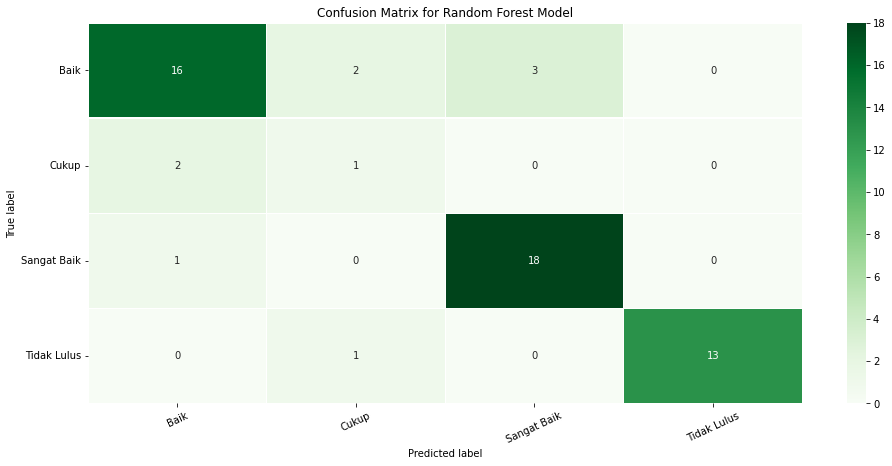

In [ ]:
confusion_matrix_report(y_test_new, y_pred_test_opt, CLASS_NAMES)

In [ ]:
class_report_df(y_test_new, y_pred_test_opt)

,precision,recall,f1-score,support
0,0.842105,0.761905,0.800000,21.000000
1,0.250000,0.333333,0.285714,3.000000
2,0.857143,0.947368,0.900000,19.000000
3,1.000000,0.928571,0.962963,14.000000
accuracy,0.842105,0.842105,0.842105,0.842105
macro avg,0.737312,0.742794,0.737169,57.000000
weighted avg,0.854736,0.842105,0.846292,57.000000


In [ ]:
kfolds_test(opt_forest, 10, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.94736842 1.         1.         0.94736842 0.73684211 0.78947368
 0.89473684 0.89473684 0.83333333 0.88888889]
Accuracy Score: 0.89 
Standard Deviation: 0.08


### Feature Importance

In [ ]:
fi_list = opt_forest.feature_importances_

In [ ]:
fi_list.sum()

1.0

In [ ]:
feature_importances_report(fi_list, FEATURE_NAMES, list(enc.categories_))

,Importances
UAS,0.288603
Prodi,0.096709
TgsK6,0.072091
UTS,0.057952
TgsK5,0.057848
TgsK1,0.048181
TgsIdv,0.026503
Angkatan,0.025631
Tgs1,0.021367
TgsK4,0.020313


### Get Tree

In [ ]:
def visualize_tree_sklearn(model, estimator, class_names):
  plt.figure(figsize=(20,20))
  plot_tree = tree.plot_tree(model.estimators_[estimator], class_names=class_names)
  plt.show()

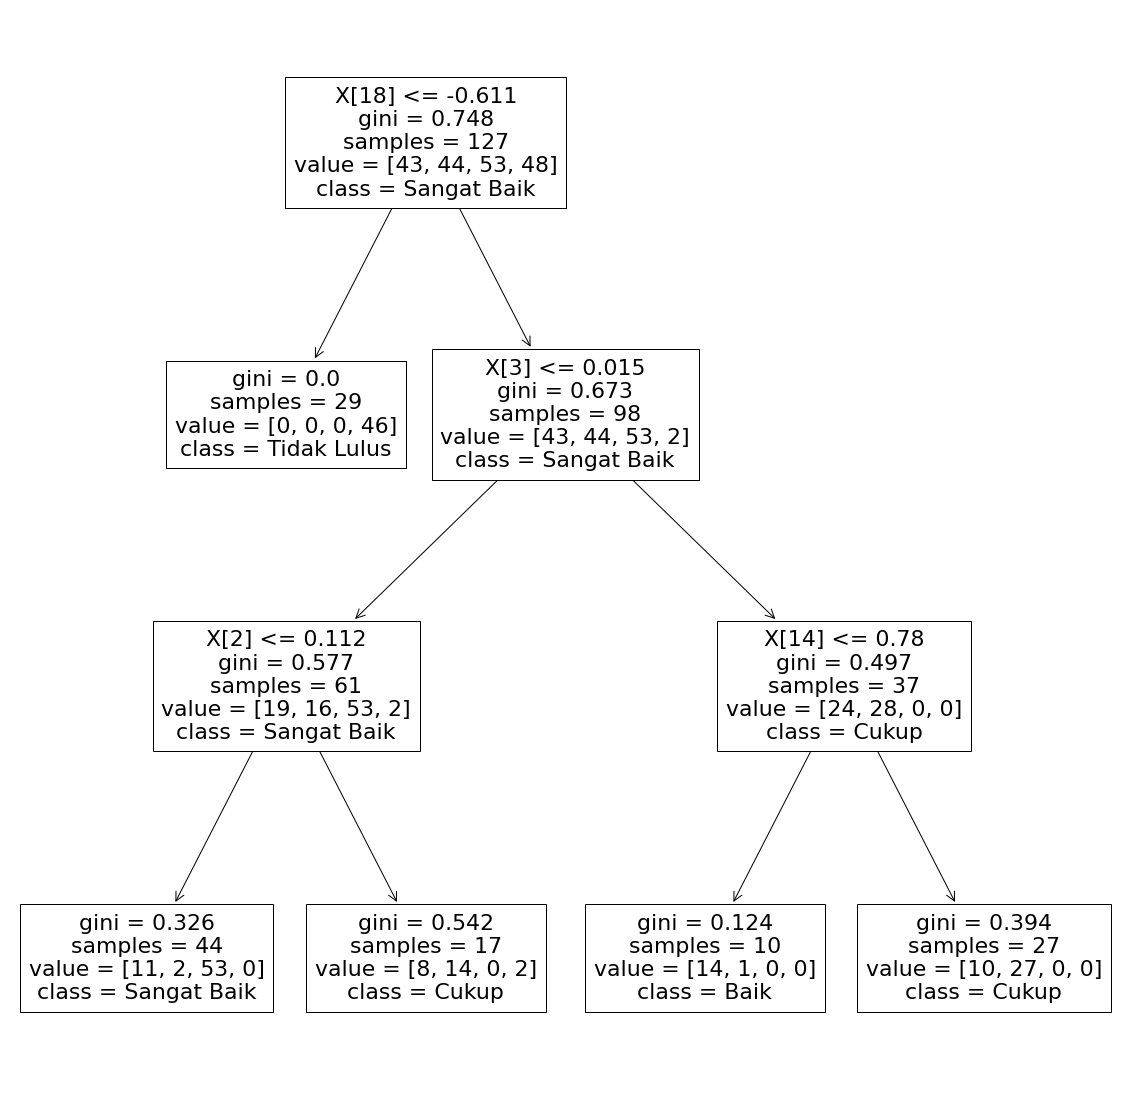

In [ ]:
visualize_tree_sklearn(opt_forest, 15, list(le.classes_))

## Tanpa menggunakan Library
uji coba dengan menggunakan algoritma ML yang dibuat

### Tahap 1
Pada tahap ini dilakukan pemodelan ML dengan menggunakan sembarang parameter yang lalu akan diujikan dengan confusion matrix dan divalidasi dengan cross validation

In [ ]:
my_forest = MyRandomForest(max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
my_forest.fit(X_train_new, y_train_new)

Output streaming akan dipotong hingga 5000 baris terakhir.
 0.67466967 0.68423303 0.81514554 0.89482735 0.95477271 1.        ]
[ 1.63861686 -0.97917349  0.76602008  2.51121365 -0.10657671 -0.97917349
 -0.30085638  0.76602008 -0.97917349 -0.97917349  1.63861686 -0.10657671
  0.76602008 -0.97917349  0.76602008 -0.10657671 -0.10657671 -0.10657671
  0.31439892 -0.97917349 -0.41787851 -0.10657671 -0.10657671 -0.10657671
 -0.97917349 -0.10657671 -0.10657671 -0.41787851 -0.97917349 -0.10657671
  0.76602008 -0.97917349 -0.97917349 -0.10657671 -0.10657671  1.63861686
 -0.97917349 -0.97917349 -0.10657671 -0.10657671  0.31439892  2.51121365
  0.76602008 -0.10657671 -0.10657671 -0.05378368 -0.10657671 -0.97917349
 -0.97917349 -0.97917349  0.76602008 -0.97917349 -0.97917349  2.51121365
 -0.62738624 -0.97917349 -0.97917349 -0.25601981 -0.97917349 -0.10657671
 -0.10657671 -0.97917349 -0.97917349  0.67878229 -0.97917349 -0.97917349
 -0.97917349 -0.10657671 -0.41787851  0.76602008 -0.97917349 -0.106576

In [ ]:
y_pred_test_my = my_forest.predict(X_test_new)

In [ ]:
y_pred_test_my = my_forest.predict(X_test_new)
y_pred_train_my = my_forest.predict(X_train_new)

In [ ]:
print("OOB Score from model", my_forest.oob_score_()) 

OOB Score from model 0.6329022761796559


In [ ]:
# accuracy_score(y_test, y_pred_test_my)
print("Accuracy score with train data", np.round(accuracy_score(y_train_new, y_pred_train_my), 2) * 100, "%")
print("Accuracy score with test data", np.round(accuracy_score(y_test_new, y_pred_test_my), 2) * 100, "%")

Accuracy score with train data 93.0 %
Accuracy score with test data 81.0 %


[[38  6  3  0]
 [ 1 46  0  0]
 [ 0  0 47  0]
 [ 1  2  0 44]]


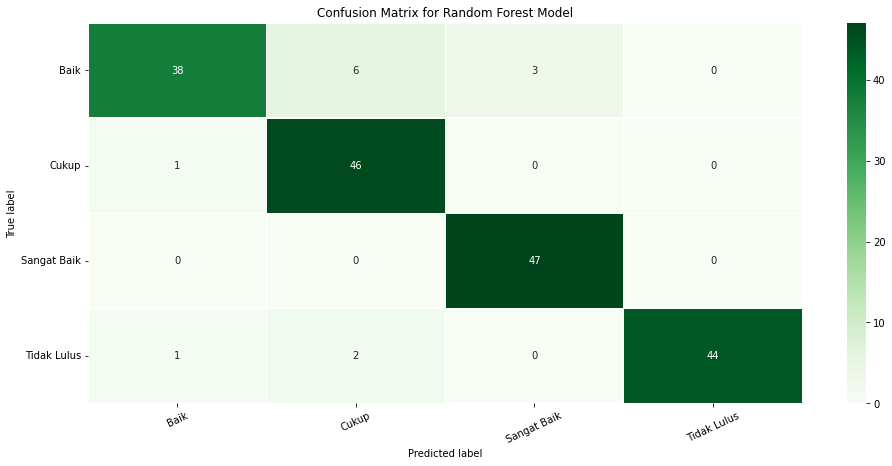

In [ ]:
confusion_matrix_report(y_train_new, y_pred_train_my, CLASS_NAMES)

[[15  3  3  0]
 [ 2  1  0  0]
 [ 2  0 17  0]
 [ 0  1  0 13]]


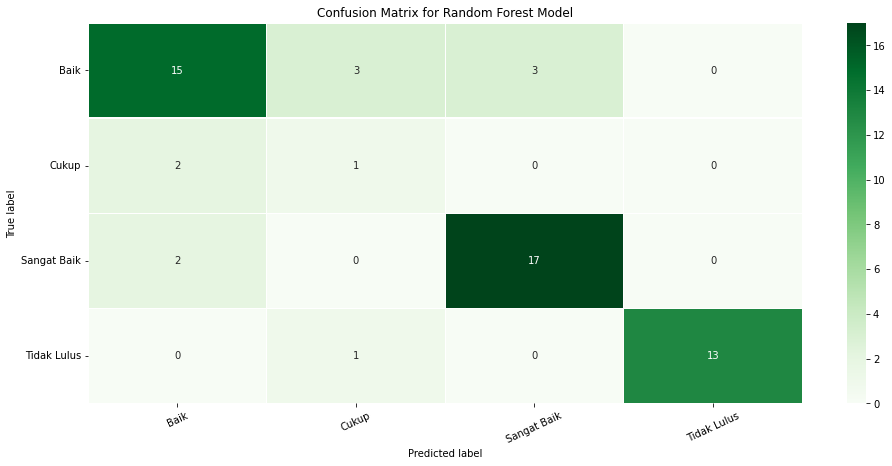

In [ ]:
confusion_matrix_report(y_test_new, y_pred_test_my, CLASS_NAMES)

In [ ]:
class_report_df(y_test_new, y_pred_test_my)

,precision,recall,f1-score,support
0,0.789474,0.714286,0.750000,21.000000
1,0.200000,0.333333,0.250000,3.000000
2,0.850000,0.894737,0.871795,19.000000
3,1.000000,0.928571,0.962963,14.000000
accuracy,0.807018,0.807018,0.807018,0.807018
macro avg,0.709868,0.717732,0.708689,57.000000
weighted avg,0.830332,0.807018,0.816589,57.000000


In [ ]:
kfolds_test(my_forest, 10, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.84210526 0.94736842 1.         0.89473684 0.57894737 0.89473684
 0.94736842 0.84210526 0.72222222 0.83333333]
Accuracy Score: 0.85 
Standard Deviation: 0.12


In [ ]:
kfolds_test(my_forest, 11, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.94444444 1.         1.         0.88235294 0.82352941 0.76470588
 0.88235294 0.94117647 0.88235294 0.64705882 0.94117647]
Accuracy Score: 0.88 
Standard Deviation: 0.10


In [ ]:
kfolds_test(my_forest, 12, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.875      1.         1.         0.9375     1.         0.625
 0.8125     0.875      0.93333333 0.86666667 0.8        0.93333333]
Accuracy Score: 0.89 
Standard Deviation: 0.10


In [ ]:
kfolds_test(my_forest, 13, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.73333333 0.93333333 1.         0.93333333 0.93333333 0.6
 0.71428571 0.78571429 0.85714286 0.78571429 0.78571429 0.85714286
 0.92857143]
Accuracy Score: 0.83 
Standard Deviation: 0.11


In [ ]:
kfolds_test(my_forest, 14, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.92857143 1.         0.92857143 0.85714286 0.92857143 0.92857143
 0.76923077 0.84615385 0.92307692 0.84615385 0.92307692 0.76923077
 0.84615385 0.92307692]
Accuracy Score: 0.89 
Standard Deviation: 0.06


In [ ]:
kfolds_test(my_forest, 15, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.92307692 0.92307692 1.         1.         0.84615385 1.
 0.46153846 0.76923077 0.91666667 0.91666667 0.91666667 1.
 0.66666667 0.83333333 0.91666667]
Accuracy Score: 0.87 
Standard Deviation: 0.14


### Tahap 2
Uji coba model dengan jumlah pohon dan max_features tertentu untuk menadapatkan oob error terkecil/oob_score terbesar

In [ ]:
oob_df_my = pd.DataFrame()
for max_feature in MAX_FEATURES:
  for num_tree in NUM_TREES:
    rf = MyRandomForest(n_estimators=num_tree, max_features=max_feature, max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
    rf.fit(X_train_new, y_train_new)
    oob_score = np.round(rf.oob_score_(), 5)
    oob_df_my.at[max_feature, num_tree] = oob_score

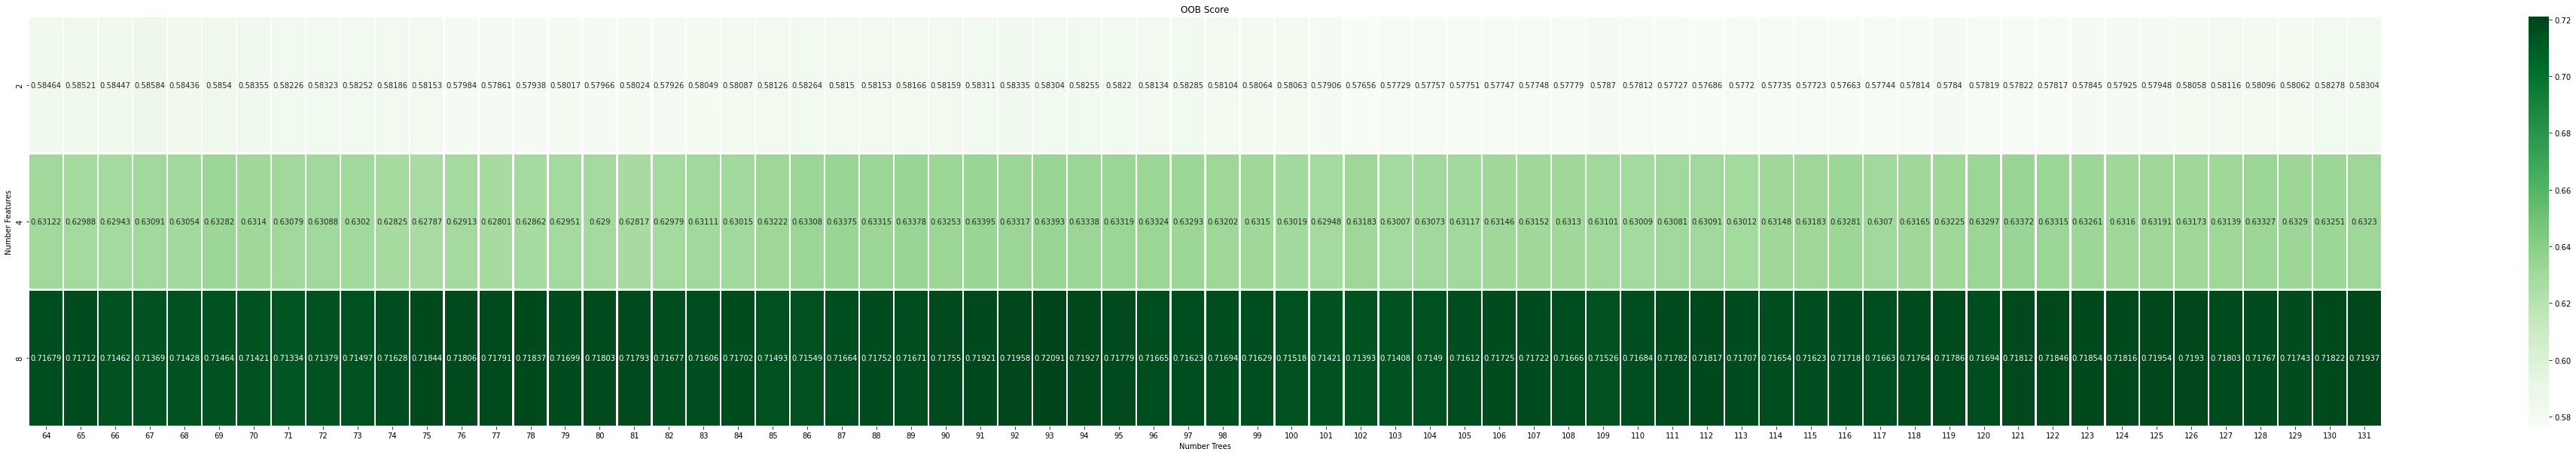

In [ ]:
heatmap_for_oob(oob_df_my, "OOB Score")

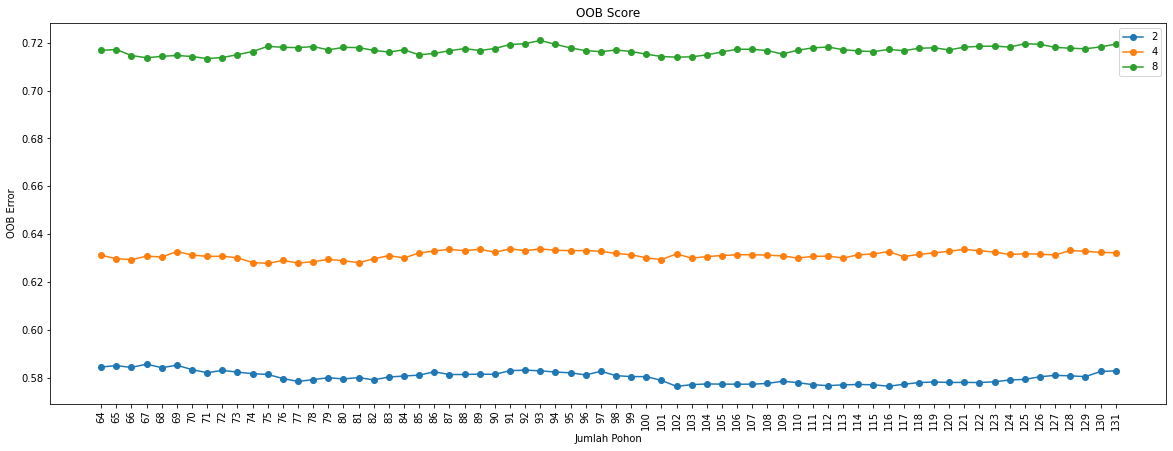

In [ ]:
line_for_oob(oob_df_my, "OOB Score", 90, 'o')

In [ ]:
oob_error_df_my = 1 - oob_df_my

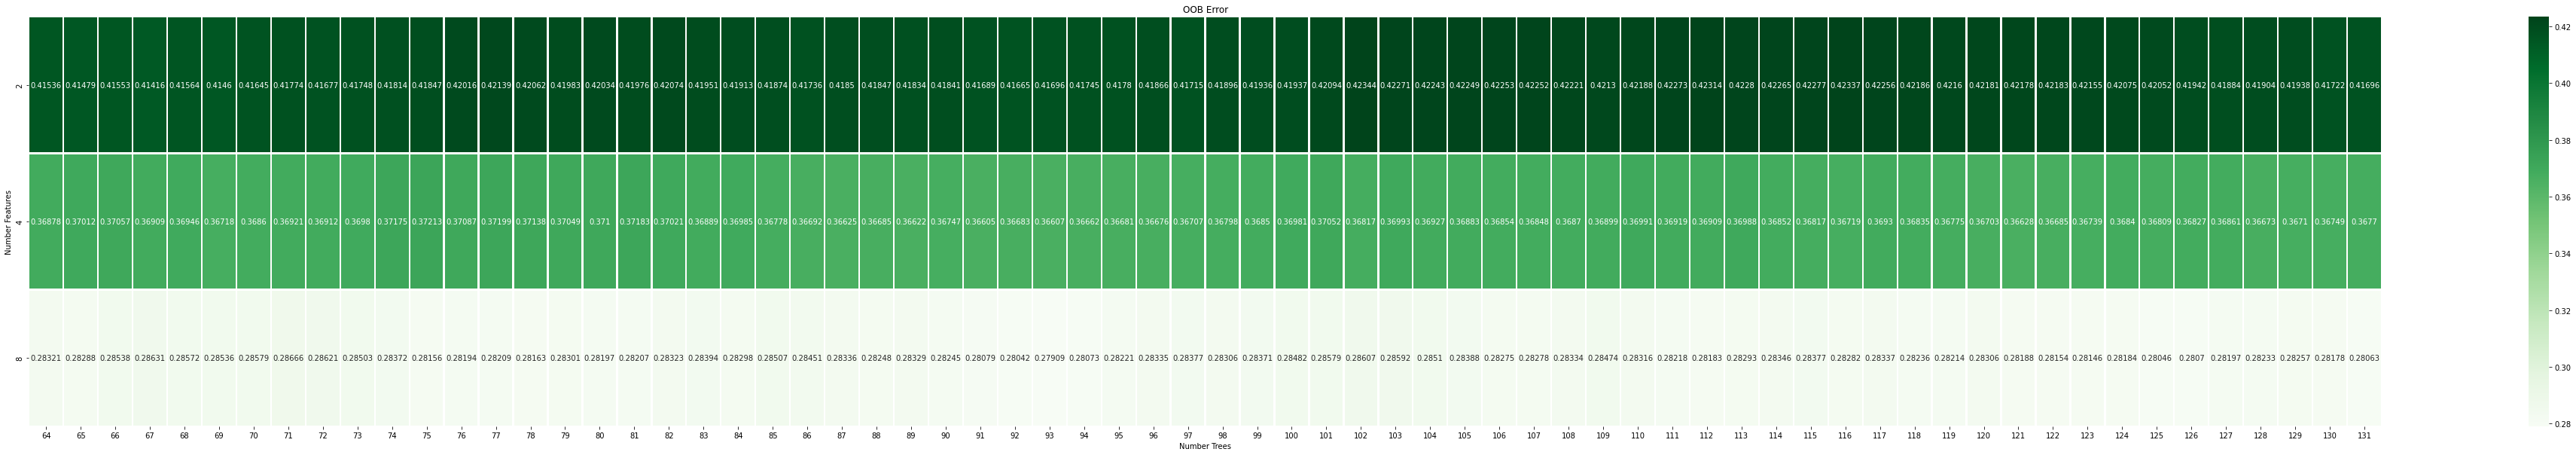

In [ ]:
heatmap_for_oob(oob_error_df_my, "OOB Error")

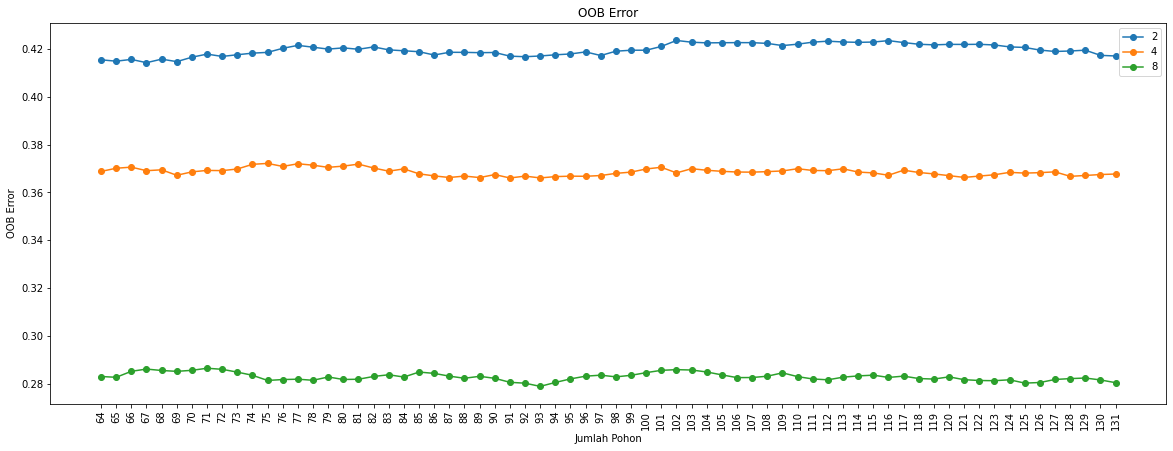

In [ ]:
line_for_oob(oob_error_df_my, "OOB Error", 90, 'o')

In [ ]:
search_oob_error_min(oob_error_df_my)

,93
8,0.27909


In [ ]:
oob_error_df_my.to_excel('OOB Error.xlsx')

Pada tabel di atas dengan mengabaikan nilai Nan, maka dapat diketahui bahwa oob error terkecil terletak pada jumlah pohon 93 dan max_feature 8

### Tahap 3
pembuatan dan Validasi model ulang dengan jumlah max feature dan tree yang optimum

In [ ]:
my_opt_forest = MyRandomForest(n_estimators=93, max_features=8, max_depth=MAX_DEPTH, random_state=RANDOM_STATE)
my_opt_forest.fit(X_train_new, y_train_new)

In [ ]:
my_y_pred_test_opt = my_opt_forest.predict(X_test_new)
my_y_pred_train_opt = my_opt_forest.predict(X_train_new)

In [ ]:
print("OOB Score from model", my_opt_forest.oob_score_())

OOB Score from model 0.7209091734113275


In [ ]:
print("Accuracy score with train data", np.round(accuracy_score(y_train_new, my_y_pred_train_opt), 2) * 100, "%")
print("Accuracy score with test data", np.round(accuracy_score(y_test_new, my_y_pred_test_opt), 2) * 100, "%")

Accuracy score with train data 94.0 %
Accuracy score with test data 82.0 %


[[40  4  3  0]
 [ 1 46  0  0]
 [ 0  0 47  0]
 [ 1  2  0 44]]


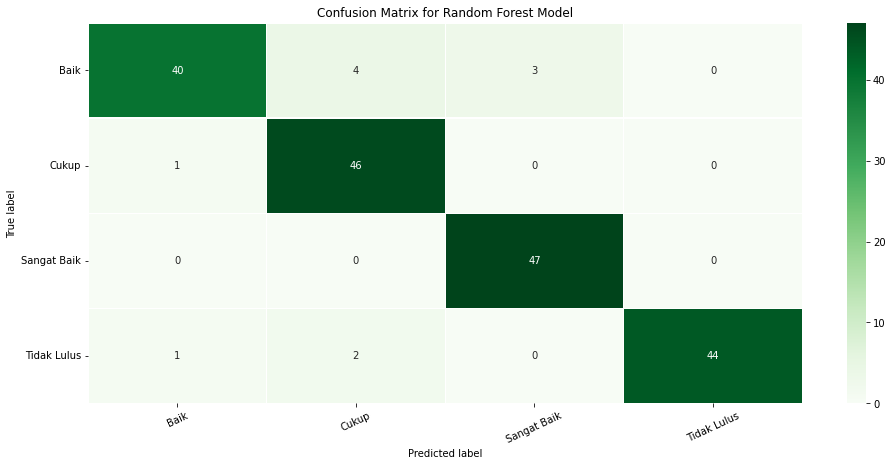

In [ ]:
confusion_matrix_report(y_train_new, my_y_pred_train_opt, CLASS_NAMES)

[[15  3  3  0]
 [ 2  1  0  0]
 [ 1  0 18  0]
 [ 0  1  0 13]]


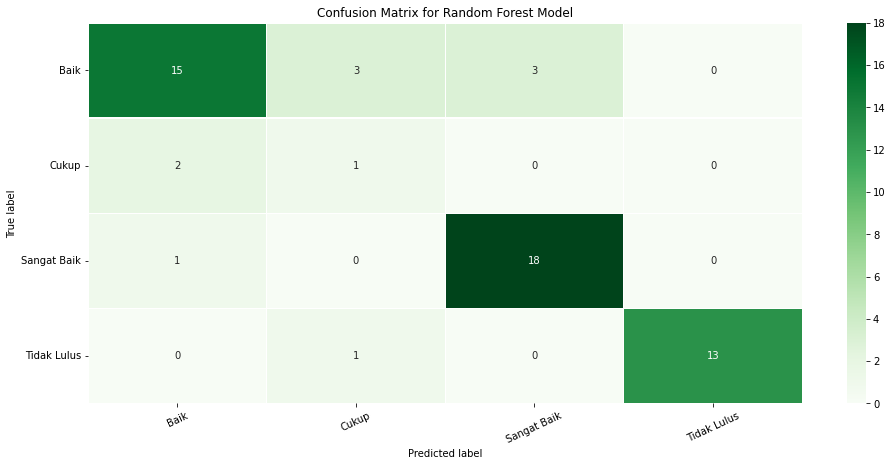

In [ ]:
confusion_matrix_report(y_test_new, my_y_pred_test_opt, CLASS_NAMES)

In [ ]:
class_report_df(y_test_new, my_y_pred_test_opt)

,precision,recall,f1-score,support
0,0.833333,0.714286,0.769231,21.000000
1,0.200000,0.333333,0.250000,3.000000
2,0.857143,0.947368,0.900000,19.000000
3,1.000000,0.928571,0.962963,14.000000
accuracy,0.824561,0.824561,0.824561,0.824561
macro avg,0.722619,0.730890,0.720548,57.000000
weighted avg,0.848872,0.824561,0.833076,57.000000


In [ ]:
kfolds_test(my_opt_forest, 10, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.94736842 1.         1.         0.94736842 0.78947368 0.84210526
 0.89473684 0.84210526 0.83333333 0.88888889]
Accuracy Score: 0.90 
Standard Deviation: 0.07


In [ ]:
kfolds_test(my_opt_forest, 11, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.94444444 1.         1.         0.94117647 0.82352941 0.82352941
 0.88235294 0.94117647 0.88235294 0.88235294 0.88235294]
Accuracy Score: 0.91 
Standard Deviation: 0.06


In [ ]:
kfolds_test(my_opt_forest, 12, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.875      1.         1.         0.9375     0.9375     0.75
 0.8125     0.9375     0.93333333 0.8        0.93333333 0.86666667]
Accuracy Score: 0.90 
Standard Deviation: 0.08


In [ ]:
kfolds_test(my_opt_forest, 13, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.93333333 1.         1.         1.         0.93333333 0.8
 0.71428571 0.92857143 0.92857143 0.92857143 0.85714286 1.
 0.85714286]
Accuracy Score: 0.91 
Standard Deviation: 0.08


In [ ]:
kfolds_test(my_opt_forest, 14, X_train_new, y_train_new, RANDOM_STATE)

Scores [1.         0.92857143 1.         1.         0.92857143 1.
 0.76923077 0.84615385 1.         0.92307692 0.92307692 0.84615385
 0.92307692 0.92307692]
Accuracy Score: 0.93 
Standard Deviation: 0.07


In [ ]:
kfolds_test(my_opt_forest, 15, X_train_new, y_train_new, RANDOM_STATE)

Scores [0.84615385 0.92307692 1.         1.         0.92307692 1.
 0.61538462 0.76923077 0.91666667 0.91666667 0.91666667 1.
 0.83333333 0.91666667 0.83333333]
Accuracy Score: 0.89 
Standard Deviation: 0.10


### Feature Importance

In [ ]:
my_fi_list = my_opt_forest.feature_importance()
my_fi_list

array([0.00492827, 0.01187486, 0.04040157, 0.05703447, 0.12655614,
       0.03963202, 0.02729867, 0.00843194, 0.01257198, 0.07452591,
       0.01011776, 0.04055849, 0.01815663, 0.06482141, 0.09832432,
       0.02324447, 0.01343065, 0.06612503, 0.26196542])

In [ ]:
pd.DataFrame(my_fi_list, index=FEATURE_NAMES, columns=['Importances']).sort_values(by=['Importances'], ascending=False)

,Importances
UAS,0.261965
Pend Mat,0.126556
TgsK6,0.098324
TgsK1,0.074526
UTS,0.066125
TgsK5,0.064821
Matematika,0.057034
TgsK3,0.040558
Ilmu Komputer,0.040402
2019,0.039632


In [ ]:
feature_importances_report(my_fi_list, FEATURE_NAMES, list(enc.categories_))

,Importances
UAS,0.261965
Prodi,0.223992
TgsK6,0.098324
TgsK1,0.074526
Angkatan,0.066931
UTS,0.066125
TgsK5,0.064821
TgsK3,0.040558
TgsIdv,0.023244
TgsK4,0.018157


In [ ]:
def feature_importances_report_2(feature_importances, feature_names, encoding_categories):
  grouping = ["Jenis Kelamin", "Prodi", "Angkatan"]
  grouping_k = ["TgsK1", "TgsK2", "TgsK3", "TgsK4", "TgsK5", "TgsK6"]
  fi_df = pd.DataFrame(feature_importances, index=feature_names, columns=['Importances'])
  for i, group_feature in enumerate(encoding_categories):
    vals = 0
    # print(i, group_feature)
    for feature in group_feature:
      vals += fi_df.loc[str(feature)]
      fi_df.drop(str(feature), axis=0, inplace=True)
    # vals /= len(group_feature)
    fi_df.loc[grouping[i]] = vals
  
  k_vals = 0
  for k in (grouping_k):
    # print(k)
    k_vals += fi_df.loc[k]
    fi_df.drop(k, axis=0, inplace=True)
  # print(k_vals)
  fi_df.loc["TgsK"] = k_vals

  return fi_df.sort_values(by=['Importances'], ascending=False)

In [ ]:
feature_importances_report_2(my_fi_list, FEATURE_NAMES, list(enc.categories_))

,Importances
TgsK,0.306505
UAS,0.261965
Prodi,0.223992
Angkatan,0.066931
UTS,0.066125
TgsIdv,0.023244
Jenis Kelamin,0.016803
Tgs1,0.013431
Kehadiran,0.012572
SKS,0.008432


### Get Tree

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


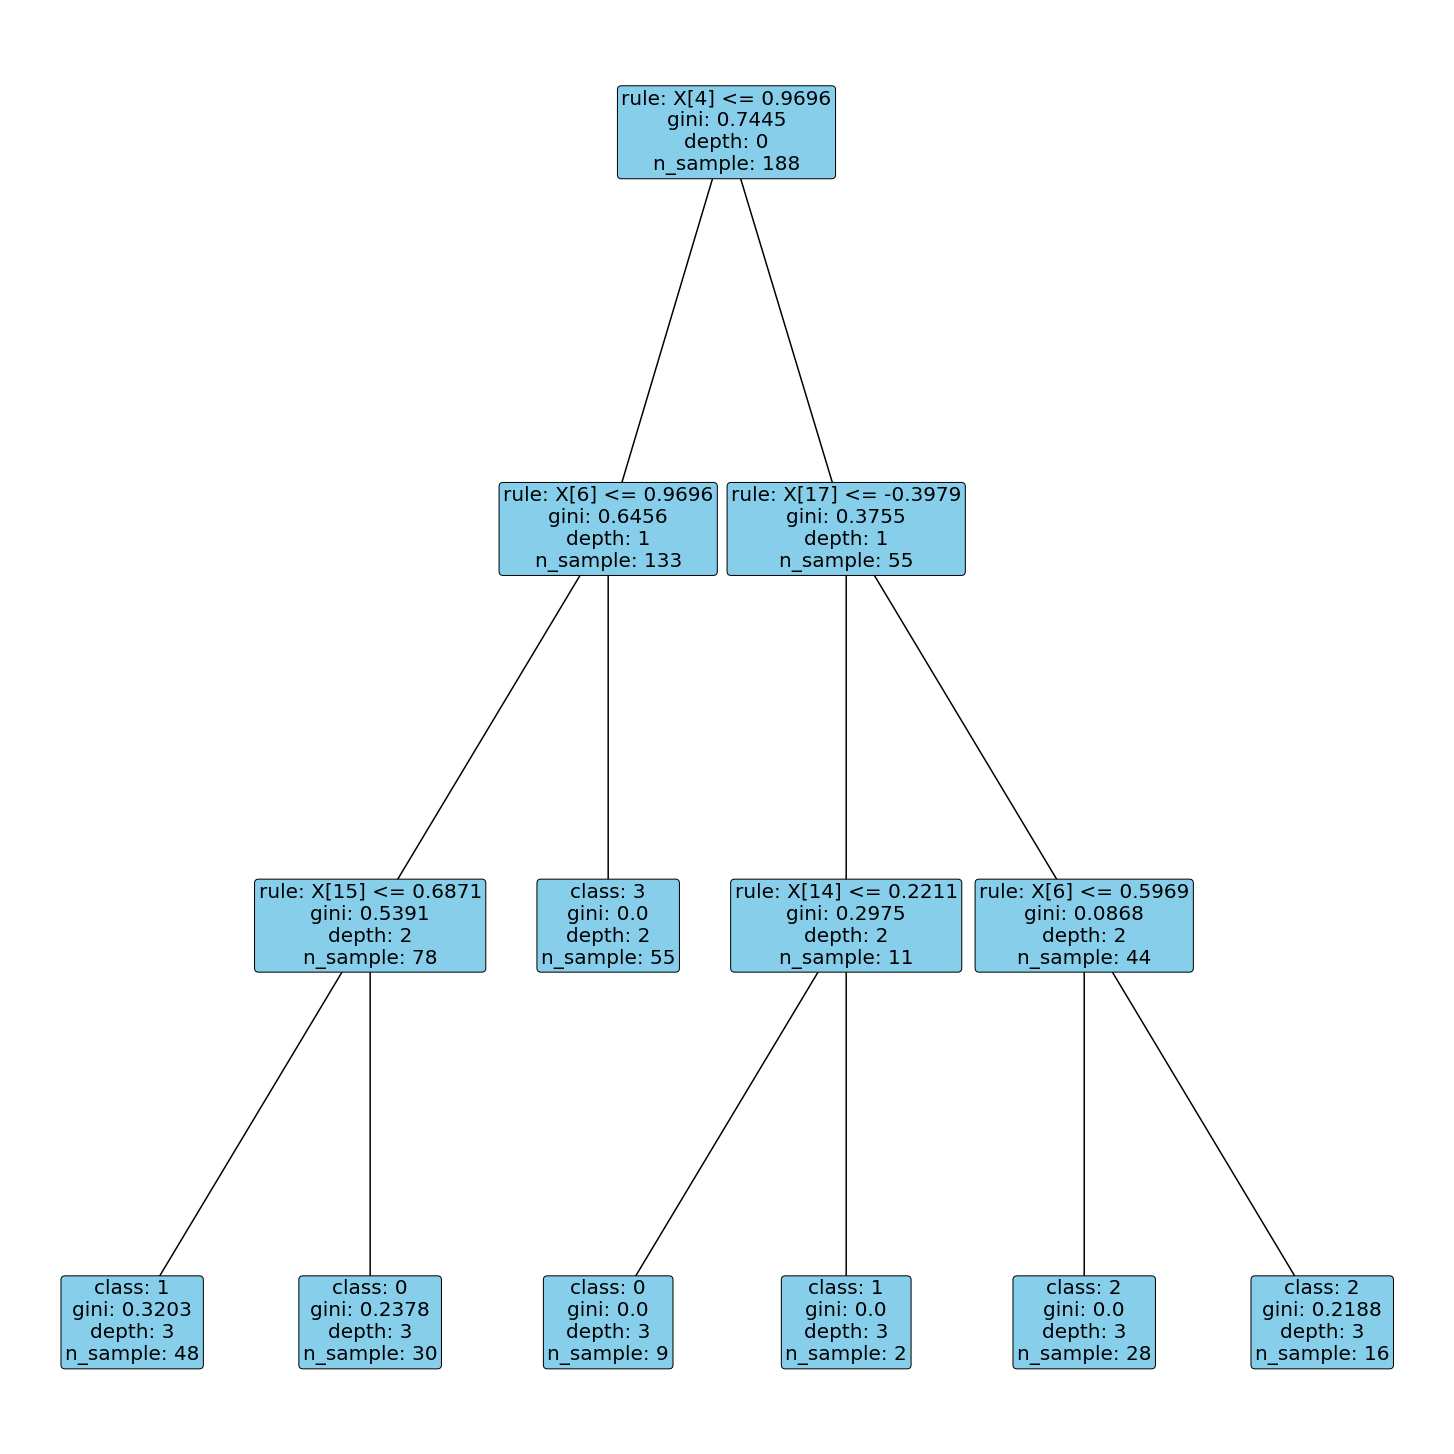

In [ ]:
my_opt_forest.visualize_tree(0)

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


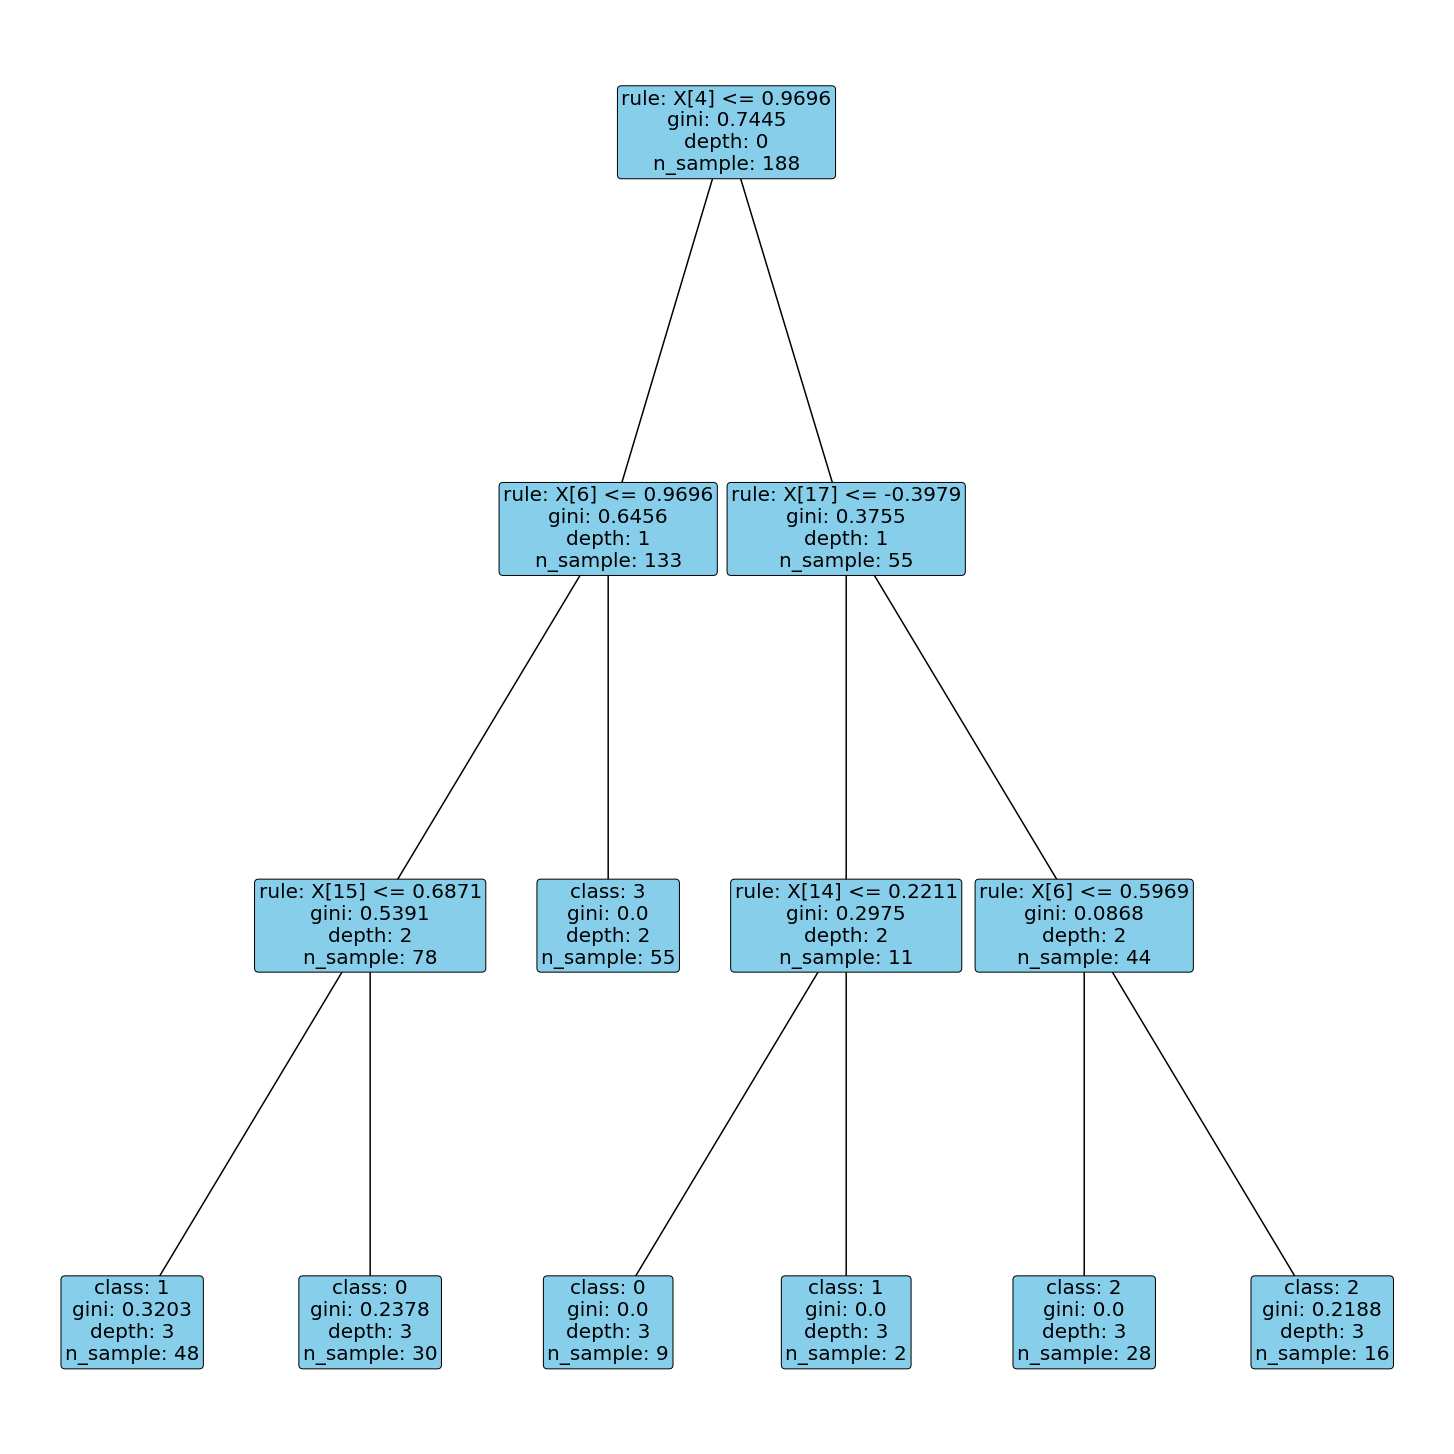

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


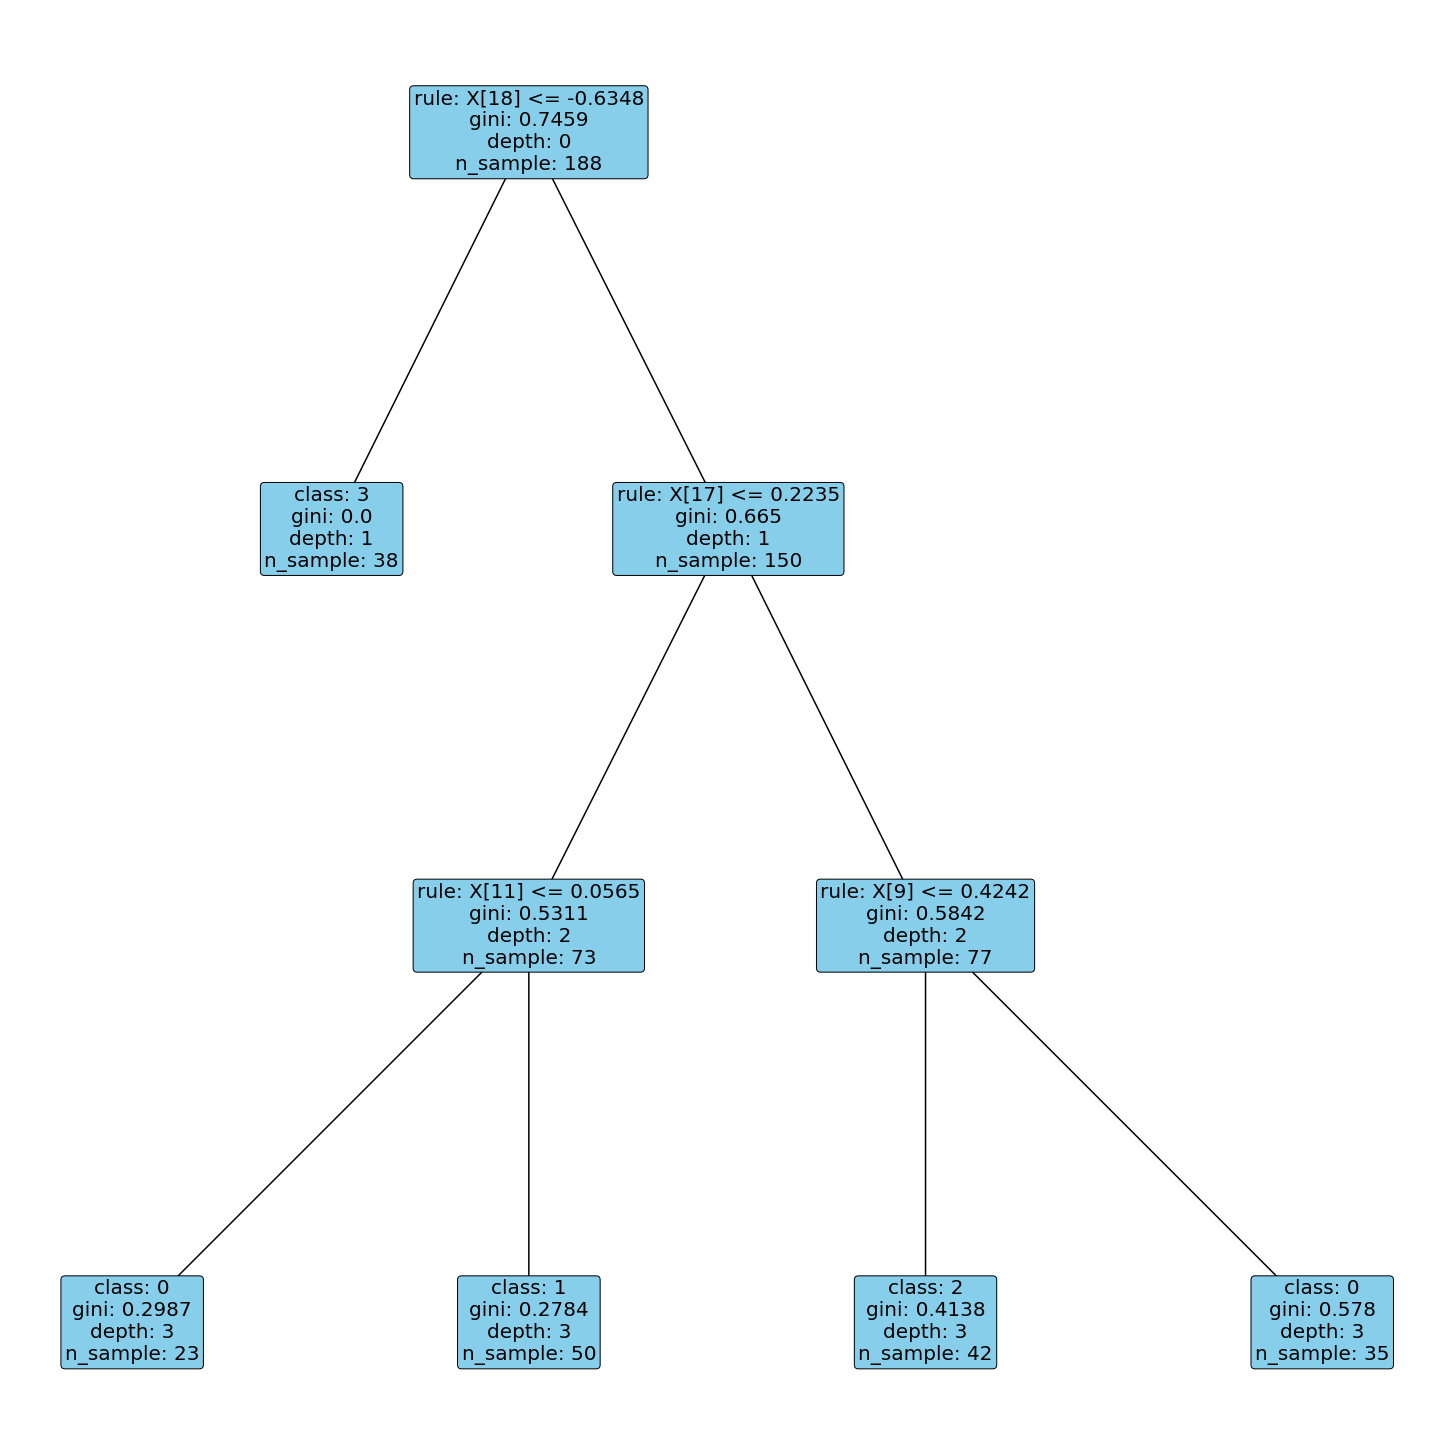

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


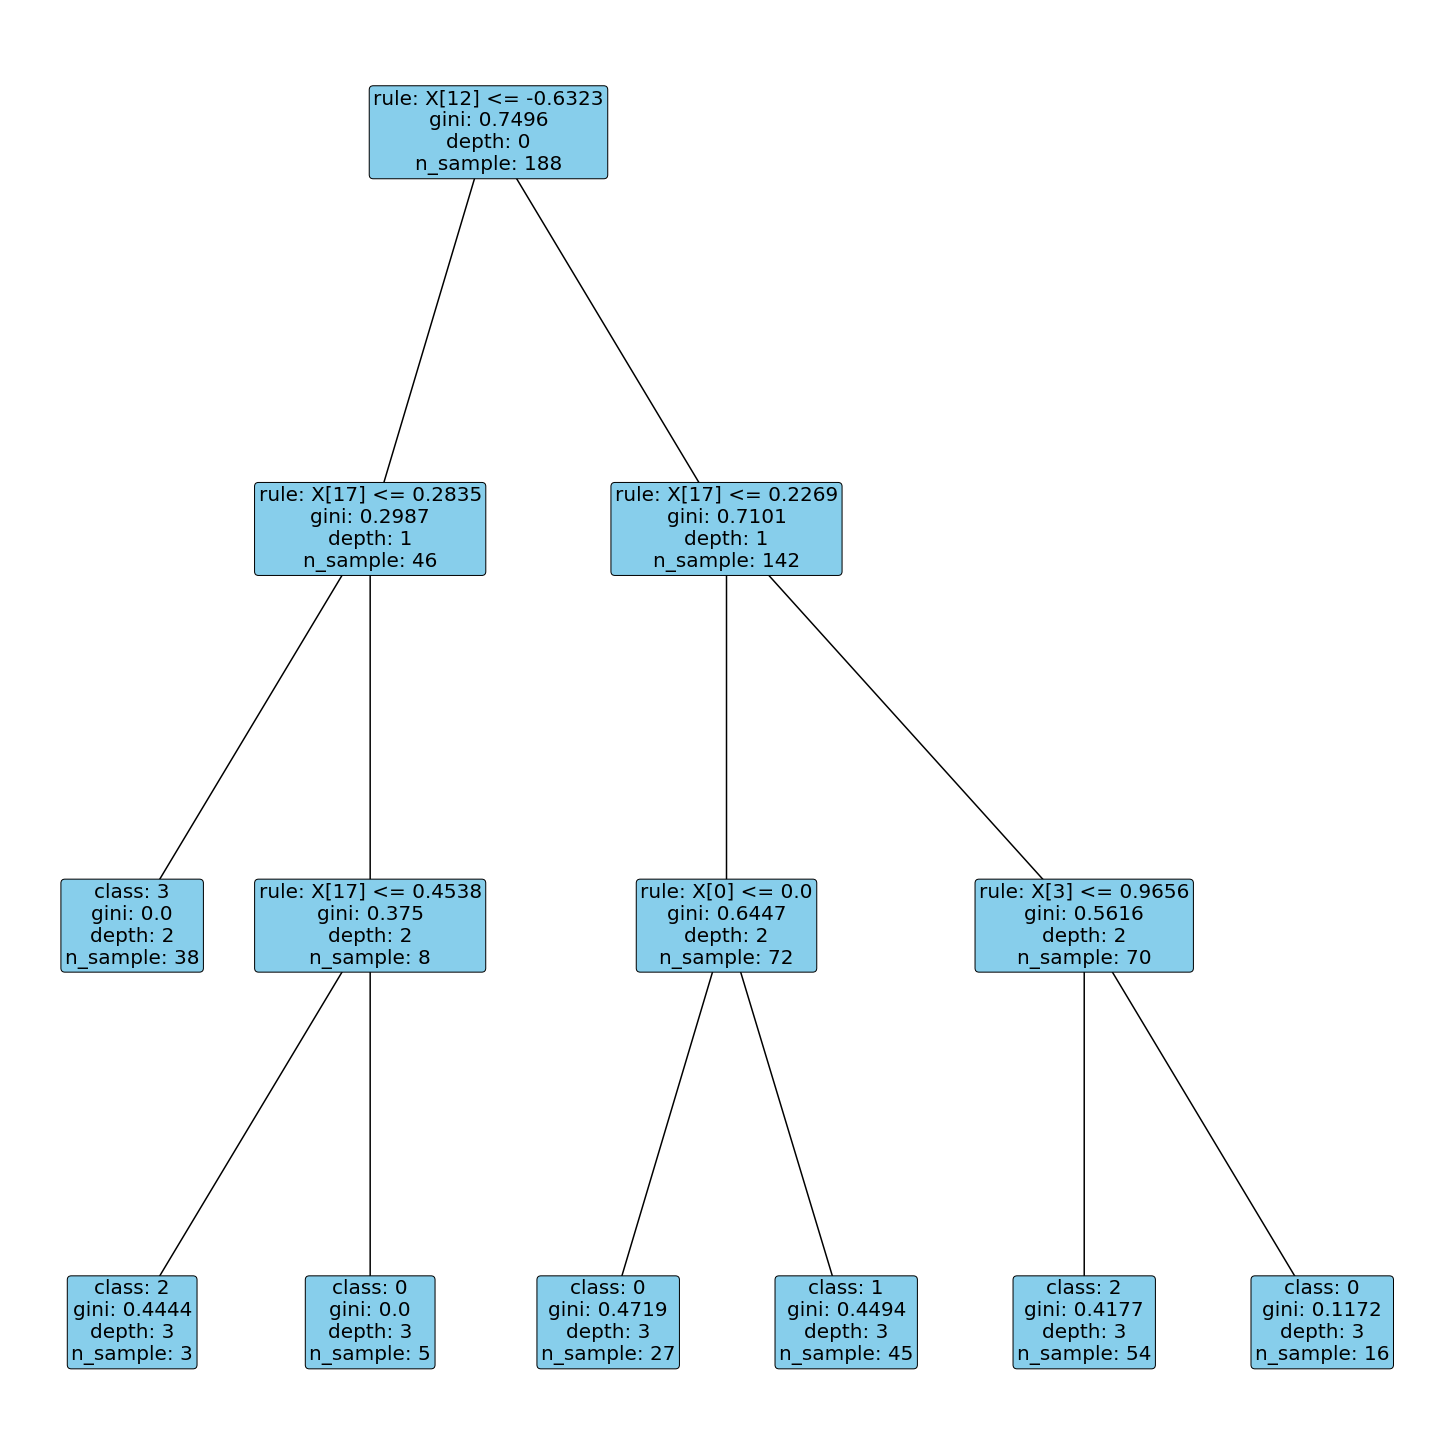

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


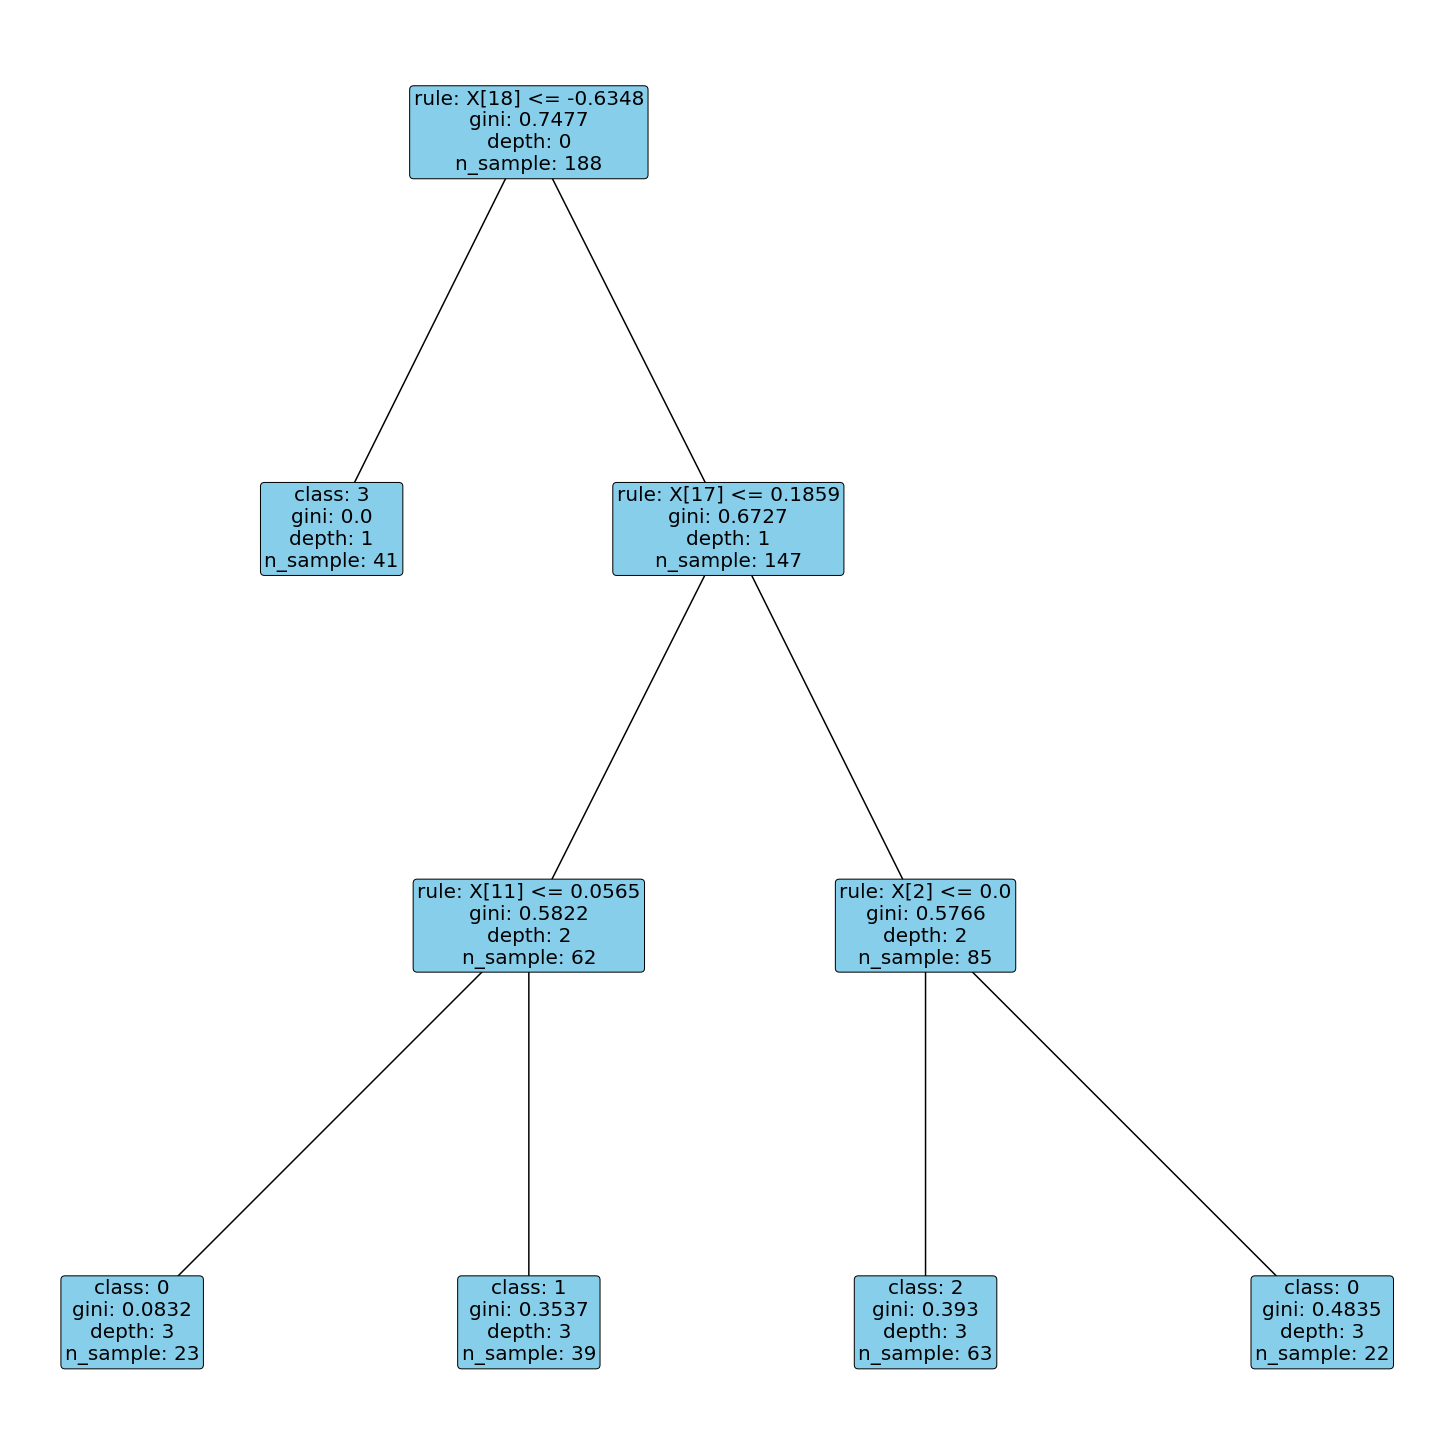

<ipython-input-6-07aee16825b8>:249: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(g, prog="dot")


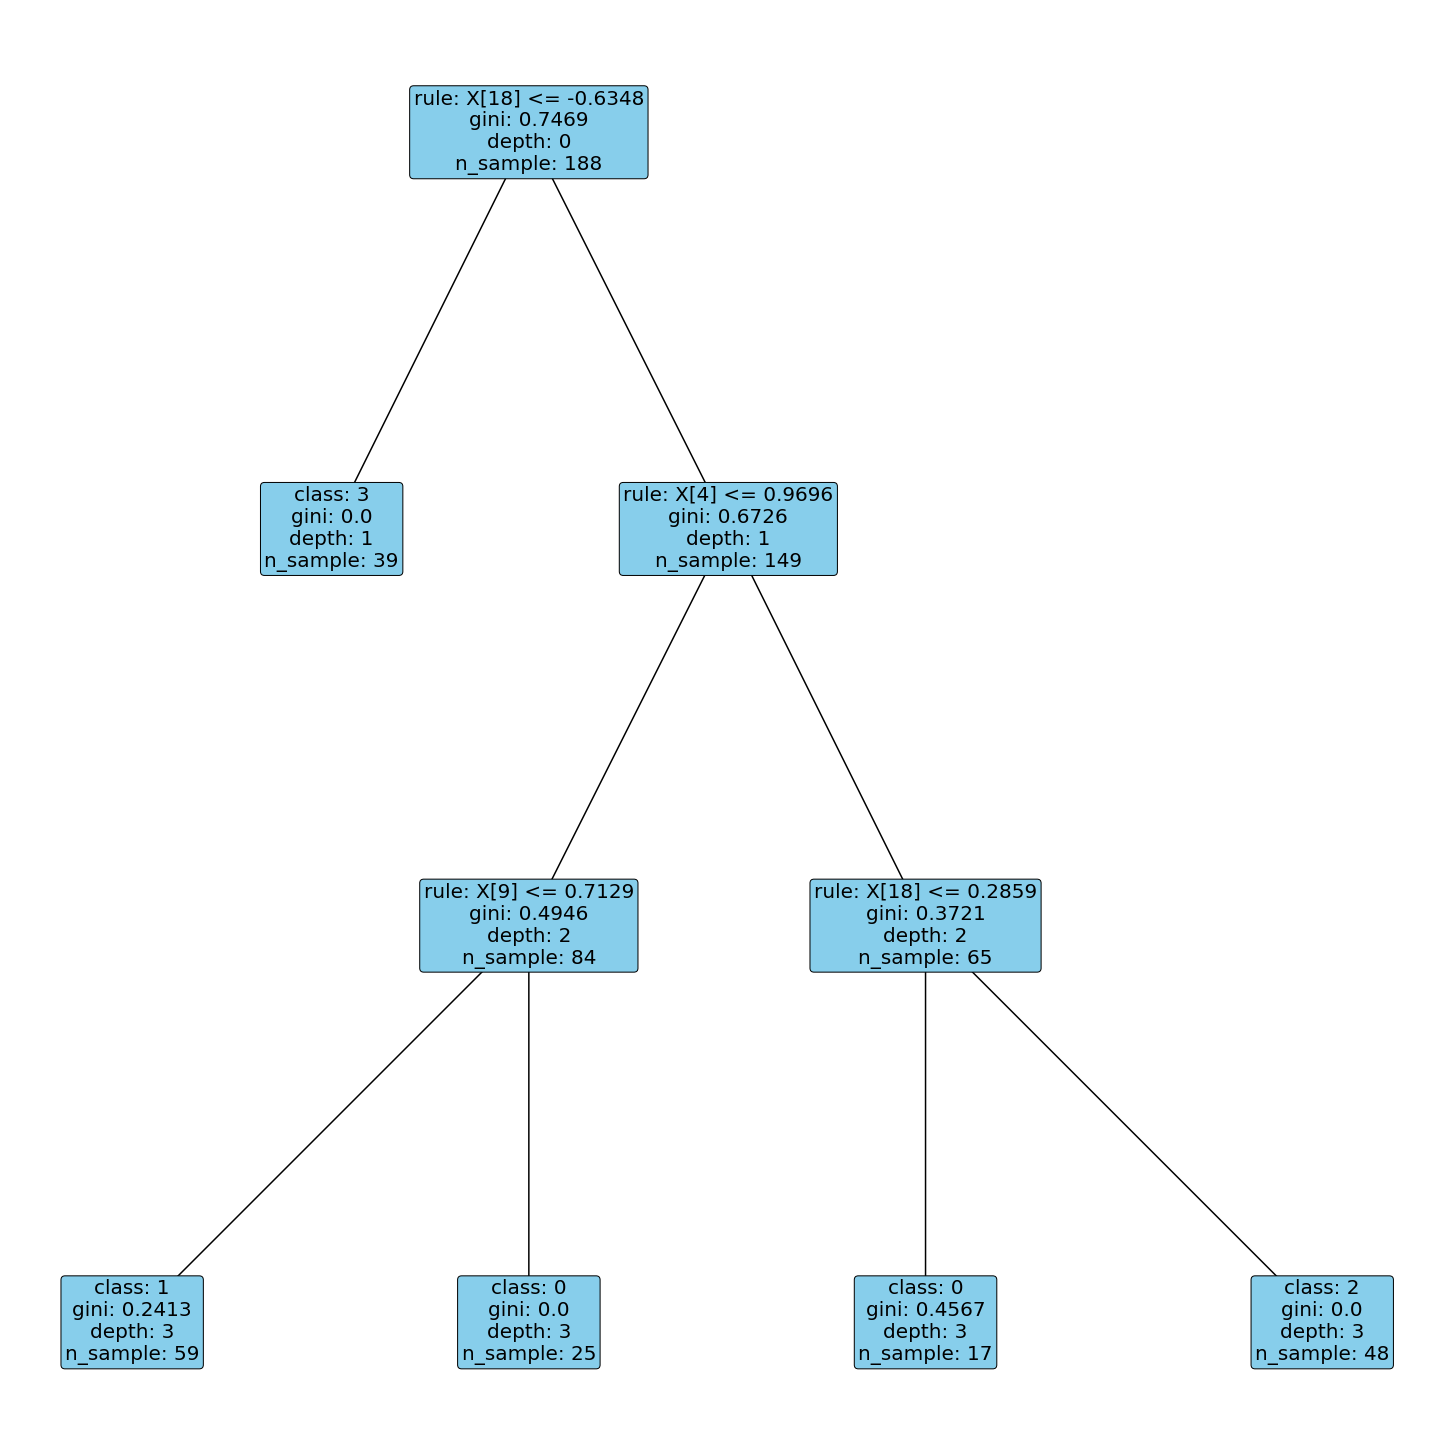

In [ ]:
for i in range (5):
  my_opt_forest.visualize_tree(i)

In [ ]:
my_opt_forest.get_json_tree(0)

{'id': 140697873727296,
 'rule': 'X[4] <= 0.9696',
 'impurity': 0.17791956381756469,
 'gini': 0.7445110909913988,
 'depth': 0,
 'n_sample': 188,
 'left_node': {'id': 140697961585872,
  'rule': 'X[6] <= 0.9696',
  'impurity': 0.3294239067883707,
  'gini': 0.645598959805529,
  'depth': 1,
  'n_sample': 133,
  'left_node': {'id': 140698033313008,
   'rule': 'X[15] <= 0.6871',
   'impurity': 0.2505506245890861,
   'gini': 0.5391190006574622,
   'depth': 2,
   'n_sample': 78,
   'left_node': {'id': 140697961706688,
    'gini': 0.3203125,
    'depth': 3,
    'n_sample': 48,
    'class': 1.0},
   'right_node': {'id': 140697961633824,
    'gini': 0.23777777777777775,
    'depth': 3,
    'n_sample': 30,
    'class': 0.0}},
  'right_node': {'id': 140698034022720,
   'gini': 0.0,
   'depth': 2,
   'n_sample': 55,
   'class': 3.0}},
 'right_node': {'id': 140697873687600,
  'rule': 'X[17] <= -0.3979',
  'impurity': 0.24661157024793406,
  'gini': 0.37553719008264463,
  'depth': 1,
  'n_sample': 55,
